# Configuration - Important

In [1]:
LM_Flag = False  # True when the LSTM LM is already available and can be loaded
Classifier_Flag = False  # Truen when the LSTM classifier model is already available and can be loaded


# Importing Required Modules

## General Libraries

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import regex as re
from tqdm import tqdm
import pickle
import warnings 


In [3]:
# Plotting theme
sns.set_theme(style="darkgrid")
warnings.filterwarnings("ignore")

## NLP

In [4]:
import spacy
import textacy
import textacy.preprocessing as tprep
import html

## Classification Modelling

In [5]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, ConfusionMatrixDisplay, classification_report
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelBinarizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.pipeline import make_pipeline

##  Deep Learning

In [6]:
from fastai.text.all import *

# User Defined Functions

## General

In [7]:
def rearrange_columns(df, dict = None):
    """
    

    Parameters
    ----------
    df : DataFrame
        The target Dataframe which columns should be rearranged.
    dict : Dictionary, optional
        A dictionart containing the labelling mapping. The default is None.

    Returns
    -------
    df : DataFrame
        The rearranged dataframe.

    """

    if dict is None:

        text = df["text"]
        sentiment = df["sentiment"]

    else:

        text = df[dict["text"]]
        sentiment = df[dict["sentiment"]]

    df = pd.concat([text, sentiment], axis=1)

    return df

In [8]:
def build_folder(df, sent_col, text_col, set_col, labels_list = ["positive", "negative"]):
    """
    A function to build a folder containing the records of a dataset saved as text files. The structure of the folder is:
        - Data/labelled/{set}/{sentiment}/{n_record}.txt

    Parameters
    ----------
    df : DataFrame
        The dataframe containing the text data.
    sent_col : Integer
        The index of the sentiment column.
    text_col : Integer
        The index of the text column.
    set_col : Integer
        The index of the set column.
    labels_list : list, optional
        A list containing the labels of the classes. The default is ["positive", "negative"].

    Returns
    -------
    None.

    """

    for set in ["train", "test"]:

        path = "Data/labelled/" + set

        if os.path.isdir(path):

            shutil.rmtree(path)
        
        for label in labels_list:

            path = path + "/" + label

            os.makedirs(path)

            path = "Data/labelled/" + set

    for row in tqdm(range(len(df))):

        text = df.iloc[row, text_col]
        sentiment = df.iloc[row, sent_col]
        set_label = df.iloc[row, set_col]

        file = open(f'Data/labelled/{set_label}/{sentiment}/{row}.txt', "w")
        file.write(text)
        file.close()

## Text Cleaning

In [9]:
def impurity_ratio(text, regex, min_len=10):
    """
    

    Parameters
    ----------
    text : str
        The text to be analysed.
    regex : regular expression.
        A regular expresion containing the characters considered impure.
    min_len : int, optional
        minimum length of the string to be analysed. The default is 10.

    Returns
    -------
    int
        Impurity ratio of the analysed text.

    """
    
    
    if len(text) < min_len:
        return 0
    else:
        return len(regex.findall(text))/len(text)

In [10]:
def clean_text(text):
    """
    

    Parameters
    ----------
    text : str
        Text that will be cleaned according to the rules explained in the comments.

    Returns
    -------
    str
        Returns the cleaned text.

    """
    
    # convert html escapes like &amp; to characters.
    text = html.unescape(text)

    # tags like <tab>
    text = re.sub(r'<[^<>]*>', ' ', text)

    # markdown URLs like [Some text](https://....)
    text = re.sub(r'\[([^\[\]]*)\]\([^\(\)]*\)', r'\1', text)

    # text or code in brackets like [0]
    text = re.sub(r'\[[^\[\]]*\]', ' ', text)

    # standalone sequences of specials, matches &# but not #cool
    text = re.sub(r'(?:^|\s)[&#<>{}\[\]+|\\:-]{1,}(?:\s|$)', ' ', text)

    # standalone sequences of hyphens like --- or ==
    text = re.sub(r'(?:^|\s)[\-=\+]{2,}(?:\s|$)', ' ', text)

    # sequences of white spaces
    text = re.sub(r'\s+', ' ', text)

    ###########
    # The ones between ########### were added after one cleaning process, consider removed them for other datasets

    # sequences of > at the begining or end of word

    text = re.sub(r'\s>+|^>+|<+\s|<+$', ' ', text)
    
    # sequences of # (more than 1) at the begining or end of word

    text = re.sub(r'\b#{2,}|#{2,}\b', ' ', text)

    # - at the end of beginning of word

    text = re.sub(r'\s-|-\s|-$', ' ', text)
    
    # sequences of # (one or more) at the begining of number between 0-20 as in #1

    text = re.sub(r'#(?=[0-9])', ' ', text)

    ###########

    return text.strip()

    

## Text Processing

In [11]:
def extract_features(doc, filter_stops=True, filter_nums=False, include_pos=["NOUN", "ADJ", "VERB", "ADV"], min_freq=1, prec_words=["ADJ", "VERB"]
                    , include_types = ["PERSON", "GPE", "LOCATION", "FAC", "PRODUCT", "WORK_OF_ART"], extract_nam_ents=True):
    """
    

    Parameters
    ----------
    doc : spacy doc object
        Doc object containing the text to be processed
    filter_stops : boolean, optional
        Flag to filter stop words. The default is True.
    filter_nums : boolean, optional
        Flag to filter numbers. The default is False.
    include_pos : list, optional
        List containing the PoS to be retained. The default is ["NOUN", "ADJ", "VERB", "ADV"].
    min_freq : int, optional
        Minimum frequency of the words that will be retained. The default is 1.
    prec_words : list, optional
        List containing the PoS for ngrams pattern creation. The default is ["ADJ", "VERB"].
    include_types: list, optional
        List containing the types of named entities to be extracted. The defaults is ["PERSON", "GPE", "LOCATION", "FAC", "PRODUCT", "WORK_OF_ART"].
    extract_n_ents : boolean, optional
        Flag to extract named entities.

    Returns
    -------
    dict
        A dictionary containing the features extracted from the text: lemmas, ngrams, named entities.

    """

    # Tokenization - filtering stop words, punctuation, meaningless pos
    tokens = list(textacy.extract.words(doc,
                               filter_stops=filter_stops,  # Filters out stop words, based on spacy internal english stop words dict
                               filter_punct=True,  # Filters out puncutation
                               filter_nums=filter_nums,  # Does not filter out numbers
                               include_pos=include_pos,  # Include these parts of speech
                               min_freq=min_freq  # minimun freq to be not filtered out
                               ))

    # Lemmatization
    lemmas = [token.lemma_ for token in tokens]

    # n-grams (adj_verb_noun)
    patterns = []

    for pos in prec_words:

        patterns.append(f'POS:{pos} POS:NOUN:+')

    spans = list(textacy.extract.matches.token_matches(doc, patterns))
    ngrams = ["_".join([token.lemma_ for token in span]) for span in spans]

    # Extract named entities
    if extract_nam_ents:
        ents_raw = list(textacy.extract.entities(doc, include_types=include_types))
        ents = ["_".join([token.lemma_ for token in ent]) + "/" + ent.label_ for ent in ents_raw]

    else:
        ents = None

    return {"lemmas": lemmas, "ngrams": ngrams, "named_ents": ents}
    

In [12]:
def process_dataset(nlp, df, batch_size=50, **kwargs):
    """
    

    Parameters
    ----------
    nlp : Spacy language model
        Contains the rules ans vocabulary that will be used to process the text data.
    df : Pandas DataFrame
        A dataset containing the text data.
    batch_size : int, optional
        Batch size for the pipe processing. The default is 50.
    **kwargs : various
        Arguments that will be passed to function extract_features().

    Returns
    -------
    df : Pandas DataFrame
        A dataset containing the processed text data.

    """

    # This first block purpose is to generate the shape of the output df
    doc = nlp(df.iloc[0,0])
    features = extract_features(doc, **kwargs)

    for column in features.keys():
        
        df[column] = None

    
    for i in tqdm(range(0, df.shape[0], batch_size)):

        docs = nlp.pipe(df.iloc[i:i+batch_size, 0])  # assumed that the text data is the first column of the df

        for j, doc in enumerate(docs):

            features = extract_features(doc, **kwargs)
            
            for column, value in features.items():

                df.loc[i+j][column] = value

    return df

## Modelling

In [13]:
def perf_classification(y_train, y_test, y_pred_train, y_pred_test, pos_label=1):
    """


    Parameters
    ----------
    y_train : DataFrame or Series
        Observed Target Variable (train set).
    y_test : DataFrame or Series
        Observed Target Variable (test set).
    y_pred_train : DataFrame or Series
        Predicted Target Variable (train set).
    y_pred_test : DataFrame or Series
        Predicted Target Variable (test set).
    pos_label: integer, optional
        Label of interest to calculate metrics (recall, precision)

    Returns
    -------
    performance : DataFrame
        Dataframe containing the performance metrics (accuracy, precision, recall).

    """
    

    performance = pd.DataFrame({'error_metric': ['accuracy', 'precision', 'recall'],
                                'train': [accuracy_score(y_train, y_pred_train),
                                          precision_score(y_train, y_pred_train, pos_label=pos_label),
                                          recall_score(y_train, y_pred_train, pos_label=pos_label)],
                                'test':  [accuracy_score(y_test, y_pred_test),
                                          precision_score(y_test, y_pred_test, pos_label=pos_label),
                                          recall_score(y_test, y_pred_test, pos_label=pos_label)]})

    performance = performance.set_index("error_metric")

    return performance

In [14]:
def classification(x_train, y_train, x_test, y_test, model, cv=10, pos_label=1, verbose=True, plot=True):
    """


    Parameters
    ----------
    x_train : DataFrame or Series
        Estimators (train set).
    y_train : DataFrame or Series
        Observed Target Variable (train set).
    x_test : DataFrame or Series
        Estimators (test set).
    y_test : DataFrame or Series
        Observed Target Variable (test set).
    model : Sklearn model object
        Model to be used for the prediction
    cv : Integer, optional
        Number of cross validation folds. The default is 10.
    pos_label: integer, optional
        Label of interest to calculate metrics (recall, precision)
    verbose : Boolean, optional
        The default is True.
    plot : Boolean, optional
        The default is True.
    y_transformer : String or sklearn transformer object, optional
        The normalization transformer used on the target variable, if any. The default is None.

    Returns
    -------
    dict
        Results of the classification.
        - Fitted Model
        - Cross Validation Scores
        - Prediction results
        - Performance Metrics

    """

    # Model cross validation
    val_scores = cross_val_score(model, x_train, y_train, cv=cv)

    # Fit the model
    model.fit(x_train, y_train)

    # Predictions
    y_pred_train = model.predict(x_train)
    y_pred_test = model.predict(x_test)

    prediction_results = pd.DataFrame({"train": {"y": y_train, "y_pred": y_pred_train},
                                       "test": {"y": y_test, "y_pred": y_pred_test}})

    # Build the performance df
    performance_metrics = pd.DataFrame({"error_metric": [f'val_mean_score (k={cv})', f'val_std (k={cv})'],
                                        "train": [val_scores.mean(), val_scores.std()],
                                        "test": ["-", "-"]})
    performance_metrics = performance_metrics.set_index("error_metric")

    # Performance Evaluation
    error_metrics = perf_classification(y_train, y_test, y_pred_train, y_pred_test)
    performance_metrics = pd.concat([performance_metrics, error_metrics], axis=0)

    if verbose:
        print("-----------------")
        print(f'The model score using K-fold cross validation (k={cv}) is {round(val_scores.mean(), 3)} '
              f'with a standard deviation of {round(val_scores.std(), 3)}')
        print("-----------------")
        print("The performance metrics of the model")
        display(performance_metrics)
        print("-----------------")

    if plot:
        print("Confusion matrix for the train set")
        print("-----------------")

        ConfusionMatrixDisplay.from_predictions(y_train, y_pred_train)
        plt.show()

        print("Confusion matrix for the test set")
        print("-----------------")

        ConfusionMatrixDisplay.from_predictions(y_test, y_pred_test)
        plt.show()

    return {"model": model, "val_scores": val_scores, "prediction_results": prediction_results,
            "performance_metrics": performance_metrics}

In [15]:
def text_classification(x, y, vect_model, pred_model, test_size=0.2, random_state=0, cv=10, pipeline_flag=False):
    """
    

    Parameters
    ----------
    x : DataFrame
        Estimators.
    y : DataFrame
        Observed Target Variable.
    vect_model : Sklearn Vectorization Object
        Transformed that will be used to go from text to numbers.
    pred_model : Sklearn Model Object
        Model to be used for the prediction.
    test_size : Float, optional
        Size in fraction (0-1) of the test set. The default is 0.2.
    random_state : Integer, optional
        Random seed. The default is 0.
    cv : Integer, optional
        Number of cross validation folds. The default is 10.
    pipeline_flag : Boolean, optional
        True if the sklearn model input is a prediction model only or a pipeline. The default is False.

    Returns
    -------
    output : Dictionary
        The output of function classification(). This is:
            - Fitted Model
            - Cross Validation Scores
            - Prediction results
            - Performance Metrics.

    """

    # Train/Test Split
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=test_size, random_state=random_state, stratify=y)

    if not pipeline_flag:

        # Vectorization
        vect_model.fit(x_train)
        x_vect_train = vect_model.transform(x_train)
        x_vect_test = vect_model.transform(x_test)

        # Prediction
        output = classification(x_vect_train, y_train, x_vect_test, y_test, pred_model, cv=cv)

    if pipeline_flag:

        # Create pipeline - Vectorization-Prediction
        pipeline = make_pipeline(vect_model, pred_model)

        # Run pipeline
        output = classification(x_train, y_train, x_test, y_test, pipeline, cv=cv)


    return output

# Traditional NLP

## Loading and preparing the data

We load our financial headlines from a csv file. The source of the dataset is https://www.kaggle.com/ankurzing/sentiment-analysis-for-financial-news. The dataset contains 4,846 rows labelled as positive, negative or neutral.

In [16]:
financial_df = pd.read_csv("Data/csv/all-data.csv", encoding = "ISO-8859-1")
financial_df = rearrange_columns(financial_df)  # Columns rearranged to have text, sentiment
financial_df.head()

,text,sentiment
0,"According to Gran , the company has no plans to move all production to Russia , although that is where the company is growing .",neutral
1,"Technopolis plans to develop in stages an area of no less than 100,000 square meters in order to host companies working in computer technologies and telecommunications , the statement said .",neutral
2,"The international electronic industry company Elcoteq has laid off tens of employees from its Tallinn facility ; contrary to earlier layoffs the company contracted the ranks of its office workers , the daily Postimees reported .",negative
3,With the new production plant the company would increase its capacity to meet the expected increase in demand and would improve the use of raw materials and therefore increase the production profitability .,positive
4,"According to the company 's updated strategy for the years 2009-2012 , Basware targets a long-term net sales growth in the range of 20 % -40 % with an operating profit margin of 10 % -20 % of net sales .",positive


### Preprocessing the data - removing rows with not unicode characters

In [17]:
mask = []
n_errors = 0

for row in range(len(financial_df)):

    text = financial_df.iloc[row, 0]
    
    # Dummy File - we will try to write the i record, if we catch a UnicodeEncodeError we skip that particular record
    file = open(f'temp.txt', "w")

    try:

        file.write(text)
        mask.append(True)

    except UnicodeEncodeError:
        
        mask.append(False)
        n_errors += 1


financial_df = financial_df[mask]

print(n_errors)
print(len(mask))

74
4846


### Dropping the neutral sentiment records

Our analysis will consider two labels, positive or negative sentiment. Therefore we drop from our dataset the neutral sentiment rows.

In [18]:
financial_df = (financial_df[(financial_df["sentiment"]=="positive") | (financial_df["sentiment"]=="negative")]
                .reset_index(drop=True)
                )
financial_df

,text,sentiment
0,"The international electronic industry company Elcoteq has laid off tens of employees from its Tallinn facility ; contrary to earlier layoffs the company contracted the ranks of its office workers , the daily Postimees reported .",negative
1,With the new production plant the company would increase its capacity to meet the expected increase in demand and would improve the use of raw materials and therefore increase the production profitability .,positive
2,"According to the company 's updated strategy for the years 2009-2012 , Basware targets a long-term net sales growth in the range of 20 % -40 % with an operating profit margin of 10 % -20 % of net sales .",positive
3,FINANCING OF ASPOCOMP 'S GROWTH Aspocomp is aggressively pursuing its growth strategy by increasingly focusing on technologically more demanding HDI printed circuit boards PCBs .,positive
4,"For the last quarter of 2010 , Componenta 's net sales doubled to EUR131m from EUR76m for the same period a year earlier , while it moved to a zero pre-tax profit from a pre-tax loss of EUR7m .",positive
...,...,...
1940,"HELSINKI Thomson Financial - Shares in Cargotec fell sharply in early afternoon trade after the cargo handling group posted a surprise drop in April-June profits , which overshadowed the large number of new orders received during the three months .",negative
1941,LONDON MarketWatch -- Share prices ended lower in London Monday as a rebound in bank stocks failed to offset broader weakness for the FTSE 100 .,negative
1942,"Operating profit fell to EUR 35.4 mn from EUR 68.8 mn in 2007 , including vessel sales gain of EUR 12.3 mn .",negative
1943,"Net sales of the Paper segment decreased to EUR 221.6 mn in the second quarter of 2009 from EUR 241.1 mn in the second quarter of 2008 , while operating profit excluding non-recurring items rose to EUR 8.0 mn from EUR 7.6 mn .",negative


### Saving the preprocessed data

In [19]:
financial_df.to_csv("Data/csv/fin_lab.csv", index=False)

## Data Exploration

### Basic Exploration

In [20]:
financial_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1945 entries, 0 to 1944
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   text       1945 non-null   object
 1   sentiment  1945 non-null   object
dtypes: object(2)
memory usage: 30.5+ KB


The original text prior to any cleaning or normalization is stored.

In [21]:
text_raw_df = financial_df["text"].copy()

In [22]:
sentiment_count = financial_df["sentiment"].value_counts(dropna=False)


Bar Plot of the sentiment binary distribution. The dataset is imbalance, with more positive records than negative.

<BarContainer object of 2 artists>

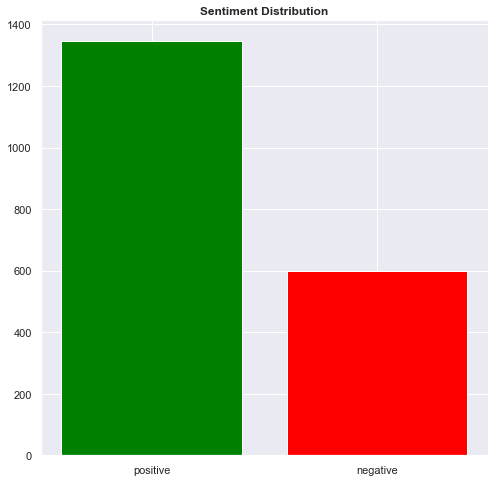

In [23]:
# create figure and axes
fig1, ax1 = plt.subplots(figsize = (8,8))

# set title
ax1.set_title('Sentiment Distribution', fontweight='bold')

# plot the bar chart
ax1.bar(sentiment_count.index, sentiment_count, color=('green','red'))

There are no missing values in the data and all are string.

In [24]:
text_n_nostr = financial_df["text"].shape[0] - sum([isinstance(i, str) for i in financial_df["text"]])
sentiment_n_nostr = financial_df["sentiment"].shape[0] - sum([isinstance(i, str) for i in financial_df["sentiment"]])

print(f"The number of values not string in column text is {text_n_nostr}.")
print(f"The number of missing values in sentiment column is {sentiment_n_nostr}.")

The number of values not string in column text is 0.
The number of missing values in sentiment column is 0.


### Exploring the length of the texts

Let us create a new column with the lenght of the text text.

In [25]:
financial_df.insert(1, column="text_length", value=[len(text) for text in financial_df["text"]])
financial_df.head(10)

,text,text_length,sentiment
0,"The international electronic industry company Elcoteq has laid off tens of employees from its Tallinn facility ; contrary to earlier layoffs the company contracted the ranks of its office workers , the daily Postimees reported .",228,negative
1,With the new production plant the company would increase its capacity to meet the expected increase in demand and would improve the use of raw materials and therefore increase the production profitability .,206,positive
2,"According to the company 's updated strategy for the years 2009-2012 , Basware targets a long-term net sales growth in the range of 20 % -40 % with an operating profit margin of 10 % -20 % of net sales .",203,positive
3,FINANCING OF ASPOCOMP 'S GROWTH Aspocomp is aggressively pursuing its growth strategy by increasingly focusing on technologically more demanding HDI printed circuit boards PCBs .,178,positive
4,"For the last quarter of 2010 , Componenta 's net sales doubled to EUR131m from EUR76m for the same period a year earlier , while it moved to a zero pre-tax profit from a pre-tax loss of EUR7m .",193,positive
5,"In the third quarter of 2010 , net sales increased by 5.2 % to EUR 205.5 mn , and operating profit by 34.9 % to EUR 23.5 mn .",125,positive
6,Operating profit rose to EUR 13.1 mn from EUR 8.7 mn in the corresponding period in 2007 representing 7.7 % of net sales .,122,positive
7,"Operating profit totalled EUR 21.1 mn , up from EUR 18.6 mn in 2007 , representing 9.7 % of net sales .",103,positive
8,TeliaSonera TLSN said the offer is in line with its strategy to increase its ownership in core business holdings and would strengthen Eesti Telekom 's offering to its customers .,178,positive
9,"STORA ENSO , NORSKE SKOG , M-REAL , UPM-KYMMENE Credit Suisse First Boston ( CFSB ) raised the fair value for shares in four of the largest Nordic forestry groups .",164,positive


The headlines are in of course in general short, with a average length of 170 characters.

In [26]:
financial_df.head(10).describe()

,text_length
count,10.000000
mean,170.000000
std,41.177124
min,103.000000
25%,134.750000
50%,178.000000
75%,200.500000
max,228.000000


Let us plot a distribution plot of the headlines length and a boxplot to get a sense of the oulier distribution, if any.

<AxesSubplot:title={'center':'text Text Length Distribution'}, xlabel='text_length', ylabel='Density'>

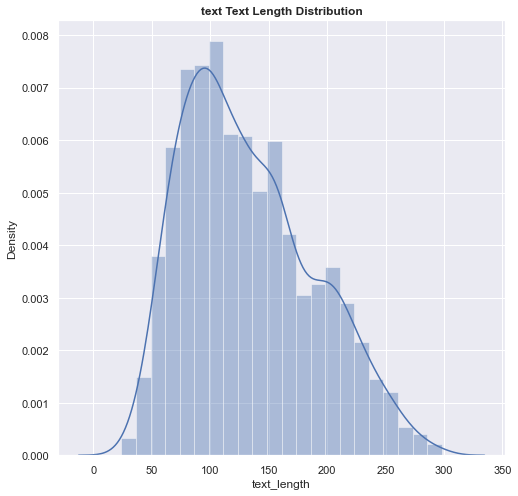

In [27]:
# create figure and axes
fig2, ax2 = plt.subplots(figsize = (8,8))

# set title
ax2.set_title('text Text Length Distribution', fontweight='bold')

# plot the bar chart
sns.distplot(financial_df["text_length"])

<AxesSubplot:title={'center':'Boxplot - Length Distribution'}, xlabel='text_length'>

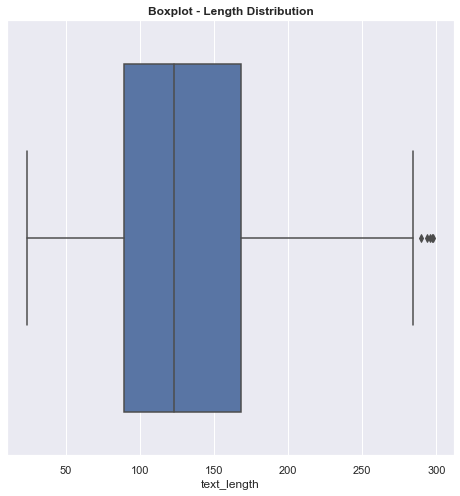

In [28]:
# create figure and axes
fig3, ax3 = plt.subplots(figsize = (8,8))

# set title
ax3.set_title('Boxplot - Length Distribution', fontweight='bold')

# plot the bar chart
sns.boxplot(financial_df["text_length"])

### Exploring the level of impurity in the text

The level of impurity is a ratio that describes of much % of the characters in a record are potentially subjected to be cleanned.

In [29]:
# characters considerd impure

RE_impure = re.compile(r'[#<>{}\[\]\\]')

The impurity ratio is calculated with the user defined function impurity_ratio().

In [30]:
# create a new columns with the text impurity

financial_df.insert(2, column="impurity", value=[impurity_ratio(text, RE_impure) for text in financial_df["text"]])
financial_df.describe()

,text_length,impurity
count,1945.000000,1945.0
mean,132.565039,0.0
std,55.485363,0.0
min,24.000000,0.0
25%,89.000000,0.0
50%,123.000000,0.0
75%,168.000000,0.0
max,298.000000,0.0


For this particular datase, the data is pretty good state. But in other datasets the impurity level can be a good first stimate of the quality of the data.

In [31]:
# get the top 10 records in terms of impurity
impurity_sorted = financial_df[["text", 'impurity']].sort_values(by='impurity', ascending=False).head(10)
impurity_sorted

,text,impurity
0,"The international electronic industry company Elcoteq has laid off tens of employees from its Tallinn facility ; contrary to earlier layoffs the company contracted the ranks of its office workers , the daily Postimees reported .",0.0
1277,"Via the agreement , Ramirent will expand the range of equipment and services it delivers to Destia , Ramirent Finland 's managing director Kari Aulasmaa , said .",0.0
1305,"And earlier this month , the company signed a deal with India-based information technology services giant Wipro Technologies to transfer and sell its radio access related R&D activities in Berlin .",0.0
1304,"Also the city 's insurance company , If P & C Insurance , has said it will not pay compensation .",0.0
1303,"Additionally , the company will terminate a maximum nine salaried and senior salaried employees ' employment contracts .",0.0
1302,"Scanfil , a systems supplier and contract manufacturer to the communications sector , will start personnel negotiations in Oulu , in Finland , to lay off staff temporarily .",0.0
1301,"Scanfil , a systems supplier and contract manufacturer to the communications sector , will give notice to 20 productional employees , and temporarily lay off 15 employees at the company 's plant in Sievi , in Finland .",0.0
1300,"In Finland , Sampo Bank , now part of the Danske Bank group , will lay off staff from the administrative and support functions .",0.0
1299,Finland-based Stockmann Group has closed seven franchising sports stores Nike in Russia .,0.0
1298,55 workers in +_m+_l will be affected by the close-down .,0.0


Let's check some records.

In [32]:
impurity_sorted.iloc[0,0]

'The international electronic industry company Elcoteq has laid off tens of employees from its Tallinn facility ; contrary to earlier layoffs the company contracted the ranks of its office workers , the daily Postimees reported .'

In [33]:
impurity_sorted.iloc[1,0]

"Via the agreement , Ramirent will expand the range of equipment and services it delivers to Destia , Ramirent Finland 's managing director Kari Aulasmaa , said ."

In [34]:
impurity_sorted.iloc[2,0]

'And earlier this month , the company signed a deal with India-based information technology services giant Wipro Technologies to transfer and sell its radio access related R&D activities in Berlin .'

## Cleaning and Normalising the Text Data

Even though this dataset is pretty clean already, we will describe and perform in the following sections a typical text cleaning and normalization pipeline.

### Cleaning the text

We cleaned the text using the user defined function clean_text().

In [35]:
financial_df.insert(3, column="text_cleaned", value=[clean_text(text) for text in financial_df["text"]])

In [36]:
# create a new columns with the cleaned text impurity
financial_df.insert(4, column="cleaned_impurity", value=[impurity_ratio(text, RE_impure) for text in financial_df["text_cleaned"]])

In [37]:
# get the top 10 records in terms of impurity
financial_df[['text_cleaned', 'cleaned_impurity']].sort_values(by='cleaned_impurity', ascending=False).head(10)

,text_cleaned,cleaned_impurity
0,"The international electronic industry company Elcoteq has laid off tens of employees from its Tallinn facility ; contrary to earlier layoffs the company contracted the ranks of its office workers , the daily Postimees reported .",0.0
1277,"Via the agreement , Ramirent will expand the range of equipment and services it delivers to Destia , Ramirent Finland 's managing director Kari Aulasmaa , said .",0.0
1305,"And earlier this month , the company signed a deal with India-based information technology services giant Wipro Technologies to transfer and sell its radio access related R&D activities in Berlin .",0.0
1304,"Also the city 's insurance company , If P C Insurance , has said it will not pay compensation .",0.0
1303,"Additionally , the company will terminate a maximum nine salaried and senior salaried employees ' employment contracts .",0.0
1302,"Scanfil , a systems supplier and contract manufacturer to the communications sector , will start personnel negotiations in Oulu , in Finland , to lay off staff temporarily .",0.0
1301,"Scanfil , a systems supplier and contract manufacturer to the communications sector , will give notice to 20 productional employees , and temporarily lay off 15 employees at the company 's plant in Sievi , in Finland .",0.0
1300,"In Finland , Sampo Bank , now part of the Danske Bank group , will lay off staff from the administrative and support functions .",0.0
1299,Finland-based Stockmann Group has closed seven franchising sports stores Nike in Russia .,0.0
1298,55 workers in +_m+_l will be affected by the close-down .,0.0


The cleaned_text and cleaned_impurity columns are renamed to be text and impurity. The new length is calculated.

In [38]:
financial_df = (financial_df.drop(["text", "impurity", "text_length"], axis=1)
                            .rename({"text_cleaned": "text", "cleaned_impurity": "impurity"}, axis=1)
                )
financial_df.insert(1, column="text_length", value=[len(text) for text in financial_df["text"]])
financial_df.head()

,text,text_length,impurity,sentiment
0,"The international electronic industry company Elcoteq has laid off tens of employees from its Tallinn facility ; contrary to earlier layoffs the company contracted the ranks of its office workers , the daily Postimees reported .",228,0.0,negative
1,With the new production plant the company would increase its capacity to meet the expected increase in demand and would improve the use of raw materials and therefore increase the production profitability .,206,0.0,positive
2,"According to the company 's updated strategy for the years 2009-2012 , Basware targets a long-term net sales growth in the range of 20 % 40 % with an operating profit margin of 10 % 20 % of net sales .",201,0.0,positive
3,FINANCING OF ASPOCOMP 'S GROWTH Aspocomp is aggressively pursuing its growth strategy by increasingly focusing on technologically more demanding HDI printed circuit boards PCBs .,178,0.0,positive
4,"For the last quarter of 2010 , Componenta 's net sales doubled to EUR131m from EUR76m for the same period a year earlier , while it moved to a zero pre-tax profit from a pre-tax loss of EUR7m .",193,0.0,positive


In [39]:
financial_df.describe()

,text_length,impurity
count,1945.000000,1945.0
mean,132.178920,0.0
std,55.054583,0.0
min,24.000000,0.0
25%,89.000000,0.0
50%,123.000000,0.0
75%,168.000000,0.0
max,298.000000,0.0


### Character Normalization

In the following sections, the text will be normalized:

- Hyphendation
- Fancy Quotation Marks
- Unicode
- Removing Accents
- Masking URLs
- Masking emails
- Masking emojis

This particular dataser did not require a lot of normalization. Nevertheless, the general pipeline is described and carried out.

#### Hyphendation

In [40]:
financial_df["text_norm"] = financial_df["text"].apply(tprep.normalize.hyphenated_words) # normalize hyphendation
                       

In this line of codes the text after and before normalization are compared. False = no change.

In [41]:
financial_df["changed"] = [financial_df["text"][i] != financial_df["text_norm"][i] for i in range(financial_df["text"].shape[0])] 
financial_df["changed"].value_counts(dropna=False)

False    1945
Name: changed, dtype: int64

In [42]:
financial_df["text"] = financial_df["text_norm"]

#### Fancy Quotation Marks

In [43]:
financial_df["text_norm"] = financial_df["text"].apply(tprep.normalize.quotation_marks) # normalize fancy quotation marks to ASCII

In this line of codes the text after and before normalization are compared. False = no change.

In [44]:
financial_df["changed"] = [financial_df["text"][i] != financial_df["text_norm"][i] for i in range(financial_df["text"].shape[0])] 
financial_df["changed"].value_counts(dropna=False)

False    1797
True      148
Name: changed, dtype: int64

In [45]:
changed = financial_df[financial_df["changed"]]
changed = changed.reset_index(drop=True)

Let's see the changes.

In [46]:
(changed["text"][0], changed["text_norm"][0])

('The combination of all services enabling us to offer a complex and strengthened service chain not only limited to the Baltic port connections but also for getting access to the world wide Grimaldi Network into the Mediterranean , Africa and North America `` says Uwe Bakosch .',
 "The combination of all services enabling us to offer a complex and strengthened service chain not only limited to the Baltic port connections but also for getting access to the world wide Grimaldi Network into the Mediterranean , Africa and North America '' says Uwe Bakosch .")

In [47]:
financial_df["text"] = financial_df["text_norm"]

#### Unicode

In [48]:
financial_df["text_norm"] = financial_df["text"].apply(tprep.normalize.unicode) # normalize unicode to ASCII

In this line of codes the text after and before normalization are compared. False = no change.

In [49]:
financial_df["changed"] = [financial_df["text"][i] != financial_df["text_norm"][i] for i in range(financial_df["text"].shape[0])] 
financial_df["changed"].value_counts(dropna=False)

False    1945
Name: changed, dtype: int64

In [50]:
financial_df["text"] = financial_df["text_norm"]

#### Removing the accents

In [51]:
financial_df["text_norm"] = financial_df["text"].apply(tprep.remove.accents) # remove accents as in ö

In this line of codes the text after and before normalization are compared. False = no change.

In [52]:
financial_df["changed"] = [financial_df["text"][i] != financial_df["text_norm"][i] for i in range(financial_df["text"].shape[0])] 
financial_df["changed"].value_counts(dropna=False)

False    1941
True        4
Name: changed, dtype: int64

In [53]:
changed = financial_df[financial_df["changed"]]
changed = changed.reset_index(drop=True)

In [54]:
(changed["text"][0], changed["text_norm"][0])

('Finnish Rautaruukki has been awarded a contract to supply and install steel superstructures for the Partihallsf+Â¦rbindelsen bridge in Gothenburg in Sweden .',
 'Finnish Rautaruukki has been awarded a contract to supply and install steel superstructures for the Partihallsf+A¦rbindelsen bridge in Gothenburg in Sweden .')

In [55]:
financial_df["text"] = financial_df["text_norm"]

#### Masking URLs

In [56]:
financial_df["text_norm"] = financial_df["text"].apply(tprep.replace.urls)  # replace URLs by _URL_

In this line of codes the text after and before normalization are compared. False = no change.

In [57]:
financial_df["changed"] = [financial_df["text"][i] != financial_df["text_norm"][i] for i in range(financial_df["text"].shape[0])] 
financial_df["changed"].value_counts(dropna=False)

False    1945
Name: changed, dtype: int64

In [58]:
financial_df["text"] = financial_df["text_norm"]

#### Masking Emojis

In [59]:
financial_df["text_norm"] = financial_df["text"].apply(tprep.replace.emojis)  # replace emojis by _EMOJI_

In this line of codes the text after and before normalization are compared. False = no change.

In [60]:
financial_df["changed"] = [financial_df["text"][i] != financial_df["text_norm"][i] for i in range(financial_df["text"].shape[0])] 
financial_df["changed"].value_counts(dropna=False)

False    1945
Name: changed, dtype: int64

In [61]:
financial_df["text"] = financial_df["text_norm"]

#### Masking Emails

In [62]:
financial_df["text_norm"] = financial_df["text"].apply(tprep.replace.emails)  # replace emails by _EMAIL_

In this line of codes the text after and before normalization are compared. False = no change.

In [63]:
financial_df["changed"] = [financial_df["text"][i] != financial_df["text_norm"][i] for i in range(financial_df["text"].shape[0])] 
financial_df["changed"].value_counts(dropna=False)

False    1945
Name: changed, dtype: int64

In [64]:
financial_df["text"] = financial_df["text_norm"]

### Pipeline

In [65]:
financial_df = pd.read_csv("Data/csv/fin_lab.csv")

In [66]:
financial_df["text"] = (financial_df["text"].apply(clean_text)       # cleans the text, see function in functions section
                                            .apply(tprep.normalize.hyphenated_words)   # normalizes hyphendation
                                            .apply(tprep.normalize.quotation_marks)    # normalizes fancy quotation marks to ASCII
                                            .apply(tprep.normalize.unicode)            # normalizes unicode to ASCII
                                            .apply(tprep.remove.accents)               # normalizes accents
                                            .apply(tprep.replace.urls)                 # replaces urls by __URL__
                                            .apply(tprep.replace.emails)               # replaces emails by __EMAIL__
                                            .apply(tprep.replace.emojis)               # replaces emails by __EMOJI__
                        )

In [67]:
financial_df.to_csv("Data/csv/fin_lab_cleaned.csv", index=False)

## Processing the Text Data

### Initializing the spacy model

In [68]:
# we load the large english pipeline, size of vocabulary is 741MB created using news, blogs and comments

nlp = spacy.load("en_core_web_lg") 

### Tokenization

To describe the text processing pipeline a dummy string will be used.

In [69]:
sample = "My brother Victor is the best surfer in the #whole eplored-world and loves banana milk-shakes."

In [70]:
# spacy returns a "doc" object, a kind of iterable containing the tokens. The token themselves are "Token" objects.

doc = nlp(sample)

In [71]:
for token in doc:
    
    print(token, end="|")

My|brother|Victor|is|the|best|surfer|in|the|#|whole|eplored|-|world|and|loves|banana|milk|-|shakes|.|

We can see that spacy is having problems with hyphens like in explored-world. It also has problems with words starting with # or _. But it handles correctly @ and emojis.

The tokenization of spacy is based on rules. The rules are applied step-wise, starting with spliting the sentence with spaces and then applying prefix, infix and sufix rules based on regex.
We can customize the prefix and infix rules to crated our own tokenizer.

In [72]:
nlp.Defaults.prefixes

['§',
 '%',
 '=',
 '—',
 '–',
 '\\+(?![0-9])',
 '…',
 '……',
 ',',
 ':',
 ';',
 '\\!',
 '\\?',
 '¿',
 '؟',
 '¡',
 '\\(',
 '\\)',
 '\\[',
 '\\]',
 '\\{',
 '\\}',
 '<',
 '>',
 '_',
 '#',
 '\\*',
 '&',
 '。',
 '？',
 '！',
 '，',
 '、',
 '；',
 '：',
 '～',
 '·',
 '।',
 '،',
 '۔',
 '؛',
 '٪',
 '\\.\\.+',
 '…',
 "\\'",
 '"',
 '”',
 '“',
 '`',
 '‘',
 '´',
 '’',
 '‚',
 ',',
 '„',
 '»',
 '«',
 '「',
 '」',
 '『',
 '』',
 '（',
 '）',
 '〔',
 '〕',
 '【',
 '】',
 '《',
 '》',
 '〈',
 '〉',
 '\\$',
 '£',
 '€',
 '¥',
 '฿',
 'US\\$',
 'C\\$',
 'A\\$',
 '₽',
 '﷼',
 '₴',
 '₠',
 '₡',
 '₢',
 '₣',
 '₤',
 '₥',
 '₦',
 '₧',
 '₨',
 '₩',
 '₪',
 '₫',
 '€',
 '₭',
 '₮',
 '₯',
 '₰',
 '₱',
 '₲',
 '₳',
 '₴',
 '₵',
 '₶',
 '₷',
 '₸',
 '₹',
 '₺',
 '₻',
 '₼',
 '₽',
 '₾',
 '₿',
 '[\\u00A6\\u00A9\\u00AE\\u00B0\\u0482\\u058D\\u058E\\u060E\\u060F\\u06DE\\u06E9\\u06FD\\u06FE\\u07F6\\u09FA\\u0B70\\u0BF3-\\u0BF8\\u0BFA\\u0C7F\\u0D4F\\u0D79\\u0F01-\\u0F03\\u0F13\\u0F15-\\u0F17\\u0F1A-\\u0F1F\\u0F34\\u0F36\\u0F38\\u0FBE-\\u0FC5\\u0FC7-\\u0FCC\\u0F

In [73]:
# "_" and "#" are removed from the default prefixes

my_prefixes = [regex for regex in nlp.Defaults.prefixes if regex not in ["_", "#"]]
my_prefixes

['§',
 '%',
 '=',
 '—',
 '–',
 '\\+(?![0-9])',
 '…',
 '……',
 ',',
 ':',
 ';',
 '\\!',
 '\\?',
 '¿',
 '؟',
 '¡',
 '\\(',
 '\\)',
 '\\[',
 '\\]',
 '\\{',
 '\\}',
 '<',
 '>',
 '\\*',
 '&',
 '。',
 '？',
 '！',
 '，',
 '、',
 '；',
 '：',
 '～',
 '·',
 '।',
 '،',
 '۔',
 '؛',
 '٪',
 '\\.\\.+',
 '…',
 "\\'",
 '"',
 '”',
 '“',
 '`',
 '‘',
 '´',
 '’',
 '‚',
 ',',
 '„',
 '»',
 '«',
 '「',
 '」',
 '『',
 '』',
 '（',
 '）',
 '〔',
 '〕',
 '【',
 '】',
 '《',
 '》',
 '〈',
 '〉',
 '\\$',
 '£',
 '€',
 '¥',
 '฿',
 'US\\$',
 'C\\$',
 'A\\$',
 '₽',
 '﷼',
 '₴',
 '₠',
 '₡',
 '₢',
 '₣',
 '₤',
 '₥',
 '₦',
 '₧',
 '₨',
 '₩',
 '₪',
 '₫',
 '€',
 '₭',
 '₮',
 '₯',
 '₰',
 '₱',
 '₲',
 '₳',
 '₴',
 '₵',
 '₶',
 '₷',
 '₸',
 '₹',
 '₺',
 '₻',
 '₼',
 '₽',
 '₾',
 '₿',
 '[\\u00A6\\u00A9\\u00AE\\u00B0\\u0482\\u058D\\u058E\\u060E\\u060F\\u06DE\\u06E9\\u06FD\\u06FE\\u07F6\\u09FA\\u0B70\\u0BF3-\\u0BF8\\u0BFA\\u0C7F\\u0D4F\\u0D79\\u0F01-\\u0F03\\u0F13\\u0F15-\\u0F17\\u0F1A-\\u0F1F\\u0F34\\u0F36\\u0F38\\u0FBE-\\u0FC5\\u0FC7-\\u0FCC\\u0FCE\\u0FCF\\u

In [74]:
nlp.Defaults.suffixes

['…',
 '……',
 ',',
 ':',
 ';',
 '\\!',
 '\\?',
 '¿',
 '؟',
 '¡',
 '\\(',
 '\\)',
 '\\[',
 '\\]',
 '\\{',
 '\\}',
 '<',
 '>',
 '_',
 '#',
 '\\*',
 '&',
 '。',
 '？',
 '！',
 '，',
 '、',
 '；',
 '：',
 '～',
 '·',
 '।',
 '،',
 '۔',
 '؛',
 '٪',
 '\\.\\.+',
 '…',
 "\\'",
 '"',
 '”',
 '“',
 '`',
 '‘',
 '´',
 '’',
 '‚',
 ',',
 '„',
 '»',
 '«',
 '「',
 '」',
 '『',
 '』',
 '（',
 '）',
 '〔',
 '〕',
 '【',
 '】',
 '《',
 '》',
 '〈',
 '〉',
 '[\\u00A6\\u00A9\\u00AE\\u00B0\\u0482\\u058D\\u058E\\u060E\\u060F\\u06DE\\u06E9\\u06FD\\u06FE\\u07F6\\u09FA\\u0B70\\u0BF3-\\u0BF8\\u0BFA\\u0C7F\\u0D4F\\u0D79\\u0F01-\\u0F03\\u0F13\\u0F15-\\u0F17\\u0F1A-\\u0F1F\\u0F34\\u0F36\\u0F38\\u0FBE-\\u0FC5\\u0FC7-\\u0FCC\\u0FCE\\u0FCF\\u0FD5-\\u0FD8\\u109E\\u109F\\u1390-\\u1399\\u1940\\u19DE-\\u19FF\\u1B61-\\u1B6A\\u1B74-\\u1B7C\\u2100\\u2101\\u2103-\\u2106\\u2108\\u2109\\u2114\\u2116\\u2117\\u211E-\\u2123\\u2125\\u2127\\u2129\\u212E\\u213A\\u213B\\u214A\\u214C\\u214D\\u214F\\u218A\\u218B\\u2195-\\u2199\\u219C-\\u219F\\u21A1\\u21A2\\u21

In [75]:
# "_" is removed from the default sufixes

my_suffixes = [regex for regex in nlp.Defaults.suffixes if regex not in ["_"]]
my_suffixes

['…',
 '……',
 ',',
 ':',
 ';',
 '\\!',
 '\\?',
 '¿',
 '؟',
 '¡',
 '\\(',
 '\\)',
 '\\[',
 '\\]',
 '\\{',
 '\\}',
 '<',
 '>',
 '#',
 '\\*',
 '&',
 '。',
 '？',
 '！',
 '，',
 '、',
 '；',
 '：',
 '～',
 '·',
 '।',
 '،',
 '۔',
 '؛',
 '٪',
 '\\.\\.+',
 '…',
 "\\'",
 '"',
 '”',
 '“',
 '`',
 '‘',
 '´',
 '’',
 '‚',
 ',',
 '„',
 '»',
 '«',
 '「',
 '」',
 '『',
 '』',
 '（',
 '）',
 '〔',
 '〕',
 '【',
 '】',
 '《',
 '》',
 '〈',
 '〉',
 '[\\u00A6\\u00A9\\u00AE\\u00B0\\u0482\\u058D\\u058E\\u060E\\u060F\\u06DE\\u06E9\\u06FD\\u06FE\\u07F6\\u09FA\\u0B70\\u0BF3-\\u0BF8\\u0BFA\\u0C7F\\u0D4F\\u0D79\\u0F01-\\u0F03\\u0F13\\u0F15-\\u0F17\\u0F1A-\\u0F1F\\u0F34\\u0F36\\u0F38\\u0FBE-\\u0FC5\\u0FC7-\\u0FCC\\u0FCE\\u0FCF\\u0FD5-\\u0FD8\\u109E\\u109F\\u1390-\\u1399\\u1940\\u19DE-\\u19FF\\u1B61-\\u1B6A\\u1B74-\\u1B7C\\u2100\\u2101\\u2103-\\u2106\\u2108\\u2109\\u2114\\u2116\\u2117\\u211E-\\u2123\\u2125\\u2127\\u2129\\u212E\\u213A\\u213B\\u214A\\u214C\\u214D\\u214F\\u218A\\u218B\\u2195-\\u2199\\u219C-\\u219F\\u21A1\\u21A2\\u21A4\\u2

In [76]:
nlp.Defaults.infixes

['\\.\\.+',
 '…',
 '[\\u00A6\\u00A9\\u00AE\\u00B0\\u0482\\u058D\\u058E\\u060E\\u060F\\u06DE\\u06E9\\u06FD\\u06FE\\u07F6\\u09FA\\u0B70\\u0BF3-\\u0BF8\\u0BFA\\u0C7F\\u0D4F\\u0D79\\u0F01-\\u0F03\\u0F13\\u0F15-\\u0F17\\u0F1A-\\u0F1F\\u0F34\\u0F36\\u0F38\\u0FBE-\\u0FC5\\u0FC7-\\u0FCC\\u0FCE\\u0FCF\\u0FD5-\\u0FD8\\u109E\\u109F\\u1390-\\u1399\\u1940\\u19DE-\\u19FF\\u1B61-\\u1B6A\\u1B74-\\u1B7C\\u2100\\u2101\\u2103-\\u2106\\u2108\\u2109\\u2114\\u2116\\u2117\\u211E-\\u2123\\u2125\\u2127\\u2129\\u212E\\u213A\\u213B\\u214A\\u214C\\u214D\\u214F\\u218A\\u218B\\u2195-\\u2199\\u219C-\\u219F\\u21A1\\u21A2\\u21A4\\u21A5\\u21A7-\\u21AD\\u21AF-\\u21CD\\u21D0\\u21D1\\u21D3\\u21D5-\\u21F3\\u2300-\\u2307\\u230C-\\u231F\\u2322-\\u2328\\u232B-\\u237B\\u237D-\\u239A\\u23B4-\\u23DB\\u23E2-\\u2426\\u2440-\\u244A\\u249C-\\u24E9\\u2500-\\u25B6\\u25B8-\\u25C0\\u25C2-\\u25F7\\u2600-\\u266E\\u2670-\\u2767\\u2794-\\u27BF\\u2800-\\u28FF\\u2B00-\\u2B2F\\u2B45\\u2B46\\u2B4D-\\u2B73\\u2B76-\\u2B95\\u2B98-\\u2BC8\\u2BCA-\\

This one is more complicated as there is no single character representing the pattern. We need a regex expression.

In [77]:
[re.search(regex, "aa-aa") for regex in nlp.Defaults.infixes]

[None,
 None,
 None,
 None,
 None,
 None,
 <re.Match object; span=(2, 3), match='-'>,
 None]

In [78]:
nlp.Defaults.infixes[6]

'(?<=[A-Za-z\\uFF21-\\uFF3A\\uFF41-\\uFF5A\\u00C0-\\u00D6\\u00D8-\\u00F6\\u00F8-\\u00FF\\u0100-\\u017F\\u0180-\\u01BF\\u01C4-\\u024F\\u2C60-\\u2C7B\\u2C7E\\u2C7F\\uA722-\\uA76F\\uA771-\\uA787\\uA78B-\\uA78E\\uA790-\\uA7B9\\uA7FA\\uAB30-\\uAB5A\\uAB60-\\uAB64\\u0250-\\u02AF\\u1D00-\\u1D25\\u1D6B-\\u1D77\\u1D79-\\u1D9A\\u1E00-\\u1EFFёа-яЁА-ЯәөүҗңһӘӨҮҖҢҺα-ωάέίόώήύΑ-ΩΆΈΊΌΏΉΎа-щюяіїєґА-ЩЮЯІЇЄҐѓѕјљњќѐѝЃЅЈЉЊЌЀЍ\\u1200-\\u137F\\u0980-\\u09FF\\u0591-\\u05F4\\uFB1D-\\uFB4F\\u0620-\\u064A\\u066E-\\u06D5\\u06E5-\\u06FF\\u0750-\\u077F\\u08A0-\\u08BD\\uFB50-\\uFBB1\\uFBD3-\\uFD3D\\uFD50-\\uFDC7\\uFDF0-\\uFDFB\\uFE70-\\uFEFC\\U0001EE00-\\U0001EEBB\\u0D80-\\u0DFF\\u0900-\\u097F\\u0C80-\\u0CFF\\u0B80-\\u0BFF\\u0C00-\\u0C7F\\uAC00-\\uD7AF\\u1100-\\u11FF\\u4E00-\\u62FF\\u6300-\\u77FF\\u7800-\\u8CFF\\u8D00-\\u9FFF\\u3400-\\u4DBF\\U00020000-\\U000215FF\\U00021600-\\U000230FF\\U00023100-\\U000245FF\\U00024600-\\U000260FF\\U00026100-\\U000275FF\\U00027600-\\U000290FF\\U00029100-\\U0002A6DF\\U0002A700-\\U0002

In [79]:
my_infixes = [regex for regex in nlp.Defaults.infixes if not re.search(regex, 'aa-aa')]

Now we create our custome tokenizer, only changinge the prefix, infix and sufix rules.

In [80]:
my_tokenizer = spacy.tokenizer.Tokenizer(vocab=nlp.vocab,
                                         rules=nlp.Defaults.tokenizer_exceptions,
                                         prefix_search=spacy.util.compile_prefix_regex(my_prefixes).search,
                                         suffix_search=spacy.util.compile_suffix_regex(my_suffixes).search,
                                         infix_finditer=spacy.util.compile_infix_regex(my_infixes).finditer,
                                         token_match=nlp.Defaults.token_match)

We replace the default tokenizer by our customised one and apply on the sample string again.

In [81]:
nlp.tokenizer = my_tokenizer
doc = nlp(sample)

for token in doc:
    
    print(token, end="|")

My|brother|Victor|is|the|best|surfer|in|the|#whole|eplored-world|and|loves|banana|milk-shakes|.|

### Filtering the tokens: stop words, punctuation, certain parts of speech and frequency

Here stop words (common words that do not carry a meaning), punctuation and certain parts of speech (again not carrying useful meaning) are filtered out. We could also filter based on frequency (not done in this case).

In [82]:
tokens = list(textacy.extract.words(doc,
                                    filter_stops=True,  # Filters out stop words, based on spacy internal english stop words dict
                                    filter_punct=True,  # Filters out puncutation
                                    filter_nums=False,  # Does not filter out numbers
                                    include_pos=["NOUN", "ADJ", "VERB", "ADV"],  # Include these parts of speech
                                    min_freq=1  # minimun freq to be not filtered out
                                    ))

print(*[token for token in tokens], sep="|")

brother|best|surfer|#whole|eplored-world|loves|banana|milk-shakes


### Lemmatization based on the filtered token

Here we tranform words into their lemmas, i.e. its canonical form (best = good, loves = love).

In [83]:
lemmas = [token.lemma_ for token in tokens]
print(*[lemma for lemma in lemmas], sep="|")

brother|good|surfer|#whole|eplored-world|love|banana|milk-shake


### N-grams - extracting PoS patterns

We can define rules to create n-grams based on patterns, for example build n-grams that always contain a noun preceded by an adj.

In [84]:
patterns = ["POS:ADJ POS:NOUN:+", "POS:VERB POS:NOUN:+"]

In [85]:
spans = list(textacy.extract.matches.token_matches(doc, patterns))
ngrams = ["_".join([token.lemma_ for token in span]) for span in spans]
print(ngrams)

['good_surfer', '#whole_eplored-world', 'love_banana', 'love_banana_milk-shake']


### Named Entities

Named entities refer to person, places, organizations, countries, etc.

In [86]:
ents = list(textacy.extract.entities(doc, include_types="PERSON"))

In [87]:
print(ents[0].lemma_ + "/"+ents[0].label_)

Victor/PERSON


### A function combining all the steps

The function definition can be found in section "User Defined Functions". Here it is tested.

In [88]:
features = extract_features(doc)

In [89]:
features

{'lemmas': ['brother',
  'good',
  'surfer',
  '#whole',
  'eplored-world',
  'love',
  'banana',
  'milk-shake'],
 'ngrams': ['good_surfer',
  '#whole_eplored-world',
  'love_banana',
  'love_banana_milk-shake'],
 'named_ents': ['Victor/PERSON', '#whole/PRODUCT']}

### Applying the processing to a dataset

The function definition can be found in section "User Defined Functions". Here it is tested in our dataset

In [90]:
financial_df["text"]

0                         The international electronic industry company Elcoteq has laid off tens of employees from its Tallinn facility ; contrary to earlier layoffs the company contracted the ranks of its office workers , the daily Postimees reported .
1                                               With the new production plant the company would increase its capacity to meet the expected increase in demand and would improve the use of raw materials and therefore increase the production profitability .
2                                                    According to the company 's updated strategy for the years 2009-2012 , Basware targets a long-term net sales growth in the range of 20 % 40 % with an operating profit margin of 10 % 20 % of net sales .
3                                                                           FINANCING OF ASPOCOMP 'S GROWTH Aspocomp is aggressively pursuing its growth strategy by increasingly focusing on technologically more demanding HDI printed ci

In [91]:
text_processed = process_dataset(nlp, pd.DataFrame(financial_df["text"]), batch_size=100, extract_nam_ents=True)

100%|██████████| 20/20 [00:05<00:00,  3.75it/s]


In [92]:
text_processed

,text,lemmas,ngrams,named_ents
0,"The international electronic industry company Elcoteq has laid off tens of employees from its Tallinn facility ; contrary to earlier layoffs the company contracted the ranks of its office workers , the daily Postimees reported .","[international, electronic, industry, company, lay, ten, employee, facility, contrary, early, layoff, company, contract, rank, office, worker, daily, report]","[electronic_industry, electronic_industry_company, early_layoff]",[Tallinn/GPE]
1,With the new production plant the company would increase its capacity to meet the expected increase in demand and would improve the use of raw materials and therefore increase the production profitability .,"[new, production, plant, company, increase, capacity, meet, expected, increase, demand, improve, use, raw, material, increase, production, profitability]","[new_production, new_production_plant, expected_increase, raw_material]",[]
2,"According to the company 's updated strategy for the years 2009-2012 , Basware targets a long-term net sales growth in the range of 20 % 40 % with an operating profit margin of 10 % 20 % of net sales .","[accord, company, update, strategy, year, target, long-term, net, sale, growth, range, operate, profit, margin, net, sale]","[update_strategy, net_sale, net_sale_growth, operate_profit, operate_profit_margin, net_sale]",[]
3,FINANCING OF ASPOCOMP 'S GROWTH Aspocomp is aggressively pursuing its growth strategy by increasingly focusing on technologically more demanding HDI printed circuit boards PCBs .,"[financing, growth, aggressively, pursue, growth, strategy, increasingly, focus, technologically, demanding, print, circuit, board, pcb]","[print_circuit, print_circuit_board, print_circuit_board_pcb]",[]
4,"For the last quarter of 2010 , Componenta 's net sales doubled to EUR131m from EUR76m for the same period a year earlier , while it moved to a zero pre-tax profit from a pre-tax loss of EUR7m .","[quarter, net, sale, double, eur131, m, m, period, year, early, move, pre-tax, profit, pre-tax, loss, m]","[last_quarter, net_sale, same_period, pre-tax_profit, pre-tax_loss]",[Componenta/GPE]
...,...,...,...,...
1940,"HELSINKI Thomson Financial Shares in Cargotec fell sharply in early afternoon trade after the cargo handling group posted a surprise drop in April-June profits , which overshadowed the large number of new orders received during the three months .","[fall, sharply, early, afternoon, trade, cargo, handling, group, post, surprise, drop, april-june, profit, overshadow, large, number, new, order, receive, month]","[early_afternoon, early_afternoon_trade, large_number, new_order]",[]
1941,LONDON MarketWatch Share prices ended lower in London Monday as a rebound in bank stocks failed to offset broader weakness for the FTSE 100 .,"[price, end, lower, rebound, bank, stock, fail, offset, broad, weakness]",[broad_weakness],[London/GPE]
1942,"Operating profit fell to EUR 35.4 mn from EUR 68.8 mn in 2007 , including vessel sales gain of EUR 12.3 mn .","[operate, profit, fall, include, vessel, sale, gain]","[operate_profit, include_vessel, include_vessel_sale, include_vessel_sale_gain]",[]
1943,"Net sales of the Paper segment decreased to EUR 221.6 mn in the second quarter of 2009 from EUR 241.1 mn in the second quarter of 2008 , while operating profit excluding non-recurring items rose to EUR 8.0 mn from EUR 7.6 mn .","[net, sale, segment, decrease, second, quarter, second, quarter, operate, profit, exclude, non-recurring, item, rise]","[net_sale, second_quarter, second_quarter, operate_profit, non-recurring_item]",[]


In [93]:
row = 2
print((text_processed["text"][row], text_processed["lemmas"][row], text_processed["ngrams"][row], text_processed["named_ents"][row]))

("According to the company 's updated strategy for the years 2009-2012 , Basware targets a long-term net sales growth in the range of 20 % 40 % with an operating profit margin of 10 % 20 % of net sales .", ['accord', 'company', 'update', 'strategy', 'year', 'target', 'long-term', 'net', 'sale', 'growth', 'range', 'operate', 'profit', 'margin', 'net', 'sale'], ['update_strategy', 'net_sale', 'net_sale_growth', 'operate_profit', 'operate_profit_margin', 'net_sale'], [])


### Pipeline

In [94]:
financial_df = pd.read_csv("Data/csv/fin_lab_cleaned.csv")

In [95]:
nlp = spacy.load("en_core_web_lg")
financial_df = pd.concat([process_dataset(nlp, pd.DataFrame(financial_df["text"])), financial_df["sentiment"]], axis=1)

100%|██████████| 39/39 [00:05<00:00,  7.10it/s]


In [96]:
financial_df.to_csv("Data/csv/fin_lab_processed.csv", index=False)

## Modelling

### From text to numbers

#### x and y assignment

x variable is assgined to the previously obtained lemmas. y variable is the sentiment (transformed into a binary variable).

In [97]:
financial_df = pd.read_csv("Data/csv/fin_lab_processed.csv")

In [98]:
x = financial_df["lemmas"]

y = financial_df["sentiment"]
lb = LabelBinarizer()
y = np.ravel(lb.fit_transform(y))

In [99]:
x

0       ['international', 'electronic', 'industry', 'company', 'lay', 'ten', 'employee', 'facility', 'contrary', 'early', 'layoff', 'company', 'contract', 'rank', 'office', 'worker', 'daily', 'report']
1             ['new', 'production', 'plant', 'company', 'increase', 'capacity', 'meet', 'expected', 'increase', 'demand', 'improve', 'use', 'raw', 'material', 'increase', 'production', 'profitability']
2                                           ['accord', 'company', 'update', 'strategy', 'year', 'target', 'long', 'term', 'net', 'sale', 'growth', 'range', 'operate', 'profit', 'margin', 'net', 'sale']
3                                    ['financing', 'growth', 'aggressively', 'pursue', 'growth', 'strategy', 'increasingly', 'focus', 'technologically', 'demanding', 'print', 'circuit', 'board', 'pcb']
4                                                          ['quarter', 'net', 'sale', 'double', 'eur131', 'm', 'm', 'period', 'year', 'early', 'move', 'pre', 'tax', 'profit', 'pre', 'tax', 'lo

In [100]:
y

array([0, 1, 1, ..., 0, 0, 0])

#### Train/test Split

Typical train/test split, but with stratify=yes to keep the distrbution of positive/negative records in both the train and the test set.

In [101]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=0, stratify=y)

In [102]:
pd.DataFrame(y_train)[0].value_counts()

1    1077
0     479
Name: 0, dtype: int64

In [103]:
pd.DataFrame(y_test)[0].value_counts()

1    269
0    120
Name: 0, dtype: int64

#### Vectorization - Bag of Words

One of the simplest ways to vectorize text using the Bag of Words approach, where the words are tranformed to numbers using their frequency of repetition.

In [104]:
cv = CountVectorizer()

cv.fit(x_train)

x_bow_train = cv.transform(x_train)
x_bow_test = cv.transform(x_test)

print(f'x_bow_train: {x_bow_train.shape}')
print(f'x_bow_test: {x_bow_test.shape}')

x_bow_train: (1556, 2299)
x_bow_test: (389, 2299)


##### Top 100 more frequent lemmas in the IMDb train corpus

Let's check the more frequent lemmas in the train dataset.

In [105]:
x_bow_train_df = pd.DataFrame(x_bow_test.toarray(), columns=cv.get_feature_names())

In [106]:
list_tuples = []

for column in x_bow_train_df.columns:

    list_tuples.append((column, x_bow_train_df[column].sum()))

In [107]:
list_tuples.sort(key=lambda tup:tup[1], reverse=True)
print(list_tuples[0:100])

[('company', 69), ('profit', 63), ('say', 57), ('year', 57), ('net', 50), ('sale', 50), ('period', 46), ('finnish', 41), ('quarter', 41), ('increase', 40), ('loss', 30), ('mln', 28), ('operate', 27), ('market', 26), ('share', 26), ('compare', 25), ('rise', 25), ('total', 25), ('corresponding', 24), ('service', 22), ('result', 21), ('business', 20), ('contract', 20), ('operation', 20), ('today', 18), ('euro', 16), ('percent', 16), ('new', 15), ('decrease', 14), ('growth', 14), ('eur', 13), ('supply', 13), ('accord', 12), ('aim', 12), ('early', 12), ('expect', 12), ('group', 12), ('high', 12), ('improve', 12), ('operating', 12), ('cost', 11), ('fall', 11), ('month', 11), ('order', 11), ('plant', 11), ('report', 11), ('second', 11), ('base', 10), ('close', 10), ('financial', 10), ('maker', 10), ('sign', 10), ('award', 9), ('cash', 9), ('continue', 9), ('customer', 9), ('end', 9), ('expand', 9), ('grow', 9), ('mobile', 9), ('pretax', 9), ('production', 9), ('software', 9), ('agreement', 8)

They make quite a lot of sense.

#### Vectorization - TF/IDF

An approach a little bit more advance is TF/IDF (Text Frequency / Inverse Document Frequency). The intention is to represent how important the word is in the particular record taking into account also the importance in the whole set.

In [108]:
tfidf = TfidfVectorizer()

tfidf.fit(x_train)

x_tfidf_train = tfidf.transform(x_train)
x_tfidf_test = tfidf.transform(x_test)

print(f'x_tfidf_train: {x_bow_train.shape}')
print(f'x_tfidf_test: {x_bow_test.shape}')

x_tfidf_train: (1556, 2299)
x_tfidf_test: (389, 2299)


### A Flexible Function for Text Classification

A flexible function for text classification has been built. It can be found in section "User Defined Functions"

#### Random Forest

In [109]:
rf = RandomForestClassifier(max_depth=20, n_estimators=100, random_state=0)

##### Bag of Words - Lemmas

-----------------
The model score using K-fold cross validation (k=15) is 0.785 with a standard deviation of 0.017
-----------------
The performance metrics of the model


,train,test
error_metric,,
val_mean_score (k=15),0.784684,-
val_std (k=15),0.017341,-
accuracy,0.841902,0.791774
precision,0.814059,0.770115
recall,1.000000,0.996283


-----------------
Confusion matrix for the train set
-----------------


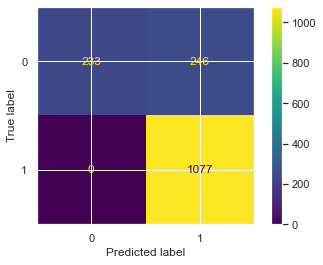

Confusion matrix for the test set
-----------------


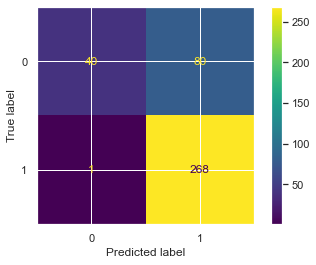

In [110]:
output_rf_bow_lemmas = text_classification(financial_df["lemmas"], y, CountVectorizer(), rf, cv=15, test_size=0.2, random_state=20, pipeline_flag=True)

##### Bag of Words - Ngrams

-----------------
The model score using K-fold cross validation (k=10) is 0.695 with a standard deviation of 0.008
-----------------
The performance metrics of the model


,train,test
error_metric,,
val_mean_score (k=10),0.694735,-
val_std (k=10),0.008003,-
accuracy,0.714653,0.701799
precision,0.708087,0.699739
recall,1.000000,0.996283


-----------------
Confusion matrix for the train set
-----------------


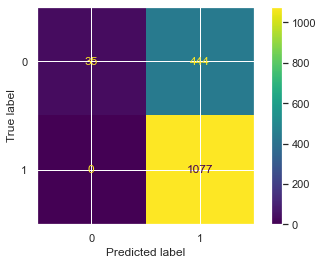

Confusion matrix for the test set
-----------------


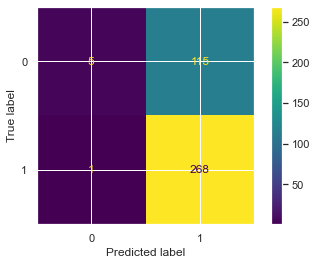

In [111]:
output_rf_bow_ngrams = text_classification(financial_df["ngrams"], y, CountVectorizer(), rf, cv=10, test_size=0.2, random_state=0, pipeline_flag=True)

The use of the n-grams does not improve the results. For the rest of the models lemmas will be used.

##### TF/IDF - Lemmas

-----------------
The model score using K-fold cross validation (k=10) is 0.79 with a standard deviation of 0.022
-----------------
The performance metrics of the model


,train,test
error_metric,,
val_mean_score (k=10),0.789859,-
val_std (k=10),0.022122,-
accuracy,0.846401,0.77892
precision,0.818389,0.763689
recall,1.000000,0.98513


-----------------
Confusion matrix for the train set
-----------------


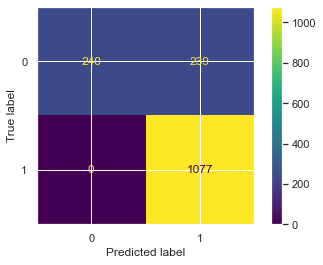

Confusion matrix for the test set
-----------------


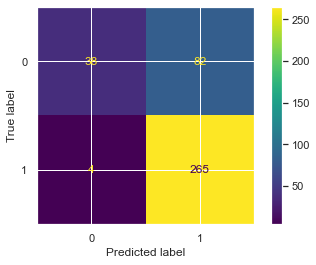

In [112]:
output_rf_tfidf_lemmas = text_classification(financial_df["lemmas"], y, TfidfVectorizer(), rf, cv=10, test_size=0.2, random_state=0, pipeline_flag=True)

The use of TF/IDF vectorization brings a slight improvement. The rest of the models will be calculated using TF/IDF.

#### Support Vector Machine

In [113]:
svm = LinearSVC(random_state=0, tol=1e-2, max_iter=5000)

##### TF_ITF - lemmas

-----------------
The model score using K-fold cross validation (k=10) is 0.847 with a standard deviation of 0.035
-----------------
The performance metrics of the model


,train,test
error_metric,,
val_mean_score (k=10),0.847047,-
val_std (k=10),0.034610,-
accuracy,0.975578,0.845758
precision,0.984157,0.859107
recall,0.980501,0.929368


-----------------
Confusion matrix for the train set
-----------------


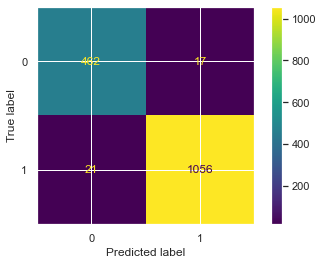

Confusion matrix for the test set
-----------------


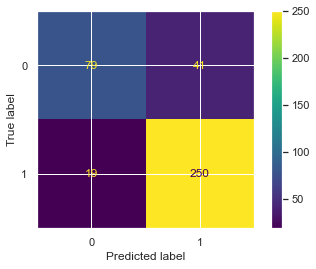

In [114]:
output_svm_tfif_lemmas = text_classification(financial_df["lemmas"], y, TfidfVectorizer(), svm, cv=10, test_size=0.2, random_state=0, pipeline_flag=True)

#### Naive Bayes

In [115]:
nb = MultinomialNB()

##### TF_ITF - lemmas

-----------------
The model score using K-fold cross validation (k=10) is 0.795 with a standard deviation of 0.024
-----------------
The performance metrics of the model


,train,test
error_metric,,
val_mean_score (k=10),0.794963,-
val_std (k=10),0.023778,-
accuracy,0.881748,0.786632
precision,0.855211,0.77193
recall,0.998143,0.981413


-----------------
Confusion matrix for the train set
-----------------


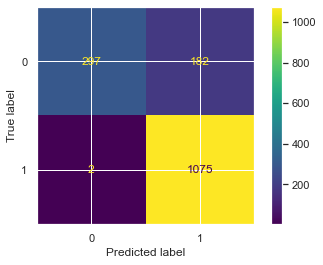

Confusion matrix for the test set
-----------------


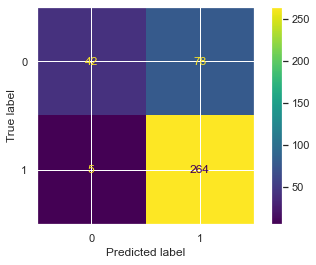

In [116]:
output_nb_tfif_lemmas = text_classification(financial_df["lemmas"], y, TfidfVectorizer(), nb, cv=10, test_size=0.2, random_state=0, pipeline_flag=True)

### Final Model - Randome Forest with TF_IDF and lemmas

Even though the SVM model gives better accuracy results, it is clearly overfitted. It is considered that the Random Forest Model gives the best balance between accuracy and power to generalize.

-----------------
The model score using K-fold cross validation (k=10) is 0.79 with a standard deviation of 0.022
-----------------
The performance metrics of the model


,train,test
error_metric,,
val_mean_score (k=10),0.789859,-
val_std (k=10),0.022122,-
accuracy,0.846401,0.77892
precision,0.818389,0.763689
recall,1.000000,0.98513


-----------------
Confusion matrix for the train set
-----------------


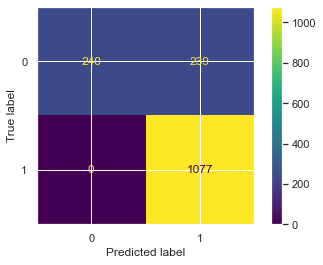

Confusion matrix for the test set
-----------------


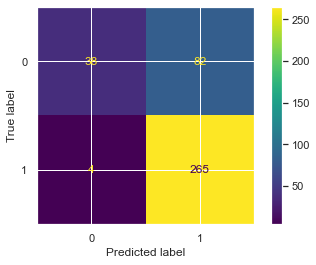

In [117]:
output_rf_tfidf_lemmas = text_classification(financial_df["lemmas"], y, TfidfVectorizer(), rf, cv=10, test_size=0.2, random_state=0, pipeline_flag=True)

# LSTM Neural Network - Transfer Learning

## Test/Train Split

In [118]:
financial_df = pd.read_csv("Data/csv/fin_lab_cleaned.csv", encoding = "ISO-8859-1")

In [119]:
train, test = train_test_split(financial_df, test_size=0.2, stratify=financial_df["sentiment"], random_state=0)

In [120]:
train["set"] = "train"
test["set"] = "test"

financial_df = (pd.concat([train, test], axis=0)
                .sample(frac=1)
                .reset_index(drop=True)              
               )
financial_df.head()

,text,sentiment,set
0,"With CapMan as a partner , we will be able to further develop our business and continue to focus on providing quality restaurant services for our customers , '' says Christopher Wynne , CEO of Papa John 's Russia .",positive,train
1,The acquisition of +_landsbanken Sverige in 2009 burdened the performance with EUR 3.0 mn .,negative,train
2,"Besides we have increased the share of meat in various sausages and are offering a number of new tastes in the grill products and shish kebabs segment , '' Paavel said .",positive,train
3,Net sales decreased to EUR 220.5 mn from EUR 470.0 mn in the corresponding period in 2009 .,negative,train
4,The company intends to raise production capacity in 2006 .,positive,train


## Storing the Dataset as Text Files

The user defined function build_folder() will be used to store the headlines as text files in a folder with the structure "Data/labelled/{set}/{sentiment}/{n_record}.txt"

In [121]:
build_folder(financial_df,1,0,2)

100%|██████████| 1945/1945 [00:00<00:00, 2355.94it/s]


## Building the Language Model (LM) with a Transfer Learning Approach

### Data Loader Object for the LM

DataLoaders is an object that stores two DataLoader objects, tran and set in this case.
The DataLoader objects are used to pass batches of text to the model (tokenized) and speed up the training process.

In [123]:
path = Path("C:/Users/user/GitHub/Sentiment_Analysis_on_Financial_News_Headlines/Data/labelled")

if not LM_Flag:

    get_text_path = partial(get_text_files, folders=['train', 'test'])

    dls_lm = (DataBlock(blocks=TextBlock.from_folder(path, is_lm=True),get_items=get_text_path, splitter=RandomSplitter(0.1))
                                        .dataloaders(path, path=path, bs=128, seq_len=80)
         )

Due to IPython and Windows limitation, python multiprocessing isn't available now.
So `n_workers` has to be changed to 0 to avoid getting stuck


In [124]:
# Saving/Loading the language model dls

if not LM_Flag:

    with open(f"Data/dls/dls_lm", "wb") as f:

        pickle.dump(dls_lm, f)

else:

    with open(f"Data/dls/dls_lm", "rb") as f:

        dls_lm = pickle.load(f)

Let us check the first three batches.

In [125]:
dls_lm.show_batch(max_n=3)

,text,text_
0,"xxbos xxmaj seppala 's revenue increased by 0.2 % to xxup eur10 .1 m. xxmaj in xxmaj finland , revenue went down by 2.4 % to xxup eur6 .8 m , while sales abroad rose by 6.2 % to xxup eur3 .3 m. xxmaj sales increased in all the xxmaj baltic countries as well as in xxmaj russia and xxmaj ukraine . xxbos xxup navteq has a xxunk lead in installed map data systems in xxmaj north xxmaj american xxunk","xxmaj seppala 's revenue increased by 0.2 % to xxup eur10 .1 m. xxmaj in xxmaj finland , revenue went down by 2.4 % to xxup eur6 .8 m , while sales abroad rose by 6.2 % to xxup eur3 .3 m. xxmaj sales increased in all the xxmaj baltic countries as well as in xxmaj russia and xxmaj ukraine . xxbos xxup navteq has a xxunk lead in installed map data systems in xxmaj north xxmaj american xxunk and"
1,"its net sales decreased to xxup eur xxunk mn in january - june 2009 from xxup eur xxunk mn in the corresponding period in 2008 . xxbos ( xxup adp xxmaj news ) xxmaj feb 9 , 2009 xxmaj finnish computer services company xxmaj xxunk xxmaj oyj ( xxup hel xxup xxunk ) said today its net loss narrowed to xxup eur xxunk , xxrep 3 0 ( xxup usd xxunk , xxrep 3 0 ) for 2008 from xxup","net sales decreased to xxup eur xxunk mn in january - june 2009 from xxup eur xxunk mn in the corresponding period in 2008 . xxbos ( xxup adp xxmaj news ) xxmaj feb 9 , 2009 xxmaj finnish computer services company xxmaj xxunk xxmaj oyj ( xxup hel xxup xxunk ) said today its net loss narrowed to xxup eur xxunk , xxrep 3 0 ( xxup usd xxunk , xxrep 3 0 ) for 2008 from xxup eur"
2,"to xxunk million liters . xxbos xxup adp xxmaj news xxmaj nov 13 , 2008 xxmaj finnish printed circuit board xxup xxunk maker xxmaj aspocomp xxmaj group xxmaj oyj xxup omx xxup acg1v said today that its net loss narrowed to xxup eur 2 million xxup usd 2.5 m in the first nine months of 2008 from xxup eur xxunk xxbos xxup adp xxmaj news xxmaj nov 6 , 2008 xxmaj finnish retail software developer xxmaj aldata xxmaj solution xxmaj","xxunk million liters . xxbos xxup adp xxmaj news xxmaj nov 13 , 2008 xxmaj finnish printed circuit board xxup xxunk maker xxmaj aspocomp xxmaj group xxmaj oyj xxup omx xxup acg1v said today that its net loss narrowed to xxup eur 2 million xxup usd 2.5 m in the first nine months of 2008 from xxup eur xxunk xxbos xxup adp xxmaj news xxmaj nov 6 , 2008 xxmaj finnish retail software developer xxmaj aldata xxmaj solution xxmaj oyj"


### Implementing the general language model pre-trained with Wikipedia articles

The first step in our transfer learning approach is to implement the pretrained model. This model is already available as part of fastAI library has been already trained using a dataset of thousand of WikiPedia articles. It is a language model and therefore is capable of generating reasonable coherent text in english.

In [126]:
learn = language_model_learner(dls_lm, AWD_LSTM, drop_mult=0.3, metrics=[accuracy, Perplexity()]).to_fp16()

Let us generate a text using the pretrained model.

In [127]:
text = ""
n_words = 100
prediction = learn.predict(text, n_words)

In [128]:
print(prediction)

dismissed the 2009 US East Bank Summit Financial Exchange Corporation business partnership record deal , when the money was sold to the New American Bank . If funds are raised , the Bank Finance Corporation would be providing net traffic and operate a long - term investment program for the Internet Supply Center . The US Bank Manager Group has been making a $ 25 million extension of its partnership with American Bank Corporation .


### Fine Tuning the General Model with the Financial Headlines corpus

The second step is to fine tune the general language model using the financial headlines dataset. The output is a financial language model that understands the particularities of the headlines and is able to generate coherent financial headlines.

#### First tuning - only the embeddings

In [129]:
# The pretrained model is frozen by default. Only the embeddings will be fine tuned at first

if not LM_Flag:
    
    learn.fit_one_cycle(1, 2e-2)

epoch,train_loss,valid_loss,accuracy,perplexity,time
0,4.307786,3.881172,0.305352,48.480999,00:41


#### Unfreezzing the model and fine-tuning

In [130]:
# Now we unfreeze the complete model and fine tune

if not LM_Flag:

    learn.unfreeze()
    learn.fit_one_cycle(5, 2e-3)


epoch,train_loss,valid_loss,accuracy,perplexity,time
0,3.477750,3.298984,0.375166,27.085094,01:08
1,3.168701,3.017914,0.417221,20.448584,01:07
2,2.947564,2.935822,0.422872,18.836977,01:07
3,2.768281,2.884722,0.433178,17.898596,01:11
4,2.646966,2.878086,0.433344,17.780210,01:12


In [131]:
# Saving/Loading the Financial Language Model

if not LM_Flag:

    finetuned = "LM_finetuned"
    learn.save(finetuned)

else:

    learn.load("LM_finetuned")

#### Saving the Encoder

In [132]:
# Saving the Financial Language Model Encoder

if not LM_Flag:

    encoder = "LM_encoder"
    learn.save_encoder(encoder)



#### Generating a Financial Heading

In [133]:
text = ""
n_words = 30
prediction = learn.predict(text, n_words, temperature=0.9)

In [134]:
print(prediction)

In 2010 , the company 's net profit in 2011 decreased to EUR 4.5 million excluding the corresponding period in 2007 . He will also expand


## Building the LSTM Classification Model with a Transfer Learning Approach

The final step in the transfer learning approach is to fine tune the financial language model to be a sentiment classifier. We do this using the labelled financial headlines dataset. In this step the model learns the pattern that make a headline postive or negative but without forgetting the language particularities of the headlines.

### Creating the Classifier DataLoaders

In [135]:
if not Classifier_Flag:

    dls_clas = DataBlock(blocks=(TextBlock.from_folder(path, vocab=dls_lm.vocab),CategoryBlock),
                        get_y = parent_label,
                        get_items=partial(get_text_files, folders=['train', 'test']),
                        splitter=GrandparentSplitter(valid_name='test')
                        ).dataloaders(path, path=path, bs=50, seq_len=72)

Due to IPython and Windows limitation, python multiprocessing isn't available now.
So `number_workers` is changed to 0 to avoid getting stuck


In [136]:
# Saving/Loading the classifier model dls

if not Classifier_Flag:

    with open(f"Data/dls/dls_clas", "wb") as f:

        pickle.dump(dls_clas, f)

else:

    with open(f"Data/dls/dls_clas", "rb") as f:

        dls_clas = pickle.load(f)

Let us check the first five batches.

In [137]:
dls_clas.show_batch(max_n=5)

,text,category
0,"xxbos xxup st . xxup petersburg , xxmaj oct 14 ( xxup prime - xxunk ) xxmaj finnish xxunk producer xxmaj nokian xxmaj tyres plans to invest about 50 million euros in the expansion of its xxunk plant in the city of xxmaj xxunk in xxmaj russia 's xxmaj xxunk xxmaj region in 2011 , the company 's xxmaj president xxmaj xxunk xxmaj xxunk told xxunk xxmaj thursday .",positive
1,"xxbos xxmaj finnish silicon wafers manufacturer xxmaj okmetic xxmaj oyj said on xxmaj june 29 , 2007 it signed an agreement with xxmaj nordea xxmaj bank xxmaj finland xxmaj plc , the local subsidiary of xxmaj swedish commercial bank xxmaj nordea xxmaj bank xxup ab , which will xxunk xxmaj okmetic 's syndicated bank facility which xxunk to some 20 mln euro ( $ xxunk mln ) .",positive
2,"xxbos xxmaj xxunk xxmaj third xxmaj xxunk xxmaj logistics xxmaj leader xxmaj xxunk for best - in - xxunk xxmaj technology , xxmaj xxunk xxmaj capabilities ; xxmaj leading xxmaj specialty xxmaj packaging xxmaj manufacturer xxmaj employs xxmaj complete xxunk xxmaj solution for xxmaj supply xxmaj chain xxmaj xxunk and xxmaj transportation xxmaj efficiency to xxmaj increase xxmaj service xxmaj levels and on - time xxmaj deliveries",positive
3,"xxbos xxup kauko - telko xxup ltd xxup press xxup release xxunk xxup at xxunk 1 ( 1 ) xxmaj telko xxmaj group ( kauko - telko ) is expanding its strategic partnership with xxup bp xxmaj industrial xxmaj xxunk xxmaj services ( xxup bp xxup xxunk ) by acquiring total xxunk of xxup bp 's xxmaj swedish retail company , xxunk - xxunk xxup ab .",positive
4,"xxbos xxunk - september 7 , 2010 - kemira xxunk xxmaj indian xxup xxunk with xxup ivrcl xxmaj finnish chemicals group xxmaj kemira ( xxup hel xxup xxunk ) on xxmaj tuesday announced it has xxunk a deal to form a joint venture in xxmaj india with local construction firm xxup ivrcl xxmaj infrastructure and xxmaj projects xxmaj ltd ( xxup xxunk xxunk xxunk ) .",positive


### Creating the Classifier Model

In [138]:
learn = text_classifier_learner(dls_clas, AWD_LSTM, drop_mult=0.5, metrics=accuracy).to_fp16()

In [139]:
# Let us load the encoder
encoder = "LM_encoder"
learn.load_encoder(encoder)

### Fine-Tuning the Classifier

In [140]:
if not Classifier_Flag:

    learn.fit_one_cycle(1, 2e-2)

epoch,train_loss,valid_loss,accuracy,time
0,0.574559,0.481072,0.755784,00:37


In [141]:
# Let us progressively unfrezze the model. First the last two layers.

if not Classifier_Flag:

    learn.freeze_to(-2)
    learn.fit_one_cycle(1, slice(1e-2/(2.6**4),1e-2))

epoch,train_loss,valid_loss,accuracy,time
0,0.490207,0.422261,0.776350,00:42


In [142]:
# A bit more

if not Classifier_Flag:

    learn.freeze_to(-3)
    learn.fit_one_cycle(1, slice(5e-3/(2.6**4),5e-3))

epoch,train_loss,valid_loss,accuracy,time
0,0.385743,0.351093,0.845758,01:07


In [143]:
# And the whole model

if not Classifier_Flag:

    learn.unfreeze()
    learn.fit_one_cycle(5, slice(1e-3/(2.6**4),1e-3))

epoch,train_loss,valid_loss,accuracy,time
0,0.290207,0.307019,0.863753,01:37
1,0.270236,0.319547,0.863753,01:35
2,0.226340,0.284355,0.881748,01:33
3,0.198159,0.291029,0.892031,01:37
4,0.171473,0.285701,0.897172,01:41


### Exporting/Loading the model

In [144]:
if not Classifier_Flag:

    learn.save("Inferer")

else:

    learn.load("Inferer")

## Interpreting the results

### Confusion Matrix

In [145]:
interp = ClassificationInterpretation.from_learner(learn)

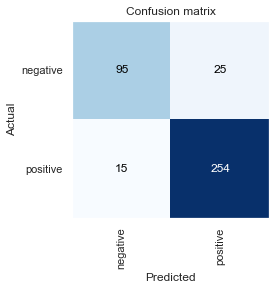

In [146]:
interp.plot_confusion_matrix()

### Predicting the Test Set

In [147]:
financial_df["prediction"] = financial_df["prob_pos"] = financial_df["prob_neg"] = financial_df["certainty"] = None
financial_df

,text,sentiment,set,prediction,prob_pos,prob_neg,certainty
0,"With CapMan as a partner , we will be able to further develop our business and continue to focus on providing quality restaurant services for our customers , '' says Christopher Wynne , CEO of Papa John 's Russia .",positive,train,None,None,None,None
1,The acquisition of +_landsbanken Sverige in 2009 burdened the performance with EUR 3.0 mn .,negative,train,None,None,None,None
2,"Besides we have increased the share of meat in various sausages and are offering a number of new tastes in the grill products and shish kebabs segment , '' Paavel said .",positive,train,None,None,None,None
3,Net sales decreased to EUR 220.5 mn from EUR 470.0 mn in the corresponding period in 2009 .,negative,train,None,None,None,None
4,The company intends to raise production capacity in 2006 .,positive,train,None,None,None,None
...,...,...,...,...,...,...,...
1940,"Pre-tax profit totaled EUR 397.4 mn , up from EUR 164.7 mn .",positive,train,None,None,None,None
1941,'' Those uncertainties cloud the long-term outlook . '',negative,train,None,None,None,None
1942,The ' buy ' recommendation was reiterated .,positive,train,None,None,None,None
1943,"Operating profit for the nine-month period increased from EUR3 .1 m and net sales increased from EUR61 .5 m , as compared to the corresponding period in 2007 .",positive,train,None,None,None,None


In [148]:
pred = learn.predict(financial_df["text"][0])
pred

('positive', TensorText(1), TensorText([1.7683e-04, 9.9982e-01]))

In [149]:
for row in tqdm(range(0, len(financial_df))):

  pred = learn.predict(financial_df["text"][row])
  financial_df["prediction"][row] = pred[0]
  financial_df["prob_pos"][row] = float(pred[2][1])
  financial_df["prob_neg"][row] = float(pred[2][0])
  financial_df["certainty"][row] = abs(financial_df["prob_pos"][row] - financial_df["prob_neg"][row])

  0%|          | 0/1945 [00:00<?, ?it/s]

  0%|          | 1/1945 [00:00<07:11,  4.50it/s]

  0%|          | 2/1945 [00:00<05:44,  5.64it/s]

  0%|          | 3/1945 [00:00<06:01,  5.37it/s]

  0%|          | 4/1945 [00:00<05:30,  5.87it/s]

  0%|          | 5/1945 [00:00<04:54,  6.60it/s]

  0%|          | 6/1945 [00:01<05:22,  6.02it/s]

  0%|          | 7/1945 [00:01<05:17,  6.10it/s]

  0%|          | 8/1945 [00:01<04:58,  6.48it/s]

  0%|          | 9/1945 [00:01<04:49,  6.68it/s]

  1%|          | 10/1945 [00:01<04:52,  6.61it/s]

  1%|          | 11/1945 [00:01<04:54,  6.57it/s]

  1%|          | 12/1945 [00:01<04:59,  6.46it/s]

  1%|          | 13/1945 [00:02<05:20,  6.02it/s]

  1%|          | 14/1945 [00:02<05:13,  6.16it/s]

  1%|          | 15/1945 [00:02<05:51,  5.49it/s]

  1%|          | 16/1945 [00:02<05:56,  5.41it/s]

  1%|          | 17/1945 [00:02<05:33,  5.78it/s]

  1%|          | 18/1945 [00:02<05:11,  6.19it/s]

  1%|          | 19/1945 [00:03<04:53,  6.56it/s]

  1%|          | 20/1945 [00:03<05:21,  5.99it/s]

  1%|          | 21/1945 [00:03<04:59,  6.42it/s]

  1%|          | 22/1945 [00:03<05:00,  6.40it/s]

  1%|          | 23/1945 [00:03<05:10,  6.18it/s]

  1%|          | 24/1945 [00:03<05:12,  6.15it/s]

  1%|▏         | 25/1945 [00:04<05:03,  6.33it/s]

  1%|▏         | 26/1945 [00:04<05:47,  5.52it/s]

  1%|▏         | 27/1945 [00:04<05:35,  5.71it/s]

  1%|▏         | 28/1945 [00:04<05:12,  6.13it/s]

  1%|▏         | 29/1945 [00:04<05:11,  6.15it/s]

  2%|▏         | 30/1945 [00:04<05:06,  6.26it/s]

  2%|▏         | 31/1945 [00:05<05:42,  5.58it/s]

  2%|▏         | 32/1945 [00:05<05:29,  5.80it/s]

  2%|▏         | 33/1945 [00:05<04:58,  6.41it/s]

  2%|▏         | 34/1945 [00:05<04:32,  7.02it/s]

  2%|▏         | 35/1945 [00:05<04:29,  7.09it/s]

  2%|▏         | 36/1945 [00:05<04:32,  6.99it/s]

  2%|▏         | 37/1945 [00:05<04:32,  7.01it/s]

  2%|▏         | 38/1945 [00:06<04:37,  6.87it/s]

  2%|▏         | 39/1945 [00:06<05:00,  6.35it/s]

  2%|▏         | 40/1945 [00:06<04:47,  6.62it/s]

  2%|▏         | 41/1945 [00:06<04:47,  6.62it/s]

  2%|▏         | 42/1945 [00:06<04:36,  6.88it/s]

  2%|▏         | 43/1945 [00:06<05:15,  6.02it/s]

  2%|▏         | 44/1945 [00:07<04:39,  6.80it/s]

  2%|▏         | 45/1945 [00:07<04:30,  7.04it/s]

  2%|▏         | 46/1945 [00:07<04:29,  7.04it/s]

  2%|▏         | 47/1945 [00:07<04:28,  7.07it/s]

  2%|▏         | 48/1945 [00:07<04:51,  6.51it/s]

  3%|▎         | 49/1945 [00:07<05:15,  6.02it/s]

  3%|▎         | 50/1945 [00:08<05:28,  5.77it/s]

  3%|▎         | 51/1945 [00:08<05:05,  6.20it/s]

  3%|▎         | 52/1945 [00:08<05:48,  5.43it/s]

  3%|▎         | 53/1945 [00:08<05:06,  6.17it/s]

  3%|▎         | 54/1945 [00:08<04:52,  6.48it/s]

  3%|▎         | 55/1945 [00:08<04:28,  7.05it/s]

  3%|▎         | 56/1945 [00:08<04:41,  6.70it/s]

  3%|▎         | 57/1945 [00:09<04:53,  6.44it/s]

  3%|▎         | 58/1945 [00:09<05:15,  5.98it/s]

  3%|▎         | 59/1945 [00:09<04:42,  6.67it/s]

  3%|▎         | 60/1945 [00:09<04:59,  6.29it/s]

  3%|▎         | 61/1945 [00:09<04:48,  6.52it/s]

  3%|▎         | 62/1945 [00:09<05:09,  6.09it/s]

  3%|▎         | 63/1945 [00:10<04:47,  6.54it/s]

  3%|▎         | 64/1945 [00:10<04:53,  6.40it/s]

  3%|▎         | 65/1945 [00:10<04:27,  7.03it/s]

  3%|▎         | 66/1945 [00:10<04:10,  7.51it/s]

  3%|▎         | 67/1945 [00:10<04:17,  7.30it/s]

  3%|▎         | 68/1945 [00:10<04:06,  7.60it/s]

  4%|▎         | 69/1945 [00:10<04:26,  7.03it/s]

  4%|▎         | 70/1945 [00:11<04:39,  6.71it/s]

  4%|▎         | 71/1945 [00:11<04:35,  6.80it/s]

  4%|▎         | 72/1945 [00:11<04:46,  6.54it/s]

  4%|▍         | 73/1945 [00:11<04:52,  6.40it/s]

  4%|▍         | 74/1945 [00:11<04:29,  6.93it/s]

  4%|▍         | 75/1945 [00:11<05:27,  5.71it/s]

  4%|▍         | 76/1945 [00:11<04:53,  6.37it/s]

  4%|▍         | 77/1945 [00:12<04:44,  6.56it/s]

  4%|▍         | 78/1945 [00:12<04:22,  7.11it/s]

  4%|▍         | 79/1945 [00:12<04:26,  7.00it/s]

  4%|▍         | 80/1945 [00:12<04:10,  7.46it/s]

  4%|▍         | 81/1945 [00:12<04:44,  6.55it/s]

  4%|▍         | 82/1945 [00:12<04:35,  6.76it/s]

  4%|▍         | 83/1945 [00:12<04:18,  7.19it/s]

  4%|▍         | 84/1945 [00:13<04:20,  7.16it/s]

  4%|▍         | 85/1945 [00:13<04:43,  6.56it/s]

  4%|▍         | 86/1945 [00:13<04:20,  7.13it/s]

  4%|▍         | 87/1945 [00:13<04:04,  7.61it/s]

  5%|▍         | 88/1945 [00:13<04:13,  7.32it/s]

  5%|▍         | 89/1945 [00:13<04:31,  6.83it/s]

  5%|▍         | 90/1945 [00:13<04:48,  6.44it/s]

  5%|▍         | 91/1945 [00:14<04:55,  6.28it/s]

  5%|▍         | 92/1945 [00:14<04:38,  6.65it/s]

  5%|▍         | 93/1945 [00:14<04:39,  6.63it/s]

  5%|▍         | 94/1945 [00:14<04:39,  6.62it/s]

  5%|▍         | 95/1945 [00:14<04:48,  6.42it/s]

  5%|▍         | 96/1945 [00:14<04:42,  6.54it/s]

  5%|▍         | 97/1945 [00:15<04:31,  6.79it/s]

  5%|▌         | 98/1945 [00:15<04:22,  7.05it/s]

  5%|▌         | 99/1945 [00:15<04:15,  7.21it/s]

  5%|▌         | 100/1945 [00:15<04:45,  6.45it/s]

  5%|▌         | 101/1945 [00:15<04:25,  6.94it/s]

  5%|▌         | 102/1945 [00:15<04:38,  6.61it/s]

  5%|▌         | 103/1945 [00:15<04:45,  6.46it/s]

  5%|▌         | 104/1945 [00:16<04:45,  6.45it/s]

  5%|▌         | 105/1945 [00:16<04:55,  6.22it/s]

  5%|▌         | 106/1945 [00:16<05:41,  5.39it/s]

  6%|▌         | 107/1945 [00:16<05:22,  5.70it/s]

  6%|▌         | 108/1945 [00:16<05:30,  5.56it/s]

  6%|▌         | 109/1945 [00:16<05:21,  5.72it/s]

  6%|▌         | 110/1945 [00:17<05:21,  5.70it/s]

  6%|▌         | 111/1945 [00:17<05:15,  5.80it/s]

  6%|▌         | 112/1945 [00:17<05:23,  5.66it/s]

  6%|▌         | 113/1945 [00:17<05:01,  6.08it/s]

  6%|▌         | 114/1945 [00:17<05:30,  5.54it/s]

  6%|▌         | 115/1945 [00:18<05:27,  5.59it/s]

  6%|▌         | 116/1945 [00:18<05:32,  5.49it/s]

  6%|▌         | 117/1945 [00:18<05:06,  5.97it/s]

  6%|▌         | 118/1945 [00:18<05:31,  5.52it/s]

  6%|▌         | 119/1945 [00:18<05:53,  5.17it/s]

  6%|▌         | 120/1945 [00:18<05:49,  5.22it/s]

  6%|▌         | 121/1945 [00:19<05:40,  5.35it/s]

  6%|▋         | 122/1945 [00:19<05:33,  5.47it/s]

  6%|▋         | 123/1945 [00:19<05:03,  6.00it/s]

  6%|▋         | 124/1945 [00:19<05:39,  5.36it/s]

  6%|▋         | 125/1945 [00:19<05:19,  5.69it/s]

  6%|▋         | 126/1945 [00:20<05:06,  5.93it/s]

  7%|▋         | 127/1945 [00:20<04:53,  6.18it/s]

  7%|▋         | 128/1945 [00:20<05:09,  5.87it/s]

  7%|▋         | 129/1945 [00:20<05:06,  5.92it/s]

  7%|▋         | 130/1945 [00:20<04:38,  6.52it/s]

  7%|▋         | 131/1945 [00:20<04:21,  6.95it/s]

  7%|▋         | 132/1945 [00:20<04:55,  6.14it/s]

  7%|▋         | 133/1945 [00:21<05:26,  5.56it/s]

  7%|▋         | 134/1945 [00:21<05:12,  5.80it/s]

  7%|▋         | 135/1945 [00:21<04:45,  6.33it/s]

  7%|▋         | 136/1945 [00:21<05:10,  5.83it/s]

  7%|▋         | 137/1945 [00:21<04:53,  6.15it/s]

  7%|▋         | 138/1945 [00:21<04:32,  6.63it/s]

  7%|▋         | 139/1945 [00:22<04:47,  6.28it/s]

  7%|▋         | 140/1945 [00:22<04:52,  6.18it/s]

  7%|▋         | 141/1945 [00:22<04:49,  6.22it/s]

  7%|▋         | 142/1945 [00:22<04:45,  6.31it/s]

  7%|▋         | 143/1945 [00:22<04:59,  6.01it/s]

  7%|▋         | 144/1945 [00:22<04:43,  6.36it/s]

  7%|▋         | 145/1945 [00:23<04:52,  6.16it/s]

  8%|▊         | 146/1945 [00:23<04:33,  6.58it/s]

  8%|▊         | 147/1945 [00:23<04:43,  6.34it/s]

  8%|▊         | 148/1945 [00:23<04:35,  6.53it/s]

  8%|▊         | 149/1945 [00:23<05:05,  5.87it/s]

  8%|▊         | 150/1945 [00:23<04:55,  6.07it/s]

  8%|▊         | 151/1945 [00:24<04:39,  6.41it/s]

  8%|▊         | 152/1945 [00:24<04:54,  6.10it/s]

  8%|▊         | 153/1945 [00:24<04:45,  6.27it/s]

  8%|▊         | 154/1945 [00:24<04:59,  5.98it/s]

  8%|▊         | 155/1945 [00:24<04:48,  6.21it/s]

  8%|▊         | 156/1945 [00:24<04:34,  6.52it/s]

  8%|▊         | 157/1945 [00:24<04:42,  6.32it/s]

  8%|▊         | 158/1945 [00:25<04:14,  7.02it/s]

  8%|▊         | 159/1945 [00:25<04:07,  7.21it/s]

  8%|▊         | 160/1945 [00:25<03:59,  7.45it/s]

  8%|▊         | 161/1945 [00:25<04:17,  6.92it/s]

  8%|▊         | 162/1945 [00:25<04:54,  6.06it/s]

  8%|▊         | 163/1945 [00:25<05:05,  5.83it/s]

  8%|▊         | 164/1945 [00:26<05:07,  5.79it/s]

  8%|▊         | 165/1945 [00:26<05:17,  5.61it/s]

  9%|▊         | 166/1945 [00:26<04:50,  6.12it/s]

  9%|▊         | 167/1945 [00:26<04:35,  6.46it/s]

  9%|▊         | 168/1945 [00:26<05:11,  5.71it/s]

  9%|▊         | 169/1945 [00:26<04:59,  5.92it/s]

  9%|▊         | 170/1945 [00:27<04:46,  6.20it/s]

  9%|▉         | 171/1945 [00:27<04:31,  6.54it/s]

  9%|▉         | 172/1945 [00:27<04:38,  6.37it/s]

  9%|▉         | 173/1945 [00:27<05:02,  5.86it/s]

  9%|▉         | 174/1945 [00:27<05:02,  5.86it/s]

  9%|▉         | 175/1945 [00:27<05:16,  5.59it/s]

  9%|▉         | 176/1945 [00:28<05:10,  5.70it/s]

  9%|▉         | 177/1945 [00:28<04:55,  5.98it/s]

  9%|▉         | 178/1945 [00:28<05:09,  5.70it/s]

  9%|▉         | 179/1945 [00:28<05:02,  5.84it/s]

  9%|▉         | 180/1945 [00:28<05:03,  5.82it/s]

  9%|▉         | 181/1945 [00:28<04:28,  6.57it/s]

  9%|▉         | 182/1945 [00:29<04:21,  6.74it/s]

  9%|▉         | 183/1945 [00:29<04:18,  6.81it/s]

  9%|▉         | 184/1945 [00:29<04:32,  6.46it/s]

 10%|▉         | 185/1945 [00:29<04:26,  6.60it/s]

 10%|▉         | 186/1945 [00:29<04:17,  6.84it/s]

 10%|▉         | 187/1945 [00:29<04:20,  6.76it/s]

 10%|▉         | 188/1945 [00:29<04:10,  7.01it/s]

 10%|▉         | 189/1945 [00:30<04:04,  7.17it/s]

 10%|▉         | 190/1945 [00:30<04:32,  6.44it/s]

 10%|▉         | 191/1945 [00:30<04:26,  6.58it/s]

 10%|▉         | 192/1945 [00:30<05:09,  5.66it/s]

 10%|▉         | 193/1945 [00:30<05:06,  5.71it/s]

 10%|▉         | 194/1945 [00:30<05:19,  5.48it/s]

 10%|█         | 195/1945 [00:31<05:35,  5.22it/s]

 10%|█         | 196/1945 [00:31<05:33,  5.25it/s]

 10%|█         | 197/1945 [00:31<05:29,  5.31it/s]

 10%|█         | 198/1945 [00:31<05:04,  5.73it/s]

 10%|█         | 199/1945 [00:31<04:44,  6.14it/s]

 10%|█         | 200/1945 [00:31<04:24,  6.59it/s]

 10%|█         | 201/1945 [00:32<04:18,  6.75it/s]

 10%|█         | 202/1945 [00:32<04:39,  6.24it/s]

 10%|█         | 203/1945 [00:32<04:44,  6.13it/s]

 10%|█         | 204/1945 [00:32<04:34,  6.33it/s]

 11%|█         | 205/1945 [00:32<04:21,  6.66it/s]

 11%|█         | 206/1945 [00:32<04:45,  6.10it/s]

 11%|█         | 207/1945 [00:33<04:52,  5.94it/s]

 11%|█         | 208/1945 [00:33<04:55,  5.88it/s]

 11%|█         | 209/1945 [00:33<05:00,  5.78it/s]

 11%|█         | 210/1945 [00:33<04:40,  6.20it/s]

 11%|█         | 211/1945 [00:33<04:36,  6.28it/s]

 11%|█         | 212/1945 [00:33<04:48,  6.01it/s]

 11%|█         | 213/1945 [00:34<04:35,  6.29it/s]

 11%|█         | 214/1945 [00:34<04:22,  6.60it/s]

 11%|█         | 215/1945 [00:34<05:00,  5.76it/s]

 11%|█         | 216/1945 [00:34<04:41,  6.13it/s]

 11%|█         | 217/1945 [00:34<05:10,  5.57it/s]

 11%|█         | 218/1945 [00:34<05:00,  5.74it/s]

 11%|█▏        | 219/1945 [00:35<04:44,  6.06it/s]

 11%|█▏        | 220/1945 [00:35<05:11,  5.54it/s]

 11%|█▏        | 221/1945 [00:35<04:53,  5.86it/s]

 11%|█▏        | 222/1945 [00:35<04:55,  5.83it/s]

 11%|█▏        | 223/1945 [00:35<05:09,  5.56it/s]

 12%|█▏        | 224/1945 [00:35<04:46,  6.02it/s]

 12%|█▏        | 225/1945 [00:36<04:26,  6.44it/s]

 12%|█▏        | 226/1945 [00:36<04:45,  6.01it/s]

 12%|█▏        | 227/1945 [00:36<05:12,  5.51it/s]

 12%|█▏        | 228/1945 [00:36<05:23,  5.30it/s]

 12%|█▏        | 229/1945 [00:36<04:57,  5.76it/s]

 12%|█▏        | 230/1945 [00:36<04:33,  6.26it/s]

 12%|█▏        | 231/1945 [00:37<04:34,  6.24it/s]

 12%|█▏        | 232/1945 [00:37<04:49,  5.91it/s]

 12%|█▏        | 233/1945 [00:37<04:31,  6.30it/s]

 12%|█▏        | 234/1945 [00:37<04:26,  6.41it/s]

 12%|█▏        | 235/1945 [00:37<04:20,  6.56it/s]

 12%|█▏        | 236/1945 [00:37<04:14,  6.71it/s]

 12%|█▏        | 237/1945 [00:38<04:03,  7.01it/s]

 12%|█▏        | 238/1945 [00:38<04:21,  6.53it/s]

 12%|█▏        | 239/1945 [00:38<04:31,  6.29it/s]

 12%|█▏        | 240/1945 [00:38<04:34,  6.22it/s]

 12%|█▏        | 241/1945 [00:38<05:20,  5.31it/s]

 12%|█▏        | 242/1945 [00:38<05:13,  5.44it/s]

 12%|█▏        | 243/1945 [00:39<04:47,  5.91it/s]

 13%|█▎        | 244/1945 [00:39<04:34,  6.19it/s]

 13%|█▎        | 245/1945 [00:39<04:29,  6.31it/s]

 13%|█▎        | 246/1945 [00:39<04:11,  6.76it/s]

 13%|█▎        | 247/1945 [00:39<04:14,  6.68it/s]

 13%|█▎        | 248/1945 [00:39<04:02,  7.00it/s]

 13%|█▎        | 249/1945 [00:39<03:49,  7.40it/s]

 13%|█▎        | 250/1945 [00:40<03:49,  7.38it/s]

 13%|█▎        | 251/1945 [00:40<03:54,  7.23it/s]

 13%|█▎        | 252/1945 [00:40<04:04,  6.91it/s]

 13%|█▎        | 253/1945 [00:40<04:09,  6.77it/s]

 13%|█▎        | 254/1945 [00:40<04:15,  6.61it/s]

 13%|█▎        | 255/1945 [00:40<04:28,  6.29it/s]

 13%|█▎        | 256/1945 [00:40<04:04,  6.91it/s]

 13%|█▎        | 257/1945 [00:41<04:06,  6.84it/s]

 13%|█▎        | 258/1945 [00:41<04:00,  7.01it/s]

 13%|█▎        | 259/1945 [00:41<04:40,  6.01it/s]

 13%|█▎        | 260/1945 [00:41<04:30,  6.23it/s]

 13%|█▎        | 261/1945 [00:41<04:50,  5.81it/s]

 13%|█▎        | 262/1945 [00:42<04:55,  5.70it/s]

 14%|█▎        | 263/1945 [00:42<04:37,  6.07it/s]

 14%|█▎        | 264/1945 [00:42<04:51,  5.77it/s]

 14%|█▎        | 265/1945 [00:42<04:25,  6.32it/s]

 14%|█▎        | 266/1945 [00:42<04:13,  6.63it/s]

 14%|█▎        | 267/1945 [00:42<04:11,  6.68it/s]

 14%|█▍        | 268/1945 [00:42<03:47,  7.36it/s]

 14%|█▍        | 269/1945 [00:42<03:51,  7.25it/s]

 14%|█▍        | 270/1945 [00:43<04:08,  6.73it/s]

 14%|█▍        | 271/1945 [00:43<04:41,  5.94it/s]

 14%|█▍        | 272/1945 [00:43<05:17,  5.27it/s]

 14%|█▍        | 273/1945 [00:43<05:12,  5.35it/s]

 14%|█▍        | 274/1945 [00:43<04:58,  5.59it/s]

 14%|█▍        | 275/1945 [00:44<04:54,  5.67it/s]

 14%|█▍        | 276/1945 [00:44<05:12,  5.34it/s]

 14%|█▍        | 277/1945 [00:44<05:02,  5.51it/s]

 14%|█▍        | 278/1945 [00:44<04:28,  6.20it/s]

 14%|█▍        | 279/1945 [00:44<04:14,  6.54it/s]

 14%|█▍        | 280/1945 [00:44<04:06,  6.75it/s]

 14%|█▍        | 281/1945 [00:45<04:34,  6.06it/s]

 14%|█▍        | 282/1945 [00:45<04:20,  6.38it/s]

 15%|█▍        | 283/1945 [00:45<04:01,  6.88it/s]

 15%|█▍        | 284/1945 [00:45<04:10,  6.63it/s]

 15%|█▍        | 285/1945 [00:45<04:07,  6.70it/s]

 15%|█▍        | 286/1945 [00:45<04:36,  6.01it/s]

 15%|█▍        | 287/1945 [00:46<04:34,  6.05it/s]

 15%|█▍        | 288/1945 [00:46<04:56,  5.59it/s]

 15%|█▍        | 289/1945 [00:46<05:18,  5.20it/s]

 15%|█▍        | 290/1945 [00:46<04:54,  5.63it/s]

 15%|█▍        | 291/1945 [00:46<04:42,  5.85it/s]

 15%|█▌        | 292/1945 [00:46<04:58,  5.53it/s]

 15%|█▌        | 293/1945 [00:47<04:32,  6.05it/s]

 15%|█▌        | 294/1945 [00:47<04:49,  5.70it/s]

 15%|█▌        | 295/1945 [00:47<04:32,  6.06it/s]

 15%|█▌        | 296/1945 [00:47<04:13,  6.50it/s]

 15%|█▌        | 297/1945 [00:47<04:26,  6.18it/s]

 15%|█▌        | 298/1945 [00:47<04:18,  6.36it/s]

 15%|█▌        | 299/1945 [00:48<04:10,  6.57it/s]

 15%|█▌        | 300/1945 [00:48<03:58,  6.90it/s]

 15%|█▌        | 301/1945 [00:48<04:09,  6.58it/s]

 16%|█▌        | 302/1945 [00:48<04:15,  6.42it/s]

 16%|█▌        | 303/1945 [00:48<04:11,  6.53it/s]

 16%|█▌        | 304/1945 [00:48<04:23,  6.24it/s]

 16%|█▌        | 305/1945 [00:48<04:07,  6.64it/s]

 16%|█▌        | 306/1945 [00:49<03:59,  6.83it/s]

 16%|█▌        | 307/1945 [00:49<04:02,  6.76it/s]

 16%|█▌        | 308/1945 [00:49<03:54,  6.97it/s]

 16%|█▌        | 309/1945 [00:49<03:44,  7.28it/s]

 16%|█▌        | 310/1945 [00:49<04:05,  6.66it/s]

 16%|█▌        | 311/1945 [00:49<04:18,  6.33it/s]

 16%|█▌        | 312/1945 [00:49<04:00,  6.79it/s]

 16%|█▌        | 313/1945 [00:50<03:47,  7.19it/s]

 16%|█▌        | 314/1945 [00:50<04:05,  6.64it/s]

 16%|█▌        | 315/1945 [00:50<04:36,  5.90it/s]

 16%|█▌        | 316/1945 [00:50<04:06,  6.61it/s]

 16%|█▋        | 317/1945 [00:50<04:44,  5.72it/s]

 16%|█▋        | 318/1945 [00:51<04:55,  5.50it/s]

 16%|█▋        | 319/1945 [00:51<04:42,  5.75it/s]

 16%|█▋        | 320/1945 [00:51<04:40,  5.79it/s]

 17%|█▋        | 321/1945 [00:51<04:28,  6.05it/s]

 17%|█▋        | 322/1945 [00:51<04:28,  6.04it/s]

 17%|█▋        | 323/1945 [00:51<04:22,  6.17it/s]

 17%|█▋        | 324/1945 [00:51<04:18,  6.28it/s]

 17%|█▋        | 325/1945 [00:52<04:00,  6.73it/s]

 17%|█▋        | 326/1945 [00:52<04:10,  6.47it/s]

 17%|█▋        | 327/1945 [00:52<04:24,  6.13it/s]

 17%|█▋        | 328/1945 [00:52<04:29,  6.00it/s]

 17%|█▋        | 329/1945 [00:52<04:11,  6.42it/s]

 17%|█▋        | 330/1945 [00:52<04:18,  6.25it/s]

 17%|█▋        | 331/1945 [00:53<04:14,  6.33it/s]

 17%|█▋        | 332/1945 [00:53<04:05,  6.57it/s]

 17%|█▋        | 333/1945 [00:53<04:01,  6.68it/s]

 17%|█▋        | 334/1945 [00:53<03:55,  6.83it/s]

 17%|█▋        | 335/1945 [00:53<04:04,  6.59it/s]

 17%|█▋        | 336/1945 [00:53<03:56,  6.80it/s]

 17%|█▋        | 337/1945 [00:54<04:37,  5.80it/s]

 17%|█▋        | 338/1945 [00:54<05:04,  5.28it/s]

 17%|█▋        | 339/1945 [00:54<04:36,  5.81it/s]

 17%|█▋        | 340/1945 [00:54<04:20,  6.16it/s]

 18%|█▊        | 341/1945 [00:54<04:09,  6.44it/s]

 18%|█▊        | 342/1945 [00:54<04:02,  6.60it/s]

 18%|█▊        | 343/1945 [00:54<04:12,  6.33it/s]

 18%|█▊        | 344/1945 [00:55<04:44,  5.62it/s]

 18%|█▊        | 345/1945 [00:55<04:19,  6.17it/s]

 18%|█▊        | 346/1945 [00:55<04:05,  6.52it/s]

 18%|█▊        | 347/1945 [00:55<03:51,  6.90it/s]

 18%|█▊        | 348/1945 [00:55<04:00,  6.64it/s]

 18%|█▊        | 349/1945 [00:55<04:27,  5.96it/s]

 18%|█▊        | 350/1945 [00:56<03:59,  6.65it/s]

 18%|█▊        | 351/1945 [00:56<03:56,  6.74it/s]

 18%|█▊        | 352/1945 [00:56<03:39,  7.27it/s]

 18%|█▊        | 353/1945 [00:56<03:56,  6.72it/s]

 18%|█▊        | 354/1945 [00:56<03:56,  6.74it/s]

 18%|█▊        | 355/1945 [00:56<03:55,  6.76it/s]

 18%|█▊        | 356/1945 [00:56<04:14,  6.24it/s]

 18%|█▊        | 357/1945 [00:57<04:28,  5.92it/s]

 18%|█▊        | 358/1945 [00:57<04:37,  5.72it/s]

 18%|█▊        | 359/1945 [00:57<04:19,  6.10it/s]

 19%|█▊        | 360/1945 [00:57<04:09,  6.36it/s]

 19%|█▊        | 361/1945 [00:57<05:04,  5.20it/s]

 19%|█▊        | 362/1945 [00:58<04:28,  5.89it/s]

 19%|█▊        | 363/1945 [00:58<04:02,  6.52it/s]

 19%|█▊        | 364/1945 [00:58<04:09,  6.33it/s]

 19%|█▉        | 365/1945 [00:58<03:55,  6.70it/s]

 19%|█▉        | 366/1945 [00:58<03:49,  6.87it/s]

 19%|█▉        | 367/1945 [00:58<04:08,  6.35it/s]

 19%|█▉        | 368/1945 [00:58<04:17,  6.13it/s]

 19%|█▉        | 369/1945 [00:59<04:21,  6.03it/s]

 19%|█▉        | 370/1945 [00:59<04:07,  6.36it/s]

 19%|█▉        | 371/1945 [00:59<04:22,  6.00it/s]

 19%|█▉        | 372/1945 [00:59<04:19,  6.05it/s]

 19%|█▉        | 373/1945 [00:59<04:26,  5.90it/s]

 19%|█▉        | 374/1945 [00:59<04:09,  6.31it/s]

 19%|█▉        | 375/1945 [01:00<04:26,  5.89it/s]

 19%|█▉        | 376/1945 [01:00<04:26,  5.88it/s]

 19%|█▉        | 377/1945 [01:00<04:09,  6.29it/s]

 19%|█▉        | 378/1945 [01:00<03:57,  6.59it/s]

 19%|█▉        | 379/1945 [01:00<03:55,  6.65it/s]

 20%|█▉        | 380/1945 [01:00<03:36,  7.21it/s]

 20%|█▉        | 381/1945 [01:00<03:25,  7.59it/s]

 20%|█▉        | 382/1945 [01:01<03:30,  7.44it/s]

 20%|█▉        | 383/1945 [01:01<04:00,  6.49it/s]

 20%|█▉        | 384/1945 [01:01<04:25,  5.88it/s]

 20%|█▉        | 385/1945 [01:01<04:22,  5.94it/s]

 20%|█▉        | 386/1945 [01:01<04:02,  6.43it/s]

 20%|█▉        | 387/1945 [01:01<03:46,  6.88it/s]

 20%|█▉        | 388/1945 [01:02<04:04,  6.36it/s]

 20%|██        | 389/1945 [01:02<04:57,  5.24it/s]

 20%|██        | 390/1945 [01:02<04:50,  5.35it/s]

 20%|██        | 391/1945 [01:02<04:34,  5.65it/s]

 20%|██        | 392/1945 [01:02<04:38,  5.57it/s]

 20%|██        | 393/1945 [01:03<04:55,  5.26it/s]

 20%|██        | 394/1945 [01:03<05:03,  5.11it/s]

 20%|██        | 395/1945 [01:03<04:51,  5.31it/s]

 20%|██        | 396/1945 [01:03<04:42,  5.49it/s]

 20%|██        | 397/1945 [01:03<04:18,  5.99it/s]

 20%|██        | 398/1945 [01:03<04:25,  5.84it/s]

 21%|██        | 399/1945 [01:04<04:09,  6.19it/s]

 21%|██        | 400/1945 [01:04<04:13,  6.09it/s]

 21%|██        | 401/1945 [01:04<04:16,  6.02it/s]

 21%|██        | 402/1945 [01:04<04:00,  6.41it/s]

 21%|██        | 403/1945 [01:04<04:05,  6.29it/s]

 21%|██        | 404/1945 [01:04<03:58,  6.47it/s]

 21%|██        | 405/1945 [01:04<03:55,  6.54it/s]

 21%|██        | 406/1945 [01:05<04:06,  6.25it/s]

 21%|██        | 407/1945 [01:05<04:00,  6.40it/s]

 21%|██        | 408/1945 [01:05<04:15,  6.02it/s]

 21%|██        | 409/1945 [01:05<04:05,  6.27it/s]

 21%|██        | 410/1945 [01:05<04:03,  6.31it/s]

 21%|██        | 411/1945 [01:05<03:58,  6.42it/s]

 21%|██        | 412/1945 [01:06<03:56,  6.48it/s]

 21%|██        | 413/1945 [01:06<04:01,  6.35it/s]

 21%|██▏       | 414/1945 [01:06<04:15,  5.99it/s]

 21%|██▏       | 415/1945 [01:06<03:55,  6.51it/s]

 21%|██▏       | 416/1945 [01:06<03:51,  6.60it/s]

 21%|██▏       | 417/1945 [01:06<03:47,  6.71it/s]

 21%|██▏       | 418/1945 [01:07<04:53,  5.21it/s]

 22%|██▏       | 419/1945 [01:07<04:42,  5.40it/s]

 22%|██▏       | 420/1945 [01:07<04:40,  5.44it/s]

 22%|██▏       | 421/1945 [01:07<04:21,  5.84it/s]

 22%|██▏       | 422/1945 [01:07<04:13,  6.00it/s]

 22%|██▏       | 423/1945 [01:07<04:17,  5.90it/s]

 22%|██▏       | 424/1945 [01:08<04:06,  6.18it/s]

 22%|██▏       | 425/1945 [01:08<04:23,  5.77it/s]

 22%|██▏       | 426/1945 [01:08<04:34,  5.54it/s]

 22%|██▏       | 427/1945 [01:08<04:04,  6.20it/s]

 22%|██▏       | 428/1945 [01:08<04:08,  6.09it/s]

 22%|██▏       | 429/1945 [01:09<04:23,  5.76it/s]

 22%|██▏       | 430/1945 [01:09<04:04,  6.19it/s]

 22%|██▏       | 431/1945 [01:09<04:02,  6.23it/s]

 22%|██▏       | 432/1945 [01:09<04:08,  6.08it/s]

 22%|██▏       | 433/1945 [01:09<04:11,  6.00it/s]

 22%|██▏       | 434/1945 [01:09<04:14,  5.93it/s]

 22%|██▏       | 435/1945 [01:09<03:58,  6.33it/s]

 22%|██▏       | 436/1945 [01:10<03:41,  6.82it/s]

 22%|██▏       | 437/1945 [01:10<04:02,  6.21it/s]

 23%|██▎       | 438/1945 [01:10<04:03,  6.18it/s]

 23%|██▎       | 439/1945 [01:10<03:47,  6.63it/s]

 23%|██▎       | 440/1945 [01:10<03:35,  6.97it/s]

 23%|██▎       | 441/1945 [01:10<03:23,  7.39it/s]

 23%|██▎       | 442/1945 [01:10<03:35,  6.97it/s]

 23%|██▎       | 443/1945 [01:11<03:35,  6.98it/s]

 23%|██▎       | 444/1945 [01:11<03:52,  6.45it/s]

 23%|██▎       | 445/1945 [01:11<03:54,  6.40it/s]

 23%|██▎       | 446/1945 [01:11<03:33,  7.01it/s]

 23%|██▎       | 447/1945 [01:11<03:36,  6.93it/s]

 23%|██▎       | 448/1945 [01:11<03:33,  7.00it/s]

 23%|██▎       | 449/1945 [01:12<04:08,  6.01it/s]

 23%|██▎       | 450/1945 [01:12<04:31,  5.50it/s]

 23%|██▎       | 451/1945 [01:12<04:45,  5.24it/s]

 23%|██▎       | 452/1945 [01:12<04:19,  5.74it/s]

 23%|██▎       | 453/1945 [01:12<04:12,  5.92it/s]

 23%|██▎       | 454/1945 [01:12<04:22,  5.68it/s]

 23%|██▎       | 455/1945 [01:13<04:02,  6.15it/s]

 23%|██▎       | 456/1945 [01:13<04:44,  5.23it/s]

 23%|██▎       | 457/1945 [01:13<04:41,  5.28it/s]

 24%|██▎       | 458/1945 [01:13<04:18,  5.74it/s]

 24%|██▎       | 459/1945 [01:13<04:09,  5.96it/s]

 24%|██▎       | 460/1945 [01:14<04:53,  5.06it/s]

 24%|██▎       | 461/1945 [01:14<04:42,  5.25it/s]

 24%|██▍       | 462/1945 [01:14<04:22,  5.65it/s]

 24%|██▍       | 463/1945 [01:14<04:15,  5.79it/s]

 24%|██▍       | 464/1945 [01:14<03:53,  6.33it/s]

 24%|██▍       | 465/1945 [01:14<04:10,  5.92it/s]

 24%|██▍       | 466/1945 [01:15<04:02,  6.10it/s]

 24%|██▍       | 467/1945 [01:15<03:52,  6.36it/s]

 24%|██▍       | 468/1945 [01:15<04:18,  5.70it/s]

 24%|██▍       | 469/1945 [01:15<04:23,  5.61it/s]

 24%|██▍       | 470/1945 [01:15<04:13,  5.82it/s]

 24%|██▍       | 471/1945 [01:16<04:44,  5.19it/s]

 24%|██▍       | 472/1945 [01:16<04:57,  4.95it/s]

 24%|██▍       | 473/1945 [01:16<04:50,  5.06it/s]

 24%|██▍       | 474/1945 [01:16<04:36,  5.31it/s]

 24%|██▍       | 475/1945 [01:16<04:35,  5.34it/s]

 24%|██▍       | 476/1945 [01:16<04:11,  5.84it/s]

 25%|██▍       | 477/1945 [01:17<04:05,  5.97it/s]

 25%|██▍       | 478/1945 [01:17<03:55,  6.24it/s]

 25%|██▍       | 479/1945 [01:17<03:47,  6.43it/s]

 25%|██▍       | 480/1945 [01:17<03:47,  6.43it/s]

 25%|██▍       | 481/1945 [01:17<03:46,  6.46it/s]

 25%|██▍       | 482/1945 [01:17<04:12,  5.80it/s]

 25%|██▍       | 483/1945 [01:18<04:12,  5.79it/s]

 25%|██▍       | 484/1945 [01:18<04:01,  6.04it/s]

 25%|██▍       | 485/1945 [01:18<03:44,  6.50it/s]

 25%|██▍       | 486/1945 [01:18<03:51,  6.31it/s]

 25%|██▌       | 487/1945 [01:18<04:23,  5.54it/s]

 25%|██▌       | 488/1945 [01:18<04:16,  5.68it/s]

 25%|██▌       | 489/1945 [01:19<04:50,  5.02it/s]

 25%|██▌       | 490/1945 [01:19<04:48,  5.04it/s]

 25%|██▌       | 491/1945 [01:19<04:29,  5.40it/s]

 25%|██▌       | 492/1945 [01:19<05:05,  4.76it/s]

 25%|██▌       | 493/1945 [01:19<04:48,  5.03it/s]

 25%|██▌       | 494/1945 [01:20<04:44,  5.10it/s]

 25%|██▌       | 495/1945 [01:20<05:02,  4.79it/s]

 26%|██▌       | 496/1945 [01:20<05:24,  4.47it/s]

 26%|██▌       | 497/1945 [01:20<05:12,  4.63it/s]

 26%|██▌       | 498/1945 [01:21<05:17,  4.56it/s]

 26%|██▌       | 499/1945 [01:21<04:47,  5.03it/s]

 26%|██▌       | 500/1945 [01:21<04:45,  5.07it/s]

 26%|██▌       | 501/1945 [01:21<05:09,  4.67it/s]

 26%|██▌       | 502/1945 [01:21<05:05,  4.72it/s]

 26%|██▌       | 503/1945 [01:22<04:50,  4.96it/s]

 26%|██▌       | 504/1945 [01:22<05:27,  4.40it/s]

 26%|██▌       | 505/1945 [01:22<05:06,  4.69it/s]

 26%|██▌       | 506/1945 [01:22<04:56,  4.85it/s]

 26%|██▌       | 507/1945 [01:22<04:42,  5.09it/s]

 26%|██▌       | 508/1945 [01:23<04:26,  5.39it/s]

 26%|██▌       | 509/1945 [01:23<04:23,  5.46it/s]

 26%|██▌       | 510/1945 [01:23<04:13,  5.65it/s]

 26%|██▋       | 511/1945 [01:23<04:25,  5.40it/s]

 26%|██▋       | 512/1945 [01:23<04:06,  5.80it/s]

 26%|██▋       | 513/1945 [01:23<03:53,  6.13it/s]

 26%|██▋       | 514/1945 [01:23<03:44,  6.37it/s]

 26%|██▋       | 515/1945 [01:24<03:36,  6.62it/s]

 27%|██▋       | 516/1945 [01:24<03:51,  6.17it/s]

 27%|██▋       | 517/1945 [01:24<03:43,  6.39it/s]

 27%|██▋       | 518/1945 [01:24<03:38,  6.54it/s]

 27%|██▋       | 519/1945 [01:24<03:39,  6.49it/s]

 27%|██▋       | 520/1945 [01:24<03:25,  6.95it/s]

 27%|██▋       | 521/1945 [01:25<03:38,  6.52it/s]

 27%|██▋       | 522/1945 [01:25<03:40,  6.45it/s]

 27%|██▋       | 523/1945 [01:25<03:53,  6.08it/s]

 27%|██▋       | 524/1945 [01:25<03:41,  6.41it/s]

 27%|██▋       | 525/1945 [01:25<03:50,  6.17it/s]

 27%|██▋       | 526/1945 [01:25<03:41,  6.41it/s]

 27%|██▋       | 527/1945 [01:26<03:43,  6.34it/s]

 27%|██▋       | 528/1945 [01:26<03:39,  6.45it/s]

 27%|██▋       | 529/1945 [01:26<03:35,  6.56it/s]

 27%|██▋       | 530/1945 [01:26<03:44,  6.30it/s]

 27%|██▋       | 531/1945 [01:26<03:43,  6.34it/s]

 27%|██▋       | 532/1945 [01:26<03:28,  6.78it/s]

 27%|██▋       | 533/1945 [01:26<03:46,  6.23it/s]

 27%|██▋       | 534/1945 [01:27<03:38,  6.47it/s]

 28%|██▊       | 535/1945 [01:27<03:31,  6.66it/s]

 28%|██▊       | 536/1945 [01:27<03:25,  6.86it/s]

 28%|██▊       | 537/1945 [01:27<03:15,  7.22it/s]

 28%|██▊       | 538/1945 [01:27<03:39,  6.40it/s]

 28%|██▊       | 539/1945 [01:27<03:39,  6.40it/s]

 28%|██▊       | 540/1945 [01:28<03:36,  6.47it/s]

 28%|██▊       | 541/1945 [01:28<03:34,  6.53it/s]

 28%|██▊       | 542/1945 [01:28<03:30,  6.66it/s]

 28%|██▊       | 543/1945 [01:28<03:22,  6.93it/s]

 28%|██▊       | 544/1945 [01:28<03:21,  6.94it/s]

 28%|██▊       | 545/1945 [01:28<03:31,  6.61it/s]

 28%|██▊       | 546/1945 [01:28<03:45,  6.21it/s]

 28%|██▊       | 547/1945 [01:29<03:48,  6.12it/s]

 28%|██▊       | 548/1945 [01:29<03:39,  6.36it/s]

 28%|██▊       | 549/1945 [01:29<04:02,  5.75it/s]

 28%|██▊       | 550/1945 [01:29<04:06,  5.67it/s]

 28%|██▊       | 551/1945 [01:29<04:05,  5.69it/s]

 28%|██▊       | 552/1945 [01:29<03:44,  6.21it/s]

 28%|██▊       | 553/1945 [01:30<03:30,  6.62it/s]

 28%|██▊       | 554/1945 [01:30<04:16,  5.43it/s]

 29%|██▊       | 555/1945 [01:30<04:23,  5.27it/s]

 29%|██▊       | 556/1945 [01:30<04:03,  5.71it/s]

 29%|██▊       | 557/1945 [01:30<04:00,  5.76it/s]

 29%|██▊       | 558/1945 [01:31<04:26,  5.21it/s]

 29%|██▊       | 559/1945 [01:31<04:07,  5.60it/s]

 29%|██▉       | 560/1945 [01:31<03:57,  5.84it/s]

 29%|██▉       | 561/1945 [01:31<03:42,  6.21it/s]

 29%|██▉       | 562/1945 [01:31<03:34,  6.44it/s]

 29%|██▉       | 563/1945 [01:31<04:12,  5.47it/s]

 29%|██▉       | 564/1945 [01:32<04:10,  5.51it/s]

 29%|██▉       | 565/1945 [01:32<04:37,  4.97it/s]

 29%|██▉       | 566/1945 [01:32<04:02,  5.68it/s]

 29%|██▉       | 567/1945 [01:32<04:09,  5.51it/s]

 29%|██▉       | 568/1945 [01:32<03:57,  5.80it/s]

 29%|██▉       | 569/1945 [01:32<04:11,  5.48it/s]

 29%|██▉       | 570/1945 [01:33<03:52,  5.91it/s]

 29%|██▉       | 571/1945 [01:33<03:33,  6.45it/s]

 29%|██▉       | 572/1945 [01:33<03:24,  6.71it/s]

 29%|██▉       | 573/1945 [01:33<03:16,  6.99it/s]

 30%|██▉       | 574/1945 [01:33<03:30,  6.52it/s]

 30%|██▉       | 575/1945 [01:33<03:44,  6.10it/s]

 30%|██▉       | 576/1945 [01:34<03:33,  6.42it/s]

 30%|██▉       | 577/1945 [01:34<03:51,  5.91it/s]

 30%|██▉       | 578/1945 [01:34<04:08,  5.49it/s]

 30%|██▉       | 579/1945 [01:34<03:44,  6.09it/s]

 30%|██▉       | 580/1945 [01:34<03:24,  6.68it/s]

 30%|██▉       | 581/1945 [01:34<03:22,  6.75it/s]

 30%|██▉       | 582/1945 [01:34<03:31,  6.45it/s]

 30%|██▉       | 583/1945 [01:35<04:17,  5.30it/s]

 30%|███       | 584/1945 [01:35<04:05,  5.55it/s]

 30%|███       | 585/1945 [01:35<04:00,  5.65it/s]

 30%|███       | 586/1945 [01:35<03:58,  5.70it/s]

 30%|███       | 587/1945 [01:35<04:03,  5.57it/s]

 30%|███       | 588/1945 [01:36<04:14,  5.34it/s]

 30%|███       | 589/1945 [01:36<03:58,  5.68it/s]

 30%|███       | 590/1945 [01:36<03:47,  5.95it/s]

 30%|███       | 591/1945 [01:36<03:46,  5.97it/s]

 30%|███       | 592/1945 [01:36<03:40,  6.13it/s]

 30%|███       | 593/1945 [01:37<04:50,  4.65it/s]

 31%|███       | 594/1945 [01:37<04:33,  4.94it/s]

 31%|███       | 595/1945 [01:37<04:08,  5.43it/s]

 31%|███       | 596/1945 [01:37<04:01,  5.59it/s]

 31%|███       | 597/1945 [01:37<03:52,  5.80it/s]

 31%|███       | 598/1945 [01:37<03:49,  5.86it/s]

 31%|███       | 599/1945 [01:38<03:45,  5.97it/s]

 31%|███       | 600/1945 [01:38<03:48,  5.89it/s]

 31%|███       | 601/1945 [01:38<03:25,  6.54it/s]

 31%|███       | 602/1945 [01:38<03:32,  6.31it/s]

 31%|███       | 603/1945 [01:38<03:32,  6.33it/s]

 31%|███       | 604/1945 [01:38<03:19,  6.72it/s]

 31%|███       | 605/1945 [01:38<03:15,  6.85it/s]

 31%|███       | 606/1945 [01:39<03:43,  5.99it/s]

 31%|███       | 607/1945 [01:39<03:22,  6.61it/s]

 31%|███▏      | 608/1945 [01:39<03:24,  6.53it/s]

 31%|███▏      | 609/1945 [01:39<03:16,  6.81it/s]

 31%|███▏      | 610/1945 [01:39<03:35,  6.19it/s]

 31%|███▏      | 611/1945 [01:39<03:34,  6.22it/s]

 31%|███▏      | 612/1945 [01:40<03:28,  6.38it/s]

 32%|███▏      | 613/1945 [01:40<03:36,  6.15it/s]

 32%|███▏      | 614/1945 [01:40<03:43,  5.95it/s]

 32%|███▏      | 615/1945 [01:40<03:28,  6.38it/s]

 32%|███▏      | 616/1945 [01:40<03:10,  6.99it/s]

 32%|███▏      | 617/1945 [01:40<03:16,  6.75it/s]

 32%|███▏      | 618/1945 [01:40<03:16,  6.75it/s]

 32%|███▏      | 619/1945 [01:41<03:14,  6.80it/s]

 32%|███▏      | 620/1945 [01:41<03:15,  6.77it/s]

 32%|███▏      | 621/1945 [01:41<03:11,  6.90it/s]

 32%|███▏      | 622/1945 [01:41<03:37,  6.09it/s]

 32%|███▏      | 623/1945 [01:41<03:36,  6.10it/s]

 32%|███▏      | 624/1945 [01:41<03:25,  6.44it/s]

 32%|███▏      | 625/1945 [01:42<03:16,  6.73it/s]

 32%|███▏      | 626/1945 [01:42<03:31,  6.25it/s]

 32%|███▏      | 627/1945 [01:42<03:28,  6.33it/s]

 32%|███▏      | 628/1945 [01:42<03:29,  6.28it/s]

 32%|███▏      | 629/1945 [01:42<03:12,  6.83it/s]

 32%|███▏      | 630/1945 [01:42<03:20,  6.54it/s]

 32%|███▏      | 631/1945 [01:43<03:38,  6.02it/s]

 32%|███▏      | 632/1945 [01:43<04:01,  5.44it/s]

 33%|███▎      | 633/1945 [01:43<03:56,  5.55it/s]

 33%|███▎      | 634/1945 [01:43<03:47,  5.75it/s]

 33%|███▎      | 635/1945 [01:43<03:52,  5.62it/s]

 33%|███▎      | 636/1945 [01:43<03:40,  5.93it/s]

 33%|███▎      | 637/1945 [01:44<03:28,  6.27it/s]

 33%|███▎      | 638/1945 [01:44<03:37,  6.00it/s]

 33%|███▎      | 639/1945 [01:44<03:31,  6.18it/s]

 33%|███▎      | 640/1945 [01:44<03:31,  6.16it/s]

 33%|███▎      | 641/1945 [01:44<03:18,  6.57it/s]

 33%|███▎      | 642/1945 [01:44<03:09,  6.87it/s]

 33%|███▎      | 643/1945 [01:44<03:19,  6.51it/s]

 33%|███▎      | 644/1945 [01:45<03:20,  6.48it/s]

 33%|███▎      | 645/1945 [01:45<03:19,  6.53it/s]

 33%|███▎      | 646/1945 [01:45<03:18,  6.54it/s]

 33%|███▎      | 647/1945 [01:45<03:26,  6.29it/s]

 33%|███▎      | 648/1945 [01:45<03:19,  6.49it/s]

 33%|███▎      | 649/1945 [01:45<03:11,  6.76it/s]

 33%|███▎      | 650/1945 [01:46<03:17,  6.56it/s]

 33%|███▎      | 651/1945 [01:46<03:39,  5.89it/s]

 34%|███▎      | 652/1945 [01:46<03:30,  6.13it/s]

 34%|███▎      | 653/1945 [01:46<03:30,  6.15it/s]

 34%|███▎      | 654/1945 [01:46<03:20,  6.44it/s]

 34%|███▎      | 655/1945 [01:46<03:34,  6.01it/s]

 34%|███▎      | 656/1945 [01:47<03:25,  6.28it/s]

 34%|███▍      | 657/1945 [01:47<03:17,  6.53it/s]

 34%|███▍      | 658/1945 [01:47<03:08,  6.82it/s]

 34%|███▍      | 659/1945 [01:47<03:24,  6.28it/s]

 34%|███▍      | 660/1945 [01:47<03:20,  6.39it/s]

 34%|███▍      | 661/1945 [01:47<03:15,  6.58it/s]

 34%|███▍      | 662/1945 [01:47<03:16,  6.54it/s]

 34%|███▍      | 663/1945 [01:48<03:03,  7.00it/s]

 34%|███▍      | 664/1945 [01:48<02:58,  7.16it/s]

 34%|███▍      | 665/1945 [01:48<02:56,  7.25it/s]

 34%|███▍      | 666/1945 [01:48<02:45,  7.71it/s]

 34%|███▍      | 667/1945 [01:48<03:00,  7.07it/s]

 34%|███▍      | 668/1945 [01:48<03:13,  6.61it/s]

 34%|███▍      | 669/1945 [01:48<03:04,  6.90it/s]

 34%|███▍      | 670/1945 [01:49<02:57,  7.18it/s]

 34%|███▍      | 671/1945 [01:49<03:15,  6.51it/s]

 35%|███▍      | 672/1945 [01:49<02:57,  7.17it/s]

 35%|███▍      | 673/1945 [01:49<03:23,  6.25it/s]

 35%|███▍      | 674/1945 [01:49<03:19,  6.39it/s]

 35%|███▍      | 675/1945 [01:49<03:21,  6.30it/s]

 35%|███▍      | 676/1945 [01:50<03:35,  5.89it/s]

 35%|███▍      | 677/1945 [01:50<03:43,  5.66it/s]

 35%|███▍      | 678/1945 [01:50<03:25,  6.15it/s]

 35%|███▍      | 679/1945 [01:50<03:24,  6.19it/s]

 35%|███▍      | 680/1945 [01:50<03:44,  5.63it/s]

 35%|███▌      | 681/1945 [01:50<03:48,  5.53it/s]

 35%|███▌      | 682/1945 [01:51<03:28,  6.06it/s]

 35%|███▌      | 683/1945 [01:51<03:44,  5.63it/s]

 35%|███▌      | 684/1945 [01:51<03:49,  5.49it/s]

 35%|███▌      | 685/1945 [01:51<03:37,  5.78it/s]

 35%|███▌      | 686/1945 [01:51<03:49,  5.50it/s]

 35%|███▌      | 687/1945 [01:51<03:39,  5.73it/s]

 35%|███▌      | 688/1945 [01:52<03:23,  6.18it/s]

 35%|███▌      | 689/1945 [01:52<03:36,  5.81it/s]

 35%|███▌      | 690/1945 [01:52<03:15,  6.43it/s]

 36%|███▌      | 691/1945 [01:52<03:09,  6.62it/s]

 36%|███▌      | 692/1945 [01:52<03:07,  6.68it/s]

 36%|███▌      | 693/1945 [01:52<03:06,  6.73it/s]

 36%|███▌      | 694/1945 [01:53<03:10,  6.55it/s]

 36%|███▌      | 695/1945 [01:53<03:30,  5.92it/s]

 36%|███▌      | 696/1945 [01:53<03:12,  6.47it/s]

 36%|███▌      | 697/1945 [01:53<02:56,  7.06it/s]

 36%|███▌      | 698/1945 [01:53<03:24,  6.11it/s]

 36%|███▌      | 699/1945 [01:53<03:12,  6.48it/s]

 36%|███▌      | 700/1945 [01:53<03:00,  6.88it/s]

 36%|███▌      | 701/1945 [01:54<02:51,  7.26it/s]

 36%|███▌      | 702/1945 [01:54<02:53,  7.15it/s]

 36%|███▌      | 703/1945 [01:54<02:44,  7.54it/s]

 36%|███▌      | 704/1945 [01:54<02:42,  7.64it/s]

 36%|███▌      | 705/1945 [01:54<02:51,  7.25it/s]

 36%|███▋      | 706/1945 [01:54<02:58,  6.92it/s]

 36%|███▋      | 707/1945 [01:54<02:57,  6.97it/s]

 36%|███▋      | 708/1945 [01:55<02:52,  7.17it/s]

 36%|███▋      | 709/1945 [01:55<03:06,  6.63it/s]

 37%|███▋      | 710/1945 [01:55<03:08,  6.54it/s]

 37%|███▋      | 711/1945 [01:55<02:57,  6.94it/s]

 37%|███▋      | 712/1945 [01:55<02:45,  7.46it/s]

 37%|███▋      | 713/1945 [01:55<02:40,  7.66it/s]

 37%|███▋      | 714/1945 [01:55<02:33,  8.04it/s]

 37%|███▋      | 715/1945 [01:56<02:50,  7.23it/s]

 37%|███▋      | 716/1945 [01:56<02:56,  6.95it/s]

 37%|███▋      | 717/1945 [01:56<03:38,  5.63it/s]

 37%|███▋      | 718/1945 [01:56<03:33,  5.76it/s]

 37%|███▋      | 719/1945 [01:56<03:57,  5.16it/s]

 37%|███▋      | 720/1945 [01:57<04:11,  4.86it/s]

 37%|███▋      | 721/1945 [01:57<04:17,  4.76it/s]

 37%|███▋      | 722/1945 [01:57<03:55,  5.19it/s]

 37%|███▋      | 723/1945 [01:57<03:33,  5.72it/s]

 37%|███▋      | 724/1945 [01:57<03:26,  5.92it/s]

 37%|███▋      | 725/1945 [01:57<03:17,  6.18it/s]

 37%|███▋      | 726/1945 [01:58<03:38,  5.57it/s]

 37%|███▋      | 727/1945 [01:58<03:23,  5.99it/s]

 37%|███▋      | 728/1945 [01:58<03:12,  6.31it/s]

 37%|███▋      | 729/1945 [01:58<03:47,  5.34it/s]

 38%|███▊      | 730/1945 [01:58<03:24,  5.96it/s]

 38%|███▊      | 731/1945 [01:58<03:30,  5.76it/s]

 38%|███▊      | 732/1945 [01:59<03:12,  6.31it/s]

 38%|███▊      | 733/1945 [01:59<03:14,  6.24it/s]

 38%|███▊      | 734/1945 [01:59<03:21,  6.01it/s]

 38%|███▊      | 735/1945 [01:59<03:39,  5.52it/s]

 38%|███▊      | 736/1945 [01:59<03:38,  5.54it/s]

 38%|███▊      | 737/1945 [02:00<03:57,  5.09it/s]

 38%|███▊      | 738/1945 [02:00<03:42,  5.43it/s]

 38%|███▊      | 739/1945 [02:00<03:31,  5.71it/s]

 38%|███▊      | 740/1945 [02:00<03:24,  5.91it/s]

 38%|███▊      | 741/1945 [02:00<03:32,  5.68it/s]

 38%|███▊      | 742/1945 [02:00<03:49,  5.25it/s]

 38%|███▊      | 743/1945 [02:01<03:47,  5.28it/s]

 38%|███▊      | 744/1945 [02:01<03:47,  5.28it/s]

 38%|███▊      | 745/1945 [02:01<03:27,  5.79it/s]

 38%|███▊      | 746/1945 [02:01<03:33,  5.61it/s]

 38%|███▊      | 747/1945 [02:01<03:29,  5.73it/s]

 38%|███▊      | 748/1945 [02:01<03:11,  6.24it/s]

 39%|███▊      | 749/1945 [02:02<02:59,  6.67it/s]

 39%|███▊      | 750/1945 [02:02<03:13,  6.17it/s]

 39%|███▊      | 751/1945 [02:02<03:38,  5.46it/s]

 39%|███▊      | 752/1945 [02:02<03:53,  5.11it/s]

 39%|███▊      | 753/1945 [02:02<04:22,  4.54it/s]

 39%|███▉      | 754/1945 [02:03<04:23,  4.52it/s]

 39%|███▉      | 755/1945 [02:03<04:04,  4.87it/s]

 39%|███▉      | 756/1945 [02:03<03:51,  5.13it/s]

 39%|███▉      | 757/1945 [02:03<03:36,  5.49it/s]

 39%|███▉      | 758/1945 [02:03<03:28,  5.70it/s]

 39%|███▉      | 759/1945 [02:04<03:58,  4.97it/s]

 39%|███▉      | 760/1945 [02:04<03:38,  5.44it/s]

 39%|███▉      | 761/1945 [02:04<03:31,  5.59it/s]

 39%|███▉      | 762/1945 [02:04<03:28,  5.69it/s]

 39%|███▉      | 763/1945 [02:04<03:05,  6.37it/s]

 39%|███▉      | 764/1945 [02:04<03:15,  6.03it/s]

 39%|███▉      | 765/1945 [02:05<03:29,  5.63it/s]

 39%|███▉      | 766/1945 [02:05<03:16,  6.01it/s]

 39%|███▉      | 767/1945 [02:05<03:24,  5.75it/s]

 39%|███▉      | 768/1945 [02:05<03:24,  5.75it/s]

 40%|███▉      | 769/1945 [02:05<03:21,  5.84it/s]

 40%|███▉      | 770/1945 [02:05<03:19,  5.90it/s]

 40%|███▉      | 771/1945 [02:06<03:27,  5.67it/s]

 40%|███▉      | 772/1945 [02:06<03:20,  5.84it/s]

 40%|███▉      | 773/1945 [02:06<03:23,  5.76it/s]

 40%|███▉      | 774/1945 [02:06<03:28,  5.61it/s]

 40%|███▉      | 775/1945 [02:06<03:04,  6.34it/s]

 40%|███▉      | 776/1945 [02:06<02:53,  6.75it/s]

 40%|███▉      | 777/1945 [02:07<02:59,  6.49it/s]

 40%|████      | 778/1945 [02:07<03:10,  6.11it/s]

 40%|████      | 779/1945 [02:07<02:51,  6.79it/s]

 40%|████      | 780/1945 [02:07<02:50,  6.84it/s]

 40%|████      | 781/1945 [02:07<02:39,  7.29it/s]

 40%|████      | 782/1945 [02:07<02:55,  6.61it/s]

 40%|████      | 783/1945 [02:07<03:22,  5.73it/s]

 40%|████      | 784/1945 [02:08<03:39,  5.29it/s]

 40%|████      | 785/1945 [02:08<03:21,  5.74it/s]

 40%|████      | 786/1945 [02:08<03:22,  5.72it/s]

 40%|████      | 787/1945 [02:08<03:24,  5.65it/s]

 41%|████      | 788/1945 [02:08<03:15,  5.92it/s]

 41%|████      | 789/1945 [02:09<03:22,  5.70it/s]

 41%|████      | 790/1945 [02:09<03:18,  5.81it/s]

 41%|████      | 791/1945 [02:09<03:16,  5.88it/s]

 41%|████      | 792/1945 [02:09<03:13,  5.95it/s]

 41%|████      | 793/1945 [02:09<03:23,  5.67it/s]

 41%|████      | 794/1945 [02:09<03:35,  5.33it/s]

 41%|████      | 795/1945 [02:10<03:39,  5.24it/s]

 41%|████      | 796/1945 [02:10<03:47,  5.05it/s]

 41%|████      | 797/1945 [02:10<03:30,  5.46it/s]

 41%|████      | 798/1945 [02:10<03:20,  5.73it/s]

 41%|████      | 799/1945 [02:10<03:23,  5.62it/s]

 41%|████      | 800/1945 [02:11<03:27,  5.52it/s]

 41%|████      | 801/1945 [02:11<03:09,  6.04it/s]

 41%|████      | 802/1945 [02:11<02:58,  6.40it/s]

 41%|████▏     | 803/1945 [02:11<03:10,  6.00it/s]

 41%|████▏     | 804/1945 [02:11<03:44,  5.09it/s]

 41%|████▏     | 805/1945 [02:11<03:20,  5.70it/s]

 41%|████▏     | 806/1945 [02:12<03:43,  5.09it/s]

 41%|████▏     | 807/1945 [02:12<03:31,  5.38it/s]

 42%|████▏     | 808/1945 [02:12<03:16,  5.79it/s]

 42%|████▏     | 809/1945 [02:12<03:01,  6.27it/s]

 42%|████▏     | 810/1945 [02:12<02:54,  6.50it/s]

 42%|████▏     | 811/1945 [02:12<03:20,  5.65it/s]

 42%|████▏     | 812/1945 [02:13<03:13,  5.87it/s]

 42%|████▏     | 813/1945 [02:13<03:09,  5.97it/s]

 42%|████▏     | 814/1945 [02:13<03:06,  6.07it/s]

 42%|████▏     | 815/1945 [02:13<03:04,  6.12it/s]

 42%|████▏     | 816/1945 [02:13<03:23,  5.55it/s]

 42%|████▏     | 817/1945 [02:13<03:20,  5.61it/s]

 42%|████▏     | 818/1945 [02:14<03:09,  5.96it/s]

 42%|████▏     | 819/1945 [02:14<02:55,  6.43it/s]

 42%|████▏     | 820/1945 [02:14<02:57,  6.35it/s]

 42%|████▏     | 821/1945 [02:14<02:56,  6.36it/s]

 42%|████▏     | 822/1945 [02:14<03:10,  5.89it/s]

 42%|████▏     | 823/1945 [02:14<03:12,  5.84it/s]

 42%|████▏     | 824/1945 [02:15<03:01,  6.19it/s]

 42%|████▏     | 825/1945 [02:15<03:24,  5.47it/s]

 42%|████▏     | 826/1945 [02:15<03:12,  5.80it/s]

 43%|████▎     | 827/1945 [02:15<03:10,  5.87it/s]

 43%|████▎     | 828/1945 [02:15<03:10,  5.87it/s]

 43%|████▎     | 829/1945 [02:15<03:01,  6.16it/s]

 43%|████▎     | 830/1945 [02:16<02:57,  6.29it/s]

 43%|████▎     | 831/1945 [02:16<03:00,  6.18it/s]

 43%|████▎     | 832/1945 [02:16<03:04,  6.04it/s]

 43%|████▎     | 833/1945 [02:16<02:48,  6.59it/s]

 43%|████▎     | 834/1945 [02:16<02:53,  6.39it/s]

 43%|████▎     | 835/1945 [02:16<03:04,  6.02it/s]

 43%|████▎     | 836/1945 [02:17<03:12,  5.75it/s]

 43%|████▎     | 837/1945 [02:17<03:18,  5.59it/s]

 43%|████▎     | 838/1945 [02:17<03:06,  5.93it/s]

 43%|████▎     | 839/1945 [02:17<02:56,  6.25it/s]

 43%|████▎     | 840/1945 [02:17<02:44,  6.72it/s]

 43%|████▎     | 841/1945 [02:17<02:41,  6.84it/s]

 43%|████▎     | 842/1945 [02:17<02:39,  6.91it/s]

 43%|████▎     | 843/1945 [02:18<02:37,  6.99it/s]

 43%|████▎     | 844/1945 [02:18<02:49,  6.49it/s]

 43%|████▎     | 845/1945 [02:18<02:56,  6.24it/s]

 43%|████▎     | 846/1945 [02:18<03:00,  6.10it/s]

 44%|████▎     | 847/1945 [02:18<02:59,  6.12it/s]

 44%|████▎     | 848/1945 [02:18<02:50,  6.43it/s]

 44%|████▎     | 849/1945 [02:19<02:45,  6.62it/s]

 44%|████▎     | 850/1945 [02:19<02:51,  6.37it/s]

 44%|████▍     | 851/1945 [02:19<02:50,  6.43it/s]

 44%|████▍     | 852/1945 [02:19<02:47,  6.51it/s]

 44%|████▍     | 853/1945 [02:19<02:43,  6.67it/s]

 44%|████▍     | 854/1945 [02:19<02:39,  6.85it/s]

 44%|████▍     | 855/1945 [02:19<02:44,  6.62it/s]

 44%|████▍     | 856/1945 [02:20<02:48,  6.46it/s]

 44%|████▍     | 857/1945 [02:20<02:51,  6.35it/s]

 44%|████▍     | 858/1945 [02:20<02:41,  6.75it/s]

 44%|████▍     | 859/1945 [02:20<02:49,  6.40it/s]

 44%|████▍     | 860/1945 [02:20<03:11,  5.68it/s]

 44%|████▍     | 861/1945 [02:20<02:57,  6.11it/s]

 44%|████▍     | 862/1945 [02:21<02:48,  6.42it/s]

 44%|████▍     | 863/1945 [02:21<02:44,  6.59it/s]

 44%|████▍     | 864/1945 [02:21<02:44,  6.58it/s]

 44%|████▍     | 865/1945 [02:21<02:29,  7.22it/s]

 45%|████▍     | 866/1945 [02:21<02:59,  6.00it/s]

 45%|████▍     | 867/1945 [02:21<03:13,  5.58it/s]

 45%|████▍     | 868/1945 [02:22<03:03,  5.87it/s]

 45%|████▍     | 869/1945 [02:22<02:53,  6.20it/s]

 45%|████▍     | 870/1945 [02:22<03:00,  5.97it/s]

 45%|████▍     | 871/1945 [02:22<03:08,  5.68it/s]

 45%|████▍     | 872/1945 [02:22<03:07,  5.73it/s]

 45%|████▍     | 873/1945 [02:22<02:56,  6.08it/s]

 45%|████▍     | 874/1945 [02:23<02:53,  6.17it/s]

 45%|████▍     | 875/1945 [02:23<02:46,  6.42it/s]

 45%|████▌     | 876/1945 [02:23<02:47,  6.36it/s]

 45%|████▌     | 877/1945 [02:23<03:09,  5.63it/s]

 45%|████▌     | 878/1945 [02:23<02:54,  6.13it/s]

 45%|████▌     | 879/1945 [02:23<02:47,  6.36it/s]

 45%|████▌     | 880/1945 [02:24<02:48,  6.34it/s]

 45%|████▌     | 881/1945 [02:24<03:04,  5.76it/s]

 45%|████▌     | 882/1945 [02:24<03:08,  5.65it/s]

 45%|████▌     | 883/1945 [02:24<02:58,  5.96it/s]

 45%|████▌     | 884/1945 [02:24<03:10,  5.56it/s]

 46%|████▌     | 885/1945 [02:24<02:55,  6.05it/s]

 46%|████▌     | 886/1945 [02:25<03:06,  5.67it/s]

 46%|████▌     | 887/1945 [02:25<03:12,  5.50it/s]

 46%|████▌     | 888/1945 [02:25<03:20,  5.27it/s]

 46%|████▌     | 889/1945 [02:25<02:56,  5.98it/s]

 46%|████▌     | 890/1945 [02:25<03:02,  5.80it/s]

 46%|████▌     | 891/1945 [02:25<02:47,  6.30it/s]

 46%|████▌     | 892/1945 [02:26<02:54,  6.03it/s]

 46%|████▌     | 893/1945 [02:26<03:00,  5.84it/s]

 46%|████▌     | 894/1945 [02:26<02:53,  6.05it/s]

 46%|████▌     | 895/1945 [02:26<02:46,  6.30it/s]

 46%|████▌     | 896/1945 [02:26<02:42,  6.44it/s]

 46%|████▌     | 897/1945 [02:26<02:43,  6.40it/s]

 46%|████▌     | 898/1945 [02:27<02:44,  6.37it/s]

 46%|████▌     | 899/1945 [02:27<02:43,  6.38it/s]

 46%|████▋     | 900/1945 [02:27<02:42,  6.43it/s]

 46%|████▋     | 901/1945 [02:27<02:46,  6.27it/s]

 46%|████▋     | 902/1945 [02:27<02:50,  6.13it/s]

 46%|████▋     | 903/1945 [02:27<03:09,  5.49it/s]

 46%|████▋     | 904/1945 [02:28<03:30,  4.93it/s]

 47%|████▋     | 905/1945 [02:28<03:36,  4.79it/s]

 47%|████▋     | 906/1945 [02:28<03:33,  4.86it/s]

 47%|████▋     | 907/1945 [02:28<03:24,  5.07it/s]

 47%|████▋     | 908/1945 [02:29<03:26,  5.01it/s]

 47%|████▋     | 909/1945 [02:29<03:13,  5.35it/s]

 47%|████▋     | 910/1945 [02:29<03:03,  5.63it/s]

 47%|████▋     | 911/1945 [02:29<03:17,  5.22it/s]

 47%|████▋     | 912/1945 [02:29<03:07,  5.51it/s]

 47%|████▋     | 913/1945 [02:30<03:43,  4.61it/s]

 47%|████▋     | 914/1945 [02:30<03:25,  5.01it/s]

 47%|████▋     | 915/1945 [02:30<03:34,  4.81it/s]

 47%|████▋     | 916/1945 [02:30<03:38,  4.71it/s]

 47%|████▋     | 917/1945 [02:30<03:30,  4.89it/s]

 47%|████▋     | 918/1945 [02:30<03:17,  5.19it/s]

 47%|████▋     | 919/1945 [02:31<03:02,  5.61it/s]

 47%|████▋     | 920/1945 [02:31<02:59,  5.70it/s]

 47%|████▋     | 921/1945 [02:31<02:48,  6.09it/s]

 47%|████▋     | 922/1945 [02:31<02:45,  6.18it/s]

 47%|████▋     | 923/1945 [02:31<02:41,  6.32it/s]

 48%|████▊     | 924/1945 [02:31<02:59,  5.69it/s]

 48%|████▊     | 925/1945 [02:32<02:58,  5.70it/s]

 48%|████▊     | 926/1945 [02:32<03:22,  5.03it/s]

 48%|████▊     | 927/1945 [02:32<03:09,  5.37it/s]

 48%|████▊     | 928/1945 [02:32<03:00,  5.63it/s]

 48%|████▊     | 929/1945 [02:32<03:09,  5.36it/s]

 48%|████▊     | 930/1945 [02:33<03:00,  5.62it/s]

 48%|████▊     | 931/1945 [02:33<03:07,  5.40it/s]

 48%|████▊     | 932/1945 [02:33<03:27,  4.87it/s]

 48%|████▊     | 933/1945 [02:33<03:21,  5.02it/s]

 48%|████▊     | 934/1945 [02:33<03:15,  5.17it/s]

 48%|████▊     | 935/1945 [02:34<03:44,  4.49it/s]

 48%|████▊     | 936/1945 [02:34<03:18,  5.08it/s]

 48%|████▊     | 937/1945 [02:34<03:04,  5.48it/s]

 48%|████▊     | 938/1945 [02:34<02:46,  6.04it/s]

 48%|████▊     | 939/1945 [02:34<03:08,  5.34it/s]

 48%|████▊     | 940/1945 [02:35<03:12,  5.23it/s]

 48%|████▊     | 941/1945 [02:35<03:03,  5.46it/s]

 48%|████▊     | 942/1945 [02:35<03:18,  5.06it/s]

 48%|████▊     | 943/1945 [02:35<02:58,  5.61it/s]

 49%|████▊     | 944/1945 [02:35<03:07,  5.34it/s]

 49%|████▊     | 945/1945 [02:35<03:08,  5.30it/s]

 49%|████▊     | 946/1945 [02:36<03:02,  5.48it/s]

 49%|████▊     | 947/1945 [02:36<03:35,  4.64it/s]

 49%|████▊     | 948/1945 [02:36<03:33,  4.67it/s]

 49%|████▉     | 949/1945 [02:36<03:18,  5.03it/s]

 49%|████▉     | 950/1945 [02:36<03:05,  5.36it/s]

 49%|████▉     | 951/1945 [02:37<03:07,  5.31it/s]

 49%|████▉     | 952/1945 [02:37<02:58,  5.58it/s]

 49%|████▉     | 953/1945 [02:37<03:03,  5.42it/s]

 49%|████▉     | 954/1945 [02:37<03:17,  5.02it/s]

 49%|████▉     | 955/1945 [02:37<03:15,  5.06it/s]

 49%|████▉     | 956/1945 [02:38<03:25,  4.81it/s]

 49%|████▉     | 957/1945 [02:38<03:25,  4.82it/s]

 49%|████▉     | 958/1945 [02:38<03:46,  4.35it/s]

 49%|████▉     | 959/1945 [02:38<03:29,  4.71it/s]

 49%|████▉     | 960/1945 [02:38<03:20,  4.92it/s]

 49%|████▉     | 961/1945 [02:39<03:26,  4.75it/s]

 49%|████▉     | 962/1945 [02:39<03:11,  5.13it/s]

 50%|████▉     | 963/1945 [02:39<02:56,  5.58it/s]

 50%|████▉     | 964/1945 [02:39<02:46,  5.88it/s]

 50%|████▉     | 965/1945 [02:39<02:47,  5.86it/s]

 50%|████▉     | 966/1945 [02:40<02:45,  5.92it/s]

 50%|████▉     | 967/1945 [02:40<02:38,  6.17it/s]

 50%|████▉     | 968/1945 [02:40<02:38,  6.16it/s]

 50%|████▉     | 969/1945 [02:40<02:38,  6.14it/s]

 50%|████▉     | 970/1945 [02:40<02:44,  5.92it/s]

 50%|████▉     | 971/1945 [02:40<03:21,  4.85it/s]

 50%|████▉     | 972/1945 [02:41<03:15,  4.97it/s]

 50%|█████     | 973/1945 [02:41<03:03,  5.30it/s]

 50%|█████     | 974/1945 [02:41<02:57,  5.46it/s]

 50%|█████     | 975/1945 [02:41<02:56,  5.49it/s]

 50%|█████     | 976/1945 [02:41<03:28,  4.66it/s]

 50%|█████     | 977/1945 [02:42<03:17,  4.91it/s]

 50%|█████     | 978/1945 [02:42<03:21,  4.80it/s]

 50%|█████     | 979/1945 [02:42<03:13,  4.98it/s]

 50%|█████     | 980/1945 [02:42<02:55,  5.49it/s]

 50%|█████     | 981/1945 [02:42<02:48,  5.72it/s]

 50%|█████     | 982/1945 [02:42<02:42,  5.92it/s]

 51%|█████     | 983/1945 [02:43<02:32,  6.31it/s]

 51%|█████     | 984/1945 [02:43<02:44,  5.85it/s]

 51%|█████     | 985/1945 [02:43<02:42,  5.90it/s]

 51%|█████     | 986/1945 [02:43<02:38,  6.07it/s]

 51%|█████     | 987/1945 [02:43<02:49,  5.66it/s]

 51%|█████     | 988/1945 [02:43<02:38,  6.04it/s]

 51%|█████     | 989/1945 [02:44<02:31,  6.31it/s]

 51%|█████     | 990/1945 [02:44<02:25,  6.57it/s]

 51%|█████     | 991/1945 [02:44<02:18,  6.87it/s]

 51%|█████     | 992/1945 [02:44<02:26,  6.50it/s]

 51%|█████     | 993/1945 [02:44<02:37,  6.04it/s]

 51%|█████     | 994/1945 [02:44<02:40,  5.94it/s]

 51%|█████     | 995/1945 [02:45<02:40,  5.91it/s]

 51%|█████     | 996/1945 [02:45<02:43,  5.82it/s]

 51%|█████▏    | 997/1945 [02:45<03:02,  5.21it/s]

 51%|█████▏    | 998/1945 [02:45<03:04,  5.13it/s]

 51%|█████▏    | 999/1945 [02:45<02:48,  5.61it/s]

 51%|█████▏    | 1000/1945 [02:46<02:47,  5.64it/s]

 51%|█████▏    | 1001/1945 [02:46<02:37,  5.99it/s]

 52%|█████▏    | 1002/1945 [02:46<02:39,  5.93it/s]

 52%|█████▏    | 1003/1945 [02:46<02:35,  6.06it/s]

 52%|█████▏    | 1004/1945 [02:46<02:35,  6.06it/s]

 52%|█████▏    | 1005/1945 [02:46<02:49,  5.56it/s]

 52%|█████▏    | 1006/1945 [02:47<02:36,  6.02it/s]

 52%|█████▏    | 1007/1945 [02:47<02:23,  6.52it/s]

 52%|█████▏    | 1008/1945 [02:47<02:34,  6.06it/s]

 52%|█████▏    | 1009/1945 [02:47<02:34,  6.05it/s]

 52%|█████▏    | 1010/1945 [02:47<02:34,  6.04it/s]

 52%|█████▏    | 1011/1945 [02:47<03:07,  4.98it/s]

 52%|█████▏    | 1012/1945 [02:48<03:02,  5.10it/s]

 52%|█████▏    | 1013/1945 [02:48<02:47,  5.57it/s]

 52%|█████▏    | 1014/1945 [02:48<02:41,  5.76it/s]

 52%|█████▏    | 1015/1945 [02:48<02:30,  6.18it/s]

 52%|█████▏    | 1016/1945 [02:48<02:31,  6.15it/s]

 52%|█████▏    | 1017/1945 [02:48<02:26,  6.35it/s]

 52%|█████▏    | 1018/1945 [02:49<02:26,  6.32it/s]

 52%|█████▏    | 1019/1945 [02:49<02:23,  6.44it/s]

 52%|█████▏    | 1020/1945 [02:49<02:36,  5.91it/s]

 52%|█████▏    | 1021/1945 [02:49<02:31,  6.11it/s]

 53%|█████▎    | 1022/1945 [02:49<02:23,  6.43it/s]

 53%|█████▎    | 1023/1945 [02:49<02:33,  5.99it/s]

 53%|█████▎    | 1024/1945 [02:50<02:45,  5.56it/s]

 53%|█████▎    | 1025/1945 [02:50<03:01,  5.08it/s]

 53%|█████▎    | 1026/1945 [02:50<02:46,  5.53it/s]

 53%|█████▎    | 1027/1945 [02:50<02:34,  5.93it/s]

 53%|█████▎    | 1028/1945 [02:50<02:32,  6.03it/s]

 53%|█████▎    | 1029/1945 [02:50<02:27,  6.21it/s]

 53%|█████▎    | 1030/1945 [02:51<02:40,  5.70it/s]

 53%|█████▎    | 1031/1945 [02:51<03:04,  4.95it/s]

 53%|█████▎    | 1032/1945 [02:51<03:15,  4.67it/s]

 53%|█████▎    | 1033/1945 [02:51<02:52,  5.28it/s]

 53%|█████▎    | 1034/1945 [02:51<02:51,  5.32it/s]

 53%|█████▎    | 1035/1945 [02:52<02:42,  5.59it/s]

 53%|█████▎    | 1036/1945 [02:52<02:34,  5.89it/s]

 53%|█████▎    | 1037/1945 [02:52<02:32,  5.94it/s]

 53%|█████▎    | 1038/1945 [02:52<02:18,  6.57it/s]

 53%|█████▎    | 1039/1945 [02:52<02:08,  7.04it/s]

 53%|█████▎    | 1040/1945 [02:52<02:08,  7.04it/s]

 54%|█████▎    | 1041/1945 [02:52<02:16,  6.63it/s]

 54%|█████▎    | 1042/1945 [02:53<02:24,  6.24it/s]

 54%|█████▎    | 1043/1945 [02:53<02:31,  5.94it/s]

 54%|█████▎    | 1044/1945 [02:53<02:16,  6.58it/s]

 54%|█████▎    | 1045/1945 [02:53<02:21,  6.34it/s]

 54%|█████▍    | 1046/1945 [02:53<02:29,  6.00it/s]

 54%|█████▍    | 1047/1945 [02:53<02:24,  6.20it/s]

 54%|█████▍    | 1048/1945 [02:54<02:27,  6.06it/s]

 54%|█████▍    | 1049/1945 [02:54<02:28,  6.05it/s]

 54%|█████▍    | 1050/1945 [02:54<02:42,  5.52it/s]

 54%|█████▍    | 1051/1945 [02:54<03:11,  4.67it/s]

 54%|█████▍    | 1052/1945 [02:55<03:08,  4.73it/s]

 54%|█████▍    | 1053/1945 [02:55<02:48,  5.30it/s]

 54%|█████▍    | 1054/1945 [02:55<02:58,  4.99it/s]

 54%|█████▍    | 1055/1945 [02:55<02:53,  5.12it/s]

 54%|█████▍    | 1056/1945 [02:55<02:54,  5.08it/s]

 54%|█████▍    | 1057/1945 [02:55<02:56,  5.02it/s]

 54%|█████▍    | 1058/1945 [02:56<02:50,  5.21it/s]

 54%|█████▍    | 1059/1945 [02:56<02:50,  5.19it/s]

 54%|█████▍    | 1060/1945 [02:56<02:39,  5.53it/s]

 55%|█████▍    | 1061/1945 [02:56<02:52,  5.11it/s]

 55%|█████▍    | 1062/1945 [02:56<02:46,  5.32it/s]

 55%|█████▍    | 1063/1945 [02:57<02:43,  5.38it/s]

 55%|█████▍    | 1064/1945 [02:57<02:42,  5.41it/s]

 55%|█████▍    | 1065/1945 [02:57<02:56,  5.00it/s]

 55%|█████▍    | 1066/1945 [02:57<02:46,  5.29it/s]

 55%|█████▍    | 1067/1945 [02:57<03:12,  4.56it/s]

 55%|█████▍    | 1068/1945 [02:58<03:15,  4.49it/s]

 55%|█████▍    | 1069/1945 [02:58<03:01,  4.83it/s]

 55%|█████▌    | 1070/1945 [02:58<02:51,  5.11it/s]

 55%|█████▌    | 1071/1945 [02:58<02:36,  5.58it/s]

 55%|█████▌    | 1072/1945 [02:58<02:36,  5.58it/s]

 55%|█████▌    | 1073/1945 [02:59<03:03,  4.74it/s]

 55%|█████▌    | 1074/1945 [02:59<02:58,  4.87it/s]

 55%|█████▌    | 1075/1945 [02:59<02:38,  5.47it/s]

 55%|█████▌    | 1076/1945 [02:59<02:26,  5.94it/s]

 55%|█████▌    | 1077/1945 [02:59<02:22,  6.09it/s]

 55%|█████▌    | 1078/1945 [02:59<02:19,  6.23it/s]

 55%|█████▌    | 1079/1945 [03:00<02:16,  6.34it/s]

 56%|█████▌    | 1080/1945 [03:00<02:17,  6.29it/s]

 56%|█████▌    | 1081/1945 [03:00<02:10,  6.60it/s]

 56%|█████▌    | 1082/1945 [03:00<02:14,  6.41it/s]

 56%|█████▌    | 1083/1945 [03:00<02:18,  6.22it/s]

 56%|█████▌    | 1084/1945 [03:00<02:16,  6.30it/s]

 56%|█████▌    | 1085/1945 [03:00<02:10,  6.60it/s]

 56%|█████▌    | 1086/1945 [03:01<02:38,  5.42it/s]

 56%|█████▌    | 1087/1945 [03:01<02:45,  5.20it/s]

 56%|█████▌    | 1088/1945 [03:01<02:33,  5.60it/s]

 56%|█████▌    | 1089/1945 [03:01<02:27,  5.81it/s]

 56%|█████▌    | 1090/1945 [03:01<02:43,  5.24it/s]

 56%|█████▌    | 1091/1945 [03:02<02:37,  5.43it/s]

 56%|█████▌    | 1092/1945 [03:02<02:33,  5.54it/s]

 56%|█████▌    | 1093/1945 [03:02<02:32,  5.57it/s]

 56%|█████▌    | 1094/1945 [03:02<02:23,  5.94it/s]

 56%|█████▋    | 1095/1945 [03:02<02:20,  6.06it/s]

 56%|█████▋    | 1096/1945 [03:02<02:17,  6.17it/s]

 56%|█████▋    | 1097/1945 [03:03<02:31,  5.59it/s]

 56%|█████▋    | 1098/1945 [03:03<02:26,  5.79it/s]

 57%|█████▋    | 1099/1945 [03:03<02:42,  5.20it/s]

 57%|█████▋    | 1100/1945 [03:03<02:23,  5.89it/s]

 57%|█████▋    | 1101/1945 [03:03<02:16,  6.17it/s]

 57%|█████▋    | 1102/1945 [03:03<02:15,  6.24it/s]

 57%|█████▋    | 1103/1945 [03:04<02:32,  5.51it/s]

 57%|█████▋    | 1104/1945 [03:04<02:35,  5.40it/s]

 57%|█████▋    | 1105/1945 [03:04<02:52,  4.88it/s]

 57%|█████▋    | 1106/1945 [03:04<02:35,  5.38it/s]

 57%|█████▋    | 1107/1945 [03:04<02:42,  5.17it/s]

 57%|█████▋    | 1108/1945 [03:05<02:38,  5.28it/s]

 57%|█████▋    | 1109/1945 [03:05<02:43,  5.13it/s]

 57%|█████▋    | 1110/1945 [03:05<02:26,  5.71it/s]

 57%|█████▋    | 1111/1945 [03:05<02:33,  5.43it/s]

 57%|█████▋    | 1112/1945 [03:05<02:31,  5.50it/s]

 57%|█████▋    | 1113/1945 [03:06<02:24,  5.75it/s]

 57%|█████▋    | 1114/1945 [03:06<02:24,  5.75it/s]

 57%|█████▋    | 1115/1945 [03:06<02:26,  5.67it/s]

 57%|█████▋    | 1116/1945 [03:06<02:28,  5.58it/s]

 57%|█████▋    | 1117/1945 [03:06<02:23,  5.77it/s]

 57%|█████▋    | 1118/1945 [03:06<02:41,  5.13it/s]

 58%|█████▊    | 1119/1945 [03:07<02:54,  4.72it/s]

 58%|█████▊    | 1120/1945 [03:07<02:37,  5.24it/s]

 58%|█████▊    | 1121/1945 [03:07<02:24,  5.71it/s]

 58%|█████▊    | 1122/1945 [03:07<02:40,  5.14it/s]

 58%|█████▊    | 1123/1945 [03:07<02:40,  5.11it/s]

 58%|█████▊    | 1124/1945 [03:08<02:57,  4.63it/s]

 58%|█████▊    | 1125/1945 [03:08<03:00,  4.53it/s]

 58%|█████▊    | 1126/1945 [03:08<02:43,  5.00it/s]

 58%|█████▊    | 1127/1945 [03:08<02:32,  5.38it/s]

 58%|█████▊    | 1128/1945 [03:09<02:49,  4.83it/s]

 58%|█████▊    | 1129/1945 [03:09<02:31,  5.37it/s]

 58%|█████▊    | 1130/1945 [03:09<02:29,  5.47it/s]

 58%|█████▊    | 1131/1945 [03:09<02:45,  4.91it/s]

 58%|█████▊    | 1132/1945 [03:09<02:34,  5.25it/s]

 58%|█████▊    | 1133/1945 [03:09<02:41,  5.03it/s]

 58%|█████▊    | 1134/1945 [03:10<02:26,  5.54it/s]

 58%|█████▊    | 1135/1945 [03:10<02:28,  5.44it/s]

 58%|█████▊    | 1136/1945 [03:10<02:20,  5.75it/s]

 58%|█████▊    | 1137/1945 [03:10<02:34,  5.23it/s]

 59%|█████▊    | 1138/1945 [03:10<02:35,  5.20it/s]

 59%|█████▊    | 1139/1945 [03:11<02:25,  5.54it/s]

 59%|█████▊    | 1140/1945 [03:11<02:32,  5.27it/s]

 59%|█████▊    | 1141/1945 [03:11<02:42,  4.94it/s]

 59%|█████▊    | 1142/1945 [03:11<02:40,  5.00it/s]

 59%|█████▉    | 1143/1945 [03:11<02:44,  4.87it/s]

 59%|█████▉    | 1144/1945 [03:12<02:37,  5.07it/s]

 59%|█████▉    | 1145/1945 [03:12<02:28,  5.39it/s]

 59%|█████▉    | 1146/1945 [03:12<02:41,  4.94it/s]

 59%|█████▉    | 1147/1945 [03:12<02:36,  5.09it/s]

 59%|█████▉    | 1148/1945 [03:12<02:32,  5.21it/s]

 59%|█████▉    | 1149/1945 [03:12<02:22,  5.57it/s]

 59%|█████▉    | 1150/1945 [03:13<02:22,  5.59it/s]

 59%|█████▉    | 1151/1945 [03:13<02:13,  5.95it/s]

 59%|█████▉    | 1152/1945 [03:13<02:12,  5.99it/s]

 59%|█████▉    | 1153/1945 [03:13<02:14,  5.88it/s]

 59%|█████▉    | 1154/1945 [03:13<02:44,  4.80it/s]

 59%|█████▉    | 1155/1945 [03:14<02:30,  5.25it/s]

 59%|█████▉    | 1156/1945 [03:14<02:42,  4.86it/s]

 59%|█████▉    | 1157/1945 [03:14<02:39,  4.93it/s]

 60%|█████▉    | 1158/1945 [03:14<02:23,  5.50it/s]

 60%|█████▉    | 1159/1945 [03:14<02:12,  5.92it/s]

 60%|█████▉    | 1160/1945 [03:14<02:04,  6.29it/s]

 60%|█████▉    | 1161/1945 [03:15<02:15,  5.79it/s]

 60%|█████▉    | 1162/1945 [03:15<02:09,  6.04it/s]

 60%|█████▉    | 1163/1945 [03:15<02:34,  5.06it/s]

 60%|█████▉    | 1164/1945 [03:15<02:19,  5.60it/s]

 60%|█████▉    | 1165/1945 [03:15<02:16,  5.73it/s]

 60%|█████▉    | 1166/1945 [03:16<02:27,  5.30it/s]

 60%|██████    | 1167/1945 [03:16<02:15,  5.75it/s]

 60%|██████    | 1168/1945 [03:16<02:21,  5.49it/s]

 60%|██████    | 1169/1945 [03:16<02:42,  4.78it/s]

 60%|██████    | 1170/1945 [03:16<02:44,  4.71it/s]

 60%|██████    | 1171/1945 [03:17<02:30,  5.14it/s]

 60%|██████    | 1172/1945 [03:17<02:35,  4.98it/s]

 60%|██████    | 1173/1945 [03:17<02:21,  5.44it/s]

 60%|██████    | 1174/1945 [03:17<02:27,  5.22it/s]

 60%|██████    | 1175/1945 [03:17<02:42,  4.74it/s]

 60%|██████    | 1176/1945 [03:18<02:46,  4.63it/s]

 61%|██████    | 1177/1945 [03:18<02:31,  5.07it/s]

 61%|██████    | 1178/1945 [03:18<02:27,  5.21it/s]

 61%|██████    | 1179/1945 [03:18<02:24,  5.30it/s]

 61%|██████    | 1180/1945 [03:18<02:27,  5.19it/s]

 61%|██████    | 1181/1945 [03:18<02:17,  5.56it/s]

 61%|██████    | 1182/1945 [03:19<02:12,  5.75it/s]

 61%|██████    | 1183/1945 [03:19<02:07,  5.98it/s]

 61%|██████    | 1184/1945 [03:19<02:10,  5.85it/s]

 61%|██████    | 1185/1945 [03:19<01:58,  6.42it/s]

 61%|██████    | 1186/1945 [03:19<02:15,  5.62it/s]

 61%|██████    | 1187/1945 [03:20<02:24,  5.23it/s]

 61%|██████    | 1188/1945 [03:20<02:30,  5.03it/s]

 61%|██████    | 1189/1945 [03:20<02:41,  4.67it/s]

 61%|██████    | 1190/1945 [03:20<02:38,  4.76it/s]

 61%|██████    | 1191/1945 [03:20<02:48,  4.47it/s]

 61%|██████▏   | 1192/1945 [03:21<02:35,  4.83it/s]

 61%|██████▏   | 1193/1945 [03:21<02:35,  4.84it/s]

 61%|██████▏   | 1194/1945 [03:21<02:23,  5.24it/s]

 61%|██████▏   | 1195/1945 [03:21<02:09,  5.77it/s]

 61%|██████▏   | 1196/1945 [03:21<02:20,  5.31it/s]

 62%|██████▏   | 1197/1945 [03:22<02:22,  5.25it/s]

 62%|██████▏   | 1198/1945 [03:22<02:18,  5.40it/s]

 62%|██████▏   | 1199/1945 [03:22<02:15,  5.52it/s]

 62%|██████▏   | 1200/1945 [03:22<02:27,  5.05it/s]

 62%|██████▏   | 1201/1945 [03:22<02:10,  5.69it/s]

 62%|██████▏   | 1202/1945 [03:22<02:07,  5.81it/s]

 62%|██████▏   | 1203/1945 [03:23<02:19,  5.30it/s]

 62%|██████▏   | 1204/1945 [03:23<02:10,  5.66it/s]

 62%|██████▏   | 1205/1945 [03:23<02:24,  5.11it/s]

 62%|██████▏   | 1206/1945 [03:23<02:23,  5.16it/s]

 62%|██████▏   | 1207/1945 [03:23<02:14,  5.49it/s]

 62%|██████▏   | 1208/1945 [03:24<02:05,  5.87it/s]

 62%|██████▏   | 1209/1945 [03:24<01:57,  6.28it/s]

 62%|██████▏   | 1210/1945 [03:24<02:16,  5.37it/s]

 62%|██████▏   | 1211/1945 [03:24<02:16,  5.37it/s]

 62%|██████▏   | 1212/1945 [03:24<02:06,  5.77it/s]

 62%|██████▏   | 1213/1945 [03:24<02:02,  5.96it/s]

 62%|██████▏   | 1214/1945 [03:25<02:12,  5.53it/s]

 62%|██████▏   | 1215/1945 [03:25<02:03,  5.90it/s]

 63%|██████▎   | 1216/1945 [03:25<02:17,  5.30it/s]

 63%|██████▎   | 1217/1945 [03:25<02:05,  5.80it/s]

 63%|██████▎   | 1218/1945 [03:25<02:10,  5.55it/s]

 63%|██████▎   | 1219/1945 [03:25<02:15,  5.36it/s]

 63%|██████▎   | 1220/1945 [03:26<02:25,  5.00it/s]

 63%|██████▎   | 1221/1945 [03:26<02:31,  4.77it/s]

 63%|██████▎   | 1222/1945 [03:26<02:32,  4.74it/s]

 63%|██████▎   | 1223/1945 [03:26<02:15,  5.32it/s]

 63%|██████▎   | 1224/1945 [03:26<02:07,  5.66it/s]

 63%|██████▎   | 1225/1945 [03:27<02:11,  5.49it/s]

 63%|██████▎   | 1226/1945 [03:27<02:13,  5.37it/s]

 63%|██████▎   | 1227/1945 [03:27<02:03,  5.82it/s]

 63%|██████▎   | 1228/1945 [03:27<01:54,  6.26it/s]

 63%|██████▎   | 1229/1945 [03:27<02:09,  5.54it/s]

 63%|██████▎   | 1230/1945 [03:28<02:09,  5.53it/s]

 63%|██████▎   | 1231/1945 [03:28<02:06,  5.64it/s]

 63%|██████▎   | 1232/1945 [03:28<02:09,  5.52it/s]

 63%|██████▎   | 1233/1945 [03:28<02:06,  5.62it/s]

 63%|██████▎   | 1234/1945 [03:28<02:14,  5.29it/s]

 63%|██████▎   | 1235/1945 [03:28<02:17,  5.16it/s]

 64%|██████▎   | 1236/1945 [03:29<02:04,  5.68it/s]

 64%|██████▎   | 1237/1945 [03:29<02:01,  5.82it/s]

 64%|██████▎   | 1238/1945 [03:29<01:55,  6.14it/s]

 64%|██████▎   | 1239/1945 [03:29<01:48,  6.50it/s]

 64%|██████▍   | 1240/1945 [03:29<01:45,  6.69it/s]

 64%|██████▍   | 1241/1945 [03:29<02:03,  5.72it/s]

 64%|██████▍   | 1242/1945 [03:30<02:00,  5.81it/s]

 64%|██████▍   | 1243/1945 [03:30<01:58,  5.90it/s]

 64%|██████▍   | 1244/1945 [03:30<01:59,  5.87it/s]

 64%|██████▍   | 1245/1945 [03:30<01:52,  6.22it/s]

 64%|██████▍   | 1246/1945 [03:30<01:55,  6.08it/s]

 64%|██████▍   | 1247/1945 [03:30<02:09,  5.38it/s]

 64%|██████▍   | 1248/1945 [03:31<02:08,  5.42it/s]

 64%|██████▍   | 1249/1945 [03:31<02:22,  4.89it/s]

 64%|██████▍   | 1250/1945 [03:31<02:17,  5.04it/s]

 64%|██████▍   | 1251/1945 [03:31<02:01,  5.71it/s]

 64%|██████▍   | 1252/1945 [03:31<01:56,  5.94it/s]

 64%|██████▍   | 1253/1945 [03:32<01:59,  5.78it/s]

 64%|██████▍   | 1254/1945 [03:32<01:59,  5.76it/s]

 65%|██████▍   | 1255/1945 [03:32<02:11,  5.26it/s]

 65%|██████▍   | 1256/1945 [03:32<02:40,  4.29it/s]

 65%|██████▍   | 1257/1945 [03:33<02:42,  4.25it/s]

 65%|██████▍   | 1258/1945 [03:33<02:25,  4.72it/s]

 65%|██████▍   | 1259/1945 [03:33<02:39,  4.31it/s]

 65%|██████▍   | 1260/1945 [03:33<02:25,  4.72it/s]

 65%|██████▍   | 1261/1945 [03:33<02:06,  5.40it/s]

 65%|██████▍   | 1262/1945 [03:33<01:55,  5.90it/s]

 65%|██████▍   | 1263/1945 [03:34<02:12,  5.16it/s]

 65%|██████▍   | 1264/1945 [03:34<02:16,  4.98it/s]

 65%|██████▌   | 1265/1945 [03:34<02:16,  5.00it/s]

 65%|██████▌   | 1266/1945 [03:34<02:01,  5.61it/s]

 65%|██████▌   | 1267/1945 [03:34<02:02,  5.54it/s]

 65%|██████▌   | 1268/1945 [03:35<02:03,  5.48it/s]

 65%|██████▌   | 1269/1945 [03:35<02:06,  5.33it/s]

 65%|██████▌   | 1270/1945 [03:35<01:58,  5.71it/s]

 65%|██████▌   | 1271/1945 [03:35<01:51,  6.07it/s]

 65%|██████▌   | 1272/1945 [03:35<01:47,  6.29it/s]

 65%|██████▌   | 1273/1945 [03:35<01:46,  6.29it/s]

 66%|██████▌   | 1274/1945 [03:36<01:48,  6.16it/s]

 66%|██████▌   | 1275/1945 [03:36<01:51,  5.99it/s]

 66%|██████▌   | 1276/1945 [03:36<02:03,  5.41it/s]

 66%|██████▌   | 1277/1945 [03:36<02:32,  4.39it/s]

 66%|██████▌   | 1278/1945 [03:37<02:46,  4.02it/s]

 66%|██████▌   | 1279/1945 [03:37<02:26,  4.56it/s]

 66%|██████▌   | 1280/1945 [03:37<02:18,  4.81it/s]

 66%|██████▌   | 1281/1945 [03:37<02:08,  5.15it/s]

 66%|██████▌   | 1282/1945 [03:37<02:12,  5.00it/s]

 66%|██████▌   | 1283/1945 [03:37<02:18,  4.79it/s]

 66%|██████▌   | 1284/1945 [03:38<02:10,  5.07it/s]

 66%|██████▌   | 1285/1945 [03:38<02:18,  4.78it/s]

 66%|██████▌   | 1286/1945 [03:38<02:11,  5.00it/s]

 66%|██████▌   | 1287/1945 [03:38<02:12,  4.96it/s]

 66%|██████▌   | 1288/1945 [03:38<02:05,  5.23it/s]

 66%|██████▋   | 1289/1945 [03:39<02:08,  5.09it/s]

 66%|██████▋   | 1290/1945 [03:39<02:08,  5.11it/s]

 66%|██████▋   | 1291/1945 [03:39<01:56,  5.62it/s]

 66%|██████▋   | 1292/1945 [03:39<02:05,  5.22it/s]

 66%|██████▋   | 1293/1945 [03:39<01:55,  5.63it/s]

 67%|██████▋   | 1294/1945 [03:40<01:55,  5.65it/s]

 67%|██████▋   | 1295/1945 [03:40<01:58,  5.49it/s]

 67%|██████▋   | 1296/1945 [03:40<02:11,  4.93it/s]

 67%|██████▋   | 1297/1945 [03:40<02:19,  4.64it/s]

 67%|██████▋   | 1298/1945 [03:40<02:30,  4.30it/s]

 67%|██████▋   | 1299/1945 [03:41<02:17,  4.70it/s]

 67%|██████▋   | 1300/1945 [03:41<02:12,  4.88it/s]

 67%|██████▋   | 1301/1945 [03:41<02:13,  4.82it/s]

 67%|██████▋   | 1302/1945 [03:41<02:15,  4.75it/s]

 67%|██████▋   | 1303/1945 [03:41<02:04,  5.16it/s]

 67%|██████▋   | 1304/1945 [03:42<01:55,  5.54it/s]

 67%|██████▋   | 1305/1945 [03:42<01:56,  5.47it/s]

 67%|██████▋   | 1306/1945 [03:42<01:53,  5.61it/s]

 67%|██████▋   | 1307/1945 [03:42<02:06,  5.05it/s]

 67%|██████▋   | 1308/1945 [03:42<02:01,  5.25it/s]

 67%|██████▋   | 1309/1945 [03:43<02:09,  4.90it/s]

 67%|██████▋   | 1310/1945 [03:43<02:16,  4.66it/s]

 67%|██████▋   | 1311/1945 [03:43<01:59,  5.32it/s]

 67%|██████▋   | 1312/1945 [03:43<01:54,  5.55it/s]

 68%|██████▊   | 1313/1945 [03:43<01:48,  5.81it/s]

 68%|██████▊   | 1314/1945 [03:43<01:48,  5.79it/s]

 68%|██████▊   | 1315/1945 [03:44<01:58,  5.32it/s]

 68%|██████▊   | 1316/1945 [03:44<01:56,  5.39it/s]

 68%|██████▊   | 1317/1945 [03:44<01:53,  5.53it/s]

 68%|██████▊   | 1318/1945 [03:44<02:10,  4.80it/s]

 68%|██████▊   | 1319/1945 [03:44<02:11,  4.75it/s]

 68%|██████▊   | 1320/1945 [03:45<02:02,  5.11it/s]

 68%|██████▊   | 1321/1945 [03:45<01:54,  5.43it/s]

 68%|██████▊   | 1322/1945 [03:45<02:06,  4.91it/s]

 68%|██████▊   | 1323/1945 [03:45<02:13,  4.65it/s]

 68%|██████▊   | 1324/1945 [03:45<02:09,  4.81it/s]

 68%|██████▊   | 1325/1945 [03:46<02:03,  5.02it/s]

 68%|██████▊   | 1326/1945 [03:46<02:12,  4.68it/s]

 68%|██████▊   | 1327/1945 [03:46<02:16,  4.52it/s]

 68%|██████▊   | 1328/1945 [03:46<02:04,  4.97it/s]

 68%|██████▊   | 1329/1945 [03:47<02:05,  4.90it/s]

 68%|██████▊   | 1330/1945 [03:47<02:01,  5.07it/s]

 68%|██████▊   | 1331/1945 [03:47<02:11,  4.66it/s]

 68%|██████▊   | 1332/1945 [03:47<01:53,  5.40it/s]

 69%|██████▊   | 1333/1945 [03:47<01:53,  5.40it/s]

 69%|██████▊   | 1334/1945 [03:47<01:58,  5.17it/s]

 69%|██████▊   | 1335/1945 [03:48<02:07,  4.77it/s]

 69%|██████▊   | 1336/1945 [03:48<01:54,  5.30it/s]

 69%|██████▊   | 1337/1945 [03:48<01:47,  5.65it/s]

 69%|██████▉   | 1338/1945 [03:48<01:54,  5.30it/s]

 69%|██████▉   | 1339/1945 [03:48<01:49,  5.54it/s]

 69%|██████▉   | 1340/1945 [03:49<01:55,  5.23it/s]

 69%|██████▉   | 1341/1945 [03:49<01:49,  5.51it/s]

 69%|██████▉   | 1342/1945 [03:49<01:47,  5.62it/s]

 69%|██████▉   | 1343/1945 [03:49<01:47,  5.60it/s]

 69%|██████▉   | 1344/1945 [03:49<01:39,  6.01it/s]

 69%|██████▉   | 1345/1945 [03:49<01:38,  6.08it/s]

 69%|██████▉   | 1346/1945 [03:50<01:46,  5.63it/s]

 69%|██████▉   | 1347/1945 [03:50<01:42,  5.83it/s]

 69%|██████▉   | 1348/1945 [03:50<01:38,  6.05it/s]

 69%|██████▉   | 1349/1945 [03:50<01:36,  6.16it/s]

 69%|██████▉   | 1350/1945 [03:50<01:43,  5.74it/s]

 69%|██████▉   | 1351/1945 [03:50<01:42,  5.79it/s]

 70%|██████▉   | 1352/1945 [03:51<01:47,  5.50it/s]

 70%|██████▉   | 1353/1945 [03:51<01:43,  5.75it/s]

 70%|██████▉   | 1354/1945 [03:51<02:04,  4.75it/s]

 70%|██████▉   | 1355/1945 [03:51<02:07,  4.61it/s]

 70%|██████▉   | 1356/1945 [03:51<01:56,  5.04it/s]

 70%|██████▉   | 1357/1945 [03:52<01:53,  5.20it/s]

 70%|██████▉   | 1358/1945 [03:52<01:49,  5.36it/s]

 70%|██████▉   | 1359/1945 [03:52<01:49,  5.35it/s]

 70%|██████▉   | 1360/1945 [03:52<01:58,  4.93it/s]

 70%|██████▉   | 1361/1945 [03:52<01:50,  5.29it/s]

 70%|███████   | 1362/1945 [03:53<01:55,  5.04it/s]

 70%|███████   | 1363/1945 [03:53<01:59,  4.86it/s]

 70%|███████   | 1364/1945 [03:53<01:51,  5.23it/s]

 70%|███████   | 1365/1945 [03:53<01:44,  5.54it/s]

 70%|███████   | 1366/1945 [03:53<01:40,  5.74it/s]

 70%|███████   | 1367/1945 [03:54<01:40,  5.76it/s]

 70%|███████   | 1368/1945 [03:54<01:33,  6.15it/s]

 70%|███████   | 1369/1945 [03:54<01:48,  5.29it/s]

 70%|███████   | 1370/1945 [03:54<01:50,  5.19it/s]

 70%|███████   | 1371/1945 [03:54<01:46,  5.37it/s]

 71%|███████   | 1372/1945 [03:54<01:43,  5.55it/s]

 71%|███████   | 1373/1945 [03:55<01:57,  4.86it/s]

 71%|███████   | 1374/1945 [03:55<01:47,  5.31it/s]

 71%|███████   | 1375/1945 [03:55<01:43,  5.51it/s]

 71%|███████   | 1376/1945 [03:55<01:42,  5.53it/s]

 71%|███████   | 1377/1945 [03:55<01:36,  5.91it/s]

 71%|███████   | 1378/1945 [03:56<01:35,  5.94it/s]

 71%|███████   | 1379/1945 [03:56<01:41,  5.57it/s]

 71%|███████   | 1380/1945 [03:56<01:38,  5.72it/s]

 71%|███████   | 1381/1945 [03:56<01:44,  5.40it/s]

 71%|███████   | 1382/1945 [03:56<01:38,  5.70it/s]

 71%|███████   | 1383/1945 [03:56<01:48,  5.16it/s]

 71%|███████   | 1384/1945 [03:57<01:58,  4.73it/s]

 71%|███████   | 1385/1945 [03:57<01:51,  5.02it/s]

 71%|███████▏  | 1386/1945 [03:57<01:46,  5.23it/s]

 71%|███████▏  | 1387/1945 [03:57<01:40,  5.53it/s]

 71%|███████▏  | 1388/1945 [03:57<01:44,  5.34it/s]

 71%|███████▏  | 1389/1945 [03:58<01:39,  5.60it/s]

 71%|███████▏  | 1390/1945 [03:58<01:38,  5.63it/s]

 72%|███████▏  | 1391/1945 [03:58<01:37,  5.66it/s]

 72%|███████▏  | 1392/1945 [03:58<01:32,  5.96it/s]

 72%|███████▏  | 1393/1945 [03:58<01:36,  5.74it/s]

 72%|███████▏  | 1394/1945 [03:58<01:32,  5.98it/s]

 72%|███████▏  | 1395/1945 [03:59<01:29,  6.14it/s]

 72%|███████▏  | 1396/1945 [03:59<01:25,  6.41it/s]

 72%|███████▏  | 1397/1945 [03:59<01:31,  6.02it/s]

 72%|███████▏  | 1398/1945 [03:59<01:36,  5.67it/s]

 72%|███████▏  | 1399/1945 [03:59<01:48,  5.03it/s]

 72%|███████▏  | 1400/1945 [04:00<01:48,  5.04it/s]

 72%|███████▏  | 1401/1945 [04:00<01:48,  5.00it/s]

 72%|███████▏  | 1402/1945 [04:00<01:45,  5.13it/s]

 72%|███████▏  | 1403/1945 [04:00<01:42,  5.28it/s]

 72%|███████▏  | 1404/1945 [04:00<01:44,  5.18it/s]

 72%|███████▏  | 1405/1945 [04:01<01:45,  5.13it/s]

 72%|███████▏  | 1406/1945 [04:01<01:47,  5.00it/s]

 72%|███████▏  | 1407/1945 [04:01<01:47,  5.00it/s]

 72%|███████▏  | 1408/1945 [04:01<01:53,  4.73it/s]

 72%|███████▏  | 1409/1945 [04:01<01:43,  5.20it/s]

 72%|███████▏  | 1410/1945 [04:01<01:35,  5.62it/s]

 73%|███████▎  | 1411/1945 [04:02<01:29,  5.96it/s]

 73%|███████▎  | 1412/1945 [04:02<01:21,  6.55it/s]

 73%|███████▎  | 1413/1945 [04:02<01:35,  5.56it/s]

 73%|███████▎  | 1414/1945 [04:02<01:28,  6.02it/s]

 73%|███████▎  | 1415/1945 [04:02<01:41,  5.20it/s]

 73%|███████▎  | 1416/1945 [04:03<01:56,  4.54it/s]

 73%|███████▎  | 1417/1945 [04:03<01:57,  4.49it/s]

 73%|███████▎  | 1418/1945 [04:03<01:43,  5.07it/s]

 73%|███████▎  | 1419/1945 [04:03<01:49,  4.82it/s]

 73%|███████▎  | 1420/1945 [04:04<01:57,  4.48it/s]

 73%|███████▎  | 1421/1945 [04:04<01:51,  4.68it/s]

 73%|███████▎  | 1422/1945 [04:04<01:40,  5.21it/s]

 73%|███████▎  | 1423/1945 [04:04<01:39,  5.26it/s]

 73%|███████▎  | 1424/1945 [04:04<01:52,  4.65it/s]

 73%|███████▎  | 1425/1945 [04:05<01:52,  4.63it/s]

 73%|███████▎  | 1426/1945 [04:05<01:43,  5.03it/s]

 73%|███████▎  | 1427/1945 [04:05<01:40,  5.14it/s]

 73%|███████▎  | 1428/1945 [04:05<01:34,  5.48it/s]

 73%|███████▎  | 1429/1945 [04:05<01:24,  6.12it/s]

 74%|███████▎  | 1430/1945 [04:05<01:31,  5.63it/s]

 74%|███████▎  | 1431/1945 [04:05<01:24,  6.08it/s]

 74%|███████▎  | 1432/1945 [04:06<01:20,  6.37it/s]

 74%|███████▎  | 1433/1945 [04:06<01:23,  6.12it/s]

 74%|███████▎  | 1434/1945 [04:06<01:18,  6.54it/s]

 74%|███████▍  | 1435/1945 [04:06<01:24,  6.02it/s]

 74%|███████▍  | 1436/1945 [04:06<01:27,  5.85it/s]

 74%|███████▍  | 1437/1945 [04:06<01:21,  6.21it/s]

 74%|███████▍  | 1438/1945 [04:07<01:21,  6.20it/s]

 74%|███████▍  | 1439/1945 [04:07<01:24,  6.00it/s]

 74%|███████▍  | 1440/1945 [04:07<01:24,  5.96it/s]

 74%|███████▍  | 1441/1945 [04:07<01:21,  6.16it/s]

 74%|███████▍  | 1442/1945 [04:07<01:24,  5.96it/s]

 74%|███████▍  | 1443/1945 [04:07<01:29,  5.59it/s]

 74%|███████▍  | 1444/1945 [04:08<01:34,  5.29it/s]

 74%|███████▍  | 1445/1945 [04:08<01:36,  5.20it/s]

 74%|███████▍  | 1446/1945 [04:08<01:40,  4.96it/s]

 74%|███████▍  | 1447/1945 [04:08<01:42,  4.85it/s]

 74%|███████▍  | 1448/1945 [04:09<01:47,  4.62it/s]

 74%|███████▍  | 1449/1945 [04:09<01:40,  4.92it/s]

 75%|███████▍  | 1450/1945 [04:09<01:45,  4.70it/s]

 75%|███████▍  | 1451/1945 [04:09<01:57,  4.21it/s]

 75%|███████▍  | 1452/1945 [04:09<01:53,  4.33it/s]

 75%|███████▍  | 1453/1945 [04:10<01:53,  4.35it/s]

 75%|███████▍  | 1454/1945 [04:10<01:47,  4.55it/s]

 75%|███████▍  | 1455/1945 [04:10<01:45,  4.66it/s]

 75%|███████▍  | 1456/1945 [04:10<01:49,  4.47it/s]

 75%|███████▍  | 1457/1945 [04:11<01:43,  4.73it/s]

 75%|███████▍  | 1458/1945 [04:11<01:47,  4.52it/s]

 75%|███████▌  | 1459/1945 [04:11<01:43,  4.68it/s]

 75%|███████▌  | 1460/1945 [04:11<01:33,  5.18it/s]

 75%|███████▌  | 1461/1945 [04:11<01:33,  5.18it/s]

 75%|███████▌  | 1462/1945 [04:12<01:34,  5.13it/s]

 75%|███████▌  | 1463/1945 [04:12<01:34,  5.08it/s]

 75%|███████▌  | 1464/1945 [04:12<01:29,  5.40it/s]

 75%|███████▌  | 1465/1945 [04:12<01:32,  5.17it/s]

 75%|███████▌  | 1466/1945 [04:12<01:35,  5.03it/s]

 75%|███████▌  | 1467/1945 [04:13<01:35,  5.00it/s]

 75%|███████▌  | 1468/1945 [04:13<01:42,  4.66it/s]

 76%|███████▌  | 1469/1945 [04:13<01:38,  4.85it/s]

 76%|███████▌  | 1470/1945 [04:13<01:36,  4.90it/s]

 76%|███████▌  | 1471/1945 [04:13<01:33,  5.10it/s]

 76%|███████▌  | 1472/1945 [04:14<01:34,  5.03it/s]

 76%|███████▌  | 1473/1945 [04:14<01:42,  4.58it/s]

 76%|███████▌  | 1474/1945 [04:14<01:31,  5.14it/s]

 76%|███████▌  | 1475/1945 [04:14<01:26,  5.43it/s]

 76%|███████▌  | 1476/1945 [04:14<01:21,  5.78it/s]

 76%|███████▌  | 1477/1945 [04:14<01:17,  6.07it/s]

 76%|███████▌  | 1478/1945 [04:15<01:30,  5.15it/s]

 76%|███████▌  | 1479/1945 [04:15<01:31,  5.09it/s]

 76%|███████▌  | 1480/1945 [04:15<01:40,  4.65it/s]

 76%|███████▌  | 1481/1945 [04:15<01:32,  5.01it/s]

 76%|███████▌  | 1482/1945 [04:15<01:30,  5.12it/s]

 76%|███████▌  | 1483/1945 [04:16<01:25,  5.39it/s]

 76%|███████▋  | 1484/1945 [04:16<01:24,  5.44it/s]

 76%|███████▋  | 1485/1945 [04:16<01:33,  4.90it/s]

 76%|███████▋  | 1486/1945 [04:16<01:45,  4.36it/s]

 76%|███████▋  | 1487/1945 [04:17<01:37,  4.71it/s]

 77%|███████▋  | 1488/1945 [04:17<01:38,  4.62it/s]

 77%|███████▋  | 1489/1945 [04:17<01:40,  4.53it/s]

 77%|███████▋  | 1490/1945 [04:17<01:33,  4.87it/s]

 77%|███████▋  | 1491/1945 [04:17<01:25,  5.30it/s]

 77%|███████▋  | 1492/1945 [04:17<01:22,  5.49it/s]

 77%|███████▋  | 1493/1945 [04:18<01:27,  5.15it/s]

 77%|███████▋  | 1494/1945 [04:18<01:24,  5.33it/s]

 77%|███████▋  | 1495/1945 [04:18<01:19,  5.68it/s]

 77%|███████▋  | 1496/1945 [04:18<01:18,  5.74it/s]

 77%|███████▋  | 1497/1945 [04:18<01:29,  5.00it/s]

 77%|███████▋  | 1498/1945 [04:19<01:36,  4.65it/s]

 77%|███████▋  | 1499/1945 [04:19<01:28,  5.05it/s]

 77%|███████▋  | 1500/1945 [04:19<01:20,  5.52it/s]

 77%|███████▋  | 1501/1945 [04:19<01:23,  5.30it/s]

 77%|███████▋  | 1502/1945 [04:19<01:18,  5.62it/s]

 77%|███████▋  | 1503/1945 [04:20<01:22,  5.39it/s]

 77%|███████▋  | 1504/1945 [04:20<01:34,  4.66it/s]

 77%|███████▋  | 1505/1945 [04:20<01:25,  5.16it/s]

 77%|███████▋  | 1506/1945 [04:20<01:16,  5.73it/s]

 77%|███████▋  | 1507/1945 [04:20<01:32,  4.73it/s]

 78%|███████▊  | 1508/1945 [04:21<01:33,  4.68it/s]

 78%|███████▊  | 1509/1945 [04:21<01:37,  4.46it/s]

 78%|███████▊  | 1510/1945 [04:21<01:26,  5.06it/s]

 78%|███████▊  | 1511/1945 [04:21<01:16,  5.66it/s]

 78%|███████▊  | 1512/1945 [04:21<01:15,  5.77it/s]

 78%|███████▊  | 1513/1945 [04:21<01:16,  5.68it/s]

 78%|███████▊  | 1514/1945 [04:22<01:24,  5.12it/s]

 78%|███████▊  | 1515/1945 [04:22<01:21,  5.27it/s]

 78%|███████▊  | 1516/1945 [04:22<01:17,  5.52it/s]

 78%|███████▊  | 1517/1945 [04:22<01:18,  5.48it/s]

 78%|███████▊  | 1518/1945 [04:23<01:29,  4.78it/s]

 78%|███████▊  | 1519/1945 [04:23<01:29,  4.76it/s]

 78%|███████▊  | 1520/1945 [04:23<01:29,  4.75it/s]

 78%|███████▊  | 1521/1945 [04:23<01:27,  4.84it/s]

 78%|███████▊  | 1522/1945 [04:23<01:25,  4.96it/s]

 78%|███████▊  | 1523/1945 [04:23<01:16,  5.50it/s]

 78%|███████▊  | 1524/1945 [04:24<01:15,  5.59it/s]

 78%|███████▊  | 1525/1945 [04:24<01:16,  5.47it/s]

 78%|███████▊  | 1526/1945 [04:24<01:11,  5.86it/s]

 79%|███████▊  | 1527/1945 [04:24<01:09,  6.02it/s]

 79%|███████▊  | 1528/1945 [04:24<01:13,  5.71it/s]

 79%|███████▊  | 1529/1945 [04:25<01:16,  5.45it/s]

 79%|███████▊  | 1530/1945 [04:25<01:31,  4.53it/s]

 79%|███████▊  | 1531/1945 [04:25<01:22,  5.04it/s]

 79%|███████▉  | 1532/1945 [04:25<01:13,  5.60it/s]

 79%|███████▉  | 1533/1945 [04:25<01:17,  5.30it/s]

 79%|███████▉  | 1534/1945 [04:26<01:34,  4.35it/s]

 79%|███████▉  | 1535/1945 [04:26<01:30,  4.53it/s]

 79%|███████▉  | 1536/1945 [04:26<01:19,  5.12it/s]

 79%|███████▉  | 1537/1945 [04:26<01:13,  5.56it/s]

 79%|███████▉  | 1538/1945 [04:26<01:14,  5.48it/s]

 79%|███████▉  | 1539/1945 [04:26<01:07,  6.00it/s]

 79%|███████▉  | 1540/1945 [04:27<01:06,  6.13it/s]

 79%|███████▉  | 1541/1945 [04:27<01:07,  5.97it/s]

 79%|███████▉  | 1542/1945 [04:27<01:10,  5.74it/s]

 79%|███████▉  | 1543/1945 [04:27<01:12,  5.56it/s]

 79%|███████▉  | 1544/1945 [04:27<01:16,  5.21it/s]

 79%|███████▉  | 1545/1945 [04:28<01:20,  4.95it/s]

 79%|███████▉  | 1546/1945 [04:28<01:20,  4.93it/s]

 80%|███████▉  | 1547/1945 [04:28<01:16,  5.19it/s]

 80%|███████▉  | 1548/1945 [04:28<01:08,  5.83it/s]

 80%|███████▉  | 1549/1945 [04:28<01:14,  5.31it/s]

 80%|███████▉  | 1550/1945 [04:29<01:13,  5.37it/s]

 80%|███████▉  | 1551/1945 [04:29<01:15,  5.21it/s]

 80%|███████▉  | 1552/1945 [04:29<01:16,  5.17it/s]

 80%|███████▉  | 1553/1945 [04:29<01:13,  5.31it/s]

 80%|███████▉  | 1554/1945 [04:29<01:16,  5.11it/s]

 80%|███████▉  | 1555/1945 [04:30<01:24,  4.60it/s]

 80%|████████  | 1556/1945 [04:30<01:18,  4.96it/s]

 80%|████████  | 1557/1945 [04:30<01:15,  5.13it/s]

 80%|████████  | 1558/1945 [04:30<01:24,  4.58it/s]

 80%|████████  | 1559/1945 [04:30<01:17,  5.01it/s]

 80%|████████  | 1560/1945 [04:31<01:14,  5.15it/s]

 80%|████████  | 1561/1945 [04:31<01:12,  5.31it/s]

 80%|████████  | 1562/1945 [04:31<01:14,  5.13it/s]

 80%|████████  | 1563/1945 [04:31<01:19,  4.79it/s]

 80%|████████  | 1564/1945 [04:31<01:22,  4.62it/s]

 80%|████████  | 1565/1945 [04:32<01:27,  4.35it/s]

 81%|████████  | 1566/1945 [04:32<01:15,  5.03it/s]

 81%|████████  | 1567/1945 [04:32<01:09,  5.43it/s]

 81%|████████  | 1568/1945 [04:32<01:04,  5.87it/s]

 81%|████████  | 1569/1945 [04:32<01:14,  5.08it/s]

 81%|████████  | 1570/1945 [04:33<01:27,  4.31it/s]

 81%|████████  | 1571/1945 [04:33<01:20,  4.67it/s]

 81%|████████  | 1572/1945 [04:33<01:12,  5.14it/s]

 81%|████████  | 1573/1945 [04:33<01:14,  4.98it/s]

 81%|████████  | 1574/1945 [04:33<01:06,  5.54it/s]

 81%|████████  | 1575/1945 [04:33<01:07,  5.50it/s]

 81%|████████  | 1576/1945 [04:34<01:02,  5.91it/s]

 81%|████████  | 1577/1945 [04:34<01:05,  5.61it/s]

 81%|████████  | 1578/1945 [04:34<01:03,  5.78it/s]

 81%|████████  | 1579/1945 [04:34<01:01,  5.91it/s]

 81%|████████  | 1580/1945 [04:34<01:06,  5.47it/s]

 81%|████████▏ | 1581/1945 [04:35<01:08,  5.35it/s]

 81%|████████▏ | 1582/1945 [04:35<01:23,  4.36it/s]

 81%|████████▏ | 1583/1945 [04:35<01:12,  5.02it/s]

 81%|████████▏ | 1584/1945 [04:35<01:18,  4.62it/s]

 81%|████████▏ | 1585/1945 [04:35<01:11,  5.07it/s]

 82%|████████▏ | 1586/1945 [04:36<01:18,  4.60it/s]

 82%|████████▏ | 1587/1945 [04:36<01:14,  4.80it/s]

 82%|████████▏ | 1588/1945 [04:36<01:09,  5.16it/s]

 82%|████████▏ | 1589/1945 [04:36<01:06,  5.35it/s]

 82%|████████▏ | 1590/1945 [04:36<01:11,  4.94it/s]

 82%|████████▏ | 1591/1945 [04:37<01:10,  5.04it/s]

 82%|████████▏ | 1592/1945 [04:37<01:22,  4.29it/s]

 82%|████████▏ | 1593/1945 [04:37<01:28,  3.98it/s]

 82%|████████▏ | 1594/1945 [04:37<01:25,  4.11it/s]

 82%|████████▏ | 1595/1945 [04:38<01:20,  4.33it/s]

 82%|████████▏ | 1596/1945 [04:38<01:14,  4.67it/s]

 82%|████████▏ | 1597/1945 [04:38<01:04,  5.39it/s]

 82%|████████▏ | 1598/1945 [04:38<01:11,  4.84it/s]

 82%|████████▏ | 1599/1945 [04:38<01:12,  4.78it/s]

 82%|████████▏ | 1600/1945 [04:39<01:07,  5.08it/s]

 82%|████████▏ | 1601/1945 [04:39<01:02,  5.51it/s]

 82%|████████▏ | 1602/1945 [04:39<01:06,  5.12it/s]

 82%|████████▏ | 1603/1945 [04:39<01:03,  5.40it/s]

 82%|████████▏ | 1604/1945 [04:39<01:01,  5.54it/s]

 83%|████████▎ | 1605/1945 [04:39<00:59,  5.71it/s]

 83%|████████▎ | 1606/1945 [04:40<01:03,  5.35it/s]

 83%|████████▎ | 1607/1945 [04:40<01:08,  4.93it/s]

 83%|████████▎ | 1608/1945 [04:40<01:06,  5.05it/s]

 83%|████████▎ | 1609/1945 [04:40<01:10,  4.73it/s]

 83%|████████▎ | 1610/1945 [04:41<01:15,  4.43it/s]

 83%|████████▎ | 1611/1945 [04:41<01:12,  4.64it/s]

 83%|████████▎ | 1612/1945 [04:41<01:10,  4.75it/s]

 83%|████████▎ | 1613/1945 [04:41<01:14,  4.47it/s]

 83%|████████▎ | 1614/1945 [04:41<01:10,  4.66it/s]

 83%|████████▎ | 1615/1945 [04:42<01:04,  5.11it/s]

 83%|████████▎ | 1616/1945 [04:42<01:01,  5.37it/s]

 83%|████████▎ | 1617/1945 [04:42<00:59,  5.50it/s]

 83%|████████▎ | 1618/1945 [04:42<01:04,  5.10it/s]

 83%|████████▎ | 1619/1945 [04:42<01:00,  5.39it/s]

 83%|████████▎ | 1620/1945 [04:42<00:57,  5.64it/s]

 83%|████████▎ | 1621/1945 [04:43<00:54,  5.91it/s]

 83%|████████▎ | 1622/1945 [04:43<01:00,  5.32it/s]

 83%|████████▎ | 1623/1945 [04:43<00:58,  5.54it/s]

 83%|████████▎ | 1624/1945 [04:43<00:59,  5.41it/s]

 84%|████████▎ | 1625/1945 [04:43<00:57,  5.52it/s]

 84%|████████▎ | 1626/1945 [04:44<01:06,  4.78it/s]

 84%|████████▎ | 1627/1945 [04:44<01:07,  4.71it/s]

 84%|████████▎ | 1628/1945 [04:44<01:01,  5.13it/s]

 84%|████████▍ | 1629/1945 [04:44<00:58,  5.41it/s]

 84%|████████▍ | 1630/1945 [04:44<00:53,  5.87it/s]

 84%|████████▍ | 1631/1945 [04:45<00:54,  5.72it/s]

 84%|████████▍ | 1632/1945 [04:45<00:55,  5.62it/s]

 84%|████████▍ | 1633/1945 [04:45<00:55,  5.61it/s]

 84%|████████▍ | 1634/1945 [04:45<00:51,  6.04it/s]

 84%|████████▍ | 1635/1945 [04:45<00:53,  5.80it/s]

 84%|████████▍ | 1636/1945 [04:45<00:56,  5.46it/s]

 84%|████████▍ | 1637/1945 [04:46<00:55,  5.59it/s]

 84%|████████▍ | 1638/1945 [04:46<00:50,  6.05it/s]

 84%|████████▍ | 1639/1945 [04:46<00:54,  5.64it/s]

 84%|████████▍ | 1640/1945 [04:46<01:01,  4.93it/s]

 84%|████████▍ | 1641/1945 [04:46<00:58,  5.21it/s]

 84%|████████▍ | 1642/1945 [04:47<00:57,  5.26it/s]

 84%|████████▍ | 1643/1945 [04:47<00:56,  5.33it/s]

 85%|████████▍ | 1644/1945 [04:47<00:58,  5.14it/s]

 85%|████████▍ | 1645/1945 [04:47<00:56,  5.34it/s]

 85%|████████▍ | 1646/1945 [04:47<00:54,  5.45it/s]

 85%|████████▍ | 1647/1945 [04:47<00:49,  5.98it/s]

 85%|████████▍ | 1648/1945 [04:48<00:47,  6.31it/s]

 85%|████████▍ | 1649/1945 [04:48<00:54,  5.40it/s]

 85%|████████▍ | 1650/1945 [04:48<00:51,  5.76it/s]

 85%|████████▍ | 1651/1945 [04:48<00:53,  5.47it/s]

 85%|████████▍ | 1652/1945 [04:48<00:58,  5.00it/s]

 85%|████████▍ | 1653/1945 [04:49<00:58,  4.98it/s]

 85%|████████▌ | 1654/1945 [04:49<00:56,  5.16it/s]

 85%|████████▌ | 1655/1945 [04:49<00:55,  5.27it/s]

 85%|████████▌ | 1656/1945 [04:49<00:51,  5.63it/s]

 85%|████████▌ | 1657/1945 [04:49<00:49,  5.78it/s]

 85%|████████▌ | 1658/1945 [04:50<00:58,  4.86it/s]

 85%|████████▌ | 1659/1945 [04:50<00:58,  4.85it/s]

 85%|████████▌ | 1660/1945 [04:50<00:52,  5.39it/s]

 85%|████████▌ | 1661/1945 [04:50<00:50,  5.57it/s]

 85%|████████▌ | 1662/1945 [04:50<00:54,  5.24it/s]

 86%|████████▌ | 1663/1945 [04:50<00:54,  5.14it/s]

 86%|████████▌ | 1664/1945 [04:51<01:04,  4.34it/s]

 86%|████████▌ | 1665/1945 [04:51<01:00,  4.62it/s]

 86%|████████▌ | 1666/1945 [04:51<00:58,  4.78it/s]

 86%|████████▌ | 1667/1945 [04:51<00:59,  4.64it/s]

 86%|████████▌ | 1668/1945 [04:52<00:54,  5.13it/s]

 86%|████████▌ | 1669/1945 [04:52<00:55,  4.99it/s]

 86%|████████▌ | 1670/1945 [04:52<00:49,  5.53it/s]

 86%|████████▌ | 1671/1945 [04:52<00:47,  5.78it/s]

 86%|████████▌ | 1672/1945 [04:52<00:52,  5.22it/s]

 86%|████████▌ | 1673/1945 [04:52<00:50,  5.35it/s]

 86%|████████▌ | 1674/1945 [04:53<00:47,  5.66it/s]

 86%|████████▌ | 1675/1945 [04:53<00:49,  5.50it/s]

 86%|████████▌ | 1676/1945 [04:53<00:49,  5.41it/s]

 86%|████████▌ | 1677/1945 [04:53<00:52,  5.14it/s]

 86%|████████▋ | 1678/1945 [04:53<00:53,  5.01it/s]

 86%|████████▋ | 1679/1945 [04:54<00:49,  5.33it/s]

 86%|████████▋ | 1680/1945 [04:54<00:56,  4.71it/s]

 86%|████████▋ | 1681/1945 [04:54<00:53,  4.97it/s]

 86%|████████▋ | 1682/1945 [04:54<00:49,  5.36it/s]

 87%|████████▋ | 1683/1945 [04:54<00:46,  5.63it/s]

 87%|████████▋ | 1684/1945 [04:55<00:46,  5.56it/s]

 87%|████████▋ | 1685/1945 [04:55<00:53,  4.88it/s]

 87%|████████▋ | 1686/1945 [04:55<00:51,  4.99it/s]

 87%|████████▋ | 1687/1945 [04:55<00:49,  5.24it/s]

 87%|████████▋ | 1688/1945 [04:55<00:46,  5.51it/s]

 87%|████████▋ | 1689/1945 [04:55<00:46,  5.51it/s]

 87%|████████▋ | 1690/1945 [04:56<00:51,  4.96it/s]

 87%|████████▋ | 1691/1945 [04:56<00:53,  4.77it/s]

 87%|████████▋ | 1692/1945 [04:56<00:51,  4.87it/s]

 87%|████████▋ | 1693/1945 [04:56<00:48,  5.17it/s]

 87%|████████▋ | 1694/1945 [04:57<00:52,  4.79it/s]

 87%|████████▋ | 1695/1945 [04:57<00:52,  4.76it/s]

 87%|████████▋ | 1696/1945 [04:57<00:59,  4.15it/s]

 87%|████████▋ | 1697/1945 [04:57<00:56,  4.39it/s]

 87%|████████▋ | 1698/1945 [04:57<00:52,  4.73it/s]

 87%|████████▋ | 1699/1945 [04:58<00:54,  4.48it/s]

 87%|████████▋ | 1700/1945 [04:58<00:54,  4.49it/s]

 87%|████████▋ | 1701/1945 [04:58<00:51,  4.73it/s]

 88%|████████▊ | 1702/1945 [04:58<00:48,  5.06it/s]

 88%|████████▊ | 1703/1945 [04:58<00:45,  5.34it/s]

 88%|████████▊ | 1704/1945 [04:59<00:46,  5.15it/s]

 88%|████████▊ | 1705/1945 [04:59<00:45,  5.23it/s]

 88%|████████▊ | 1706/1945 [04:59<00:42,  5.62it/s]

 88%|████████▊ | 1707/1945 [04:59<00:39,  6.02it/s]

 88%|████████▊ | 1708/1945 [04:59<00:40,  5.92it/s]

 88%|████████▊ | 1709/1945 [04:59<00:41,  5.71it/s]

 88%|████████▊ | 1710/1945 [05:00<00:51,  4.56it/s]

 88%|████████▊ | 1711/1945 [05:00<00:47,  4.91it/s]

 88%|████████▊ | 1712/1945 [05:00<00:46,  5.06it/s]

 88%|████████▊ | 1713/1945 [05:00<00:49,  4.70it/s]

 88%|████████▊ | 1714/1945 [05:01<00:46,  4.94it/s]

 88%|████████▊ | 1715/1945 [05:01<00:45,  5.09it/s]

 88%|████████▊ | 1716/1945 [05:01<00:49,  4.59it/s]

 88%|████████▊ | 1717/1945 [05:01<00:51,  4.45it/s]

 88%|████████▊ | 1718/1945 [05:01<00:45,  4.99it/s]

 88%|████████▊ | 1719/1945 [05:02<00:46,  4.83it/s]

 88%|████████▊ | 1720/1945 [05:02<00:44,  5.09it/s]

 88%|████████▊ | 1721/1945 [05:02<00:43,  5.10it/s]

 89%|████████▊ | 1722/1945 [05:02<00:47,  4.69it/s]

 89%|████████▊ | 1723/1945 [05:02<00:46,  4.82it/s]

 89%|████████▊ | 1724/1945 [05:03<00:50,  4.34it/s]

 89%|████████▊ | 1725/1945 [05:03<00:45,  4.87it/s]

 89%|████████▊ | 1726/1945 [05:03<00:41,  5.25it/s]

 89%|████████▉ | 1727/1945 [05:03<00:38,  5.59it/s]

 89%|████████▉ | 1728/1945 [05:03<00:38,  5.61it/s]

 89%|████████▉ | 1729/1945 [05:04<00:39,  5.40it/s]

 89%|████████▉ | 1730/1945 [05:04<00:39,  5.47it/s]

 89%|████████▉ | 1731/1945 [05:04<00:43,  4.94it/s]

 89%|████████▉ | 1732/1945 [05:04<00:42,  5.01it/s]

 89%|████████▉ | 1733/1945 [05:04<00:44,  4.76it/s]

 89%|████████▉ | 1734/1945 [05:05<00:44,  4.78it/s]

 89%|████████▉ | 1735/1945 [05:05<00:45,  4.58it/s]

 89%|████████▉ | 1736/1945 [05:05<00:41,  5.03it/s]

 89%|████████▉ | 1737/1945 [05:05<00:41,  5.02it/s]

 89%|████████▉ | 1738/1945 [05:05<00:38,  5.37it/s]

 89%|████████▉ | 1739/1945 [05:06<00:38,  5.33it/s]

 89%|████████▉ | 1740/1945 [05:06<00:36,  5.64it/s]

 90%|████████▉ | 1741/1945 [05:06<00:35,  5.79it/s]

 90%|████████▉ | 1742/1945 [05:06<00:37,  5.47it/s]

 90%|████████▉ | 1743/1945 [05:06<00:34,  5.86it/s]

 90%|████████▉ | 1744/1945 [05:06<00:38,  5.23it/s]

 90%|████████▉ | 1745/1945 [05:07<00:46,  4.31it/s]

 90%|████████▉ | 1746/1945 [05:07<00:49,  4.04it/s]

 90%|████████▉ | 1747/1945 [05:07<00:46,  4.28it/s]

 90%|████████▉ | 1748/1945 [05:07<00:41,  4.73it/s]

 90%|████████▉ | 1749/1945 [05:08<00:39,  4.94it/s]

 90%|████████▉ | 1750/1945 [05:08<00:39,  4.97it/s]

 90%|█████████ | 1751/1945 [05:08<00:39,  4.95it/s]

 90%|█████████ | 1752/1945 [05:08<00:37,  5.09it/s]

 90%|█████████ | 1753/1945 [05:08<00:36,  5.22it/s]

 90%|█████████ | 1754/1945 [05:09<00:40,  4.73it/s]

 90%|█████████ | 1755/1945 [05:09<00:37,  5.08it/s]

 90%|█████████ | 1756/1945 [05:09<00:34,  5.55it/s]

 90%|█████████ | 1757/1945 [05:09<00:31,  5.95it/s]

 90%|█████████ | 1758/1945 [05:09<00:33,  5.63it/s]

 90%|█████████ | 1759/1945 [05:09<00:33,  5.56it/s]

 90%|█████████ | 1760/1945 [05:10<00:33,  5.55it/s]

 91%|█████████ | 1761/1945 [05:10<00:36,  5.01it/s]

 91%|█████████ | 1762/1945 [05:10<00:37,  4.93it/s]

 91%|█████████ | 1763/1945 [05:10<00:35,  5.17it/s]

 91%|█████████ | 1764/1945 [05:11<00:37,  4.84it/s]

 91%|█████████ | 1765/1945 [05:11<00:32,  5.51it/s]

 91%|█████████ | 1766/1945 [05:11<00:32,  5.46it/s]

 91%|█████████ | 1767/1945 [05:11<00:35,  5.08it/s]

 91%|█████████ | 1768/1945 [05:11<00:40,  4.35it/s]

 91%|█████████ | 1769/1945 [05:12<00:39,  4.50it/s]

 91%|█████████ | 1770/1945 [05:12<00:38,  4.54it/s]

 91%|█████████ | 1771/1945 [05:12<00:35,  4.95it/s]

 91%|█████████ | 1772/1945 [05:12<00:36,  4.79it/s]

 91%|█████████ | 1773/1945 [05:12<00:32,  5.29it/s]

 91%|█████████ | 1774/1945 [05:12<00:30,  5.53it/s]

 91%|█████████▏| 1775/1945 [05:13<00:30,  5.55it/s]

 91%|█████████▏| 1776/1945 [05:13<00:31,  5.36it/s]

 91%|█████████▏| 1777/1945 [05:13<00:32,  5.13it/s]

 91%|█████████▏| 1778/1945 [05:13<00:30,  5.51it/s]

 91%|█████████▏| 1779/1945 [05:13<00:28,  5.79it/s]

 92%|█████████▏| 1780/1945 [05:14<00:28,  5.89it/s]

 92%|█████████▏| 1781/1945 [05:14<00:26,  6.31it/s]

 92%|█████████▏| 1782/1945 [05:14<00:26,  6.18it/s]

 92%|█████████▏| 1783/1945 [05:14<00:26,  6.11it/s]

 92%|█████████▏| 1784/1945 [05:14<00:28,  5.59it/s]

 92%|█████████▏| 1785/1945 [05:14<00:28,  5.67it/s]

 92%|█████████▏| 1786/1945 [05:15<00:27,  5.83it/s]

 92%|█████████▏| 1787/1945 [05:15<00:27,  5.82it/s]

 92%|█████████▏| 1788/1945 [05:15<00:26,  5.85it/s]

 92%|█████████▏| 1789/1945 [05:15<00:29,  5.30it/s]

 92%|█████████▏| 1790/1945 [05:15<00:27,  5.54it/s]

 92%|█████████▏| 1791/1945 [05:15<00:27,  5.67it/s]

 92%|█████████▏| 1792/1945 [05:16<00:26,  5.71it/s]

 92%|█████████▏| 1793/1945 [05:16<00:27,  5.46it/s]

 92%|█████████▏| 1794/1945 [05:16<00:27,  5.57it/s]

 92%|█████████▏| 1795/1945 [05:16<00:25,  5.80it/s]

 92%|█████████▏| 1796/1945 [05:16<00:24,  6.13it/s]

 92%|█████████▏| 1797/1945 [05:16<00:24,  6.13it/s]

 92%|█████████▏| 1798/1945 [05:17<00:27,  5.32it/s]

 92%|█████████▏| 1799/1945 [05:17<00:26,  5.46it/s]

 93%|█████████▎| 1800/1945 [05:17<00:27,  5.35it/s]

 93%|█████████▎| 1801/1945 [05:17<00:26,  5.38it/s]

 93%|█████████▎| 1802/1945 [05:17<00:25,  5.58it/s]

 93%|█████████▎| 1803/1945 [05:18<00:24,  5.74it/s]

 93%|█████████▎| 1804/1945 [05:18<00:23,  5.93it/s]

 93%|█████████▎| 1805/1945 [05:18<00:21,  6.48it/s]

 93%|█████████▎| 1806/1945 [05:18<00:21,  6.49it/s]

 93%|█████████▎| 1807/1945 [05:18<00:24,  5.71it/s]

 93%|█████████▎| 1808/1945 [05:19<00:29,  4.69it/s]

 93%|█████████▎| 1809/1945 [05:19<00:29,  4.62it/s]

 93%|█████████▎| 1810/1945 [05:19<00:26,  5.04it/s]

 93%|█████████▎| 1811/1945 [05:19<00:24,  5.42it/s]

 93%|█████████▎| 1812/1945 [05:19<00:23,  5.67it/s]

 93%|█████████▎| 1813/1945 [05:19<00:24,  5.42it/s]

 93%|█████████▎| 1814/1945 [05:20<00:22,  5.90it/s]

 93%|█████████▎| 1815/1945 [05:20<00:22,  5.76it/s]

 93%|█████████▎| 1816/1945 [05:20<00:22,  5.73it/s]

 93%|█████████▎| 1817/1945 [05:20<00:24,  5.19it/s]

 93%|█████████▎| 1818/1945 [05:20<00:27,  4.68it/s]

 94%|█████████▎| 1819/1945 [05:21<00:24,  5.13it/s]

 94%|█████████▎| 1820/1945 [05:21<00:23,  5.38it/s]

 94%|█████████▎| 1821/1945 [05:21<00:23,  5.36it/s]

 94%|█████████▎| 1822/1945 [05:21<00:21,  5.63it/s]

 94%|█████████▎| 1823/1945 [05:21<00:22,  5.40it/s]

 94%|█████████▍| 1824/1945 [05:22<00:23,  5.23it/s]

 94%|█████████▍| 1825/1945 [05:22<00:21,  5.59it/s]

 94%|█████████▍| 1826/1945 [05:22<00:21,  5.64it/s]

 94%|█████████▍| 1827/1945 [05:22<00:20,  5.64it/s]

 94%|█████████▍| 1828/1945 [05:22<00:22,  5.19it/s]

 94%|█████████▍| 1829/1945 [05:22<00:20,  5.65it/s]

 94%|█████████▍| 1830/1945 [05:23<00:19,  5.92it/s]

 94%|█████████▍| 1831/1945 [05:23<00:19,  5.77it/s]

 94%|█████████▍| 1832/1945 [05:23<00:21,  5.19it/s]

 94%|█████████▍| 1833/1945 [05:23<00:23,  4.72it/s]

 94%|█████████▍| 1834/1945 [05:23<00:22,  5.01it/s]

 94%|█████████▍| 1835/1945 [05:24<00:20,  5.35it/s]

 94%|█████████▍| 1836/1945 [05:24<00:19,  5.54it/s]

 94%|█████████▍| 1837/1945 [05:24<00:21,  4.92it/s]

 94%|█████████▍| 1838/1945 [05:24<00:24,  4.31it/s]

 95%|█████████▍| 1839/1945 [05:24<00:21,  4.89it/s]

 95%|█████████▍| 1840/1945 [05:25<00:20,  5.18it/s]

 95%|█████████▍| 1841/1945 [05:25<00:21,  4.88it/s]

 95%|█████████▍| 1842/1945 [05:25<00:20,  4.99it/s]

 95%|█████████▍| 1843/1945 [05:25<00:19,  5.35it/s]

 95%|█████████▍| 1844/1945 [05:25<00:18,  5.48it/s]

 95%|█████████▍| 1845/1945 [05:25<00:17,  5.75it/s]

 95%|█████████▍| 1846/1945 [05:26<00:16,  5.95it/s]

 95%|█████████▍| 1847/1945 [05:26<00:17,  5.60it/s]

 95%|█████████▌| 1848/1945 [05:26<00:17,  5.49it/s]

 95%|█████████▌| 1849/1945 [05:26<00:16,  5.72it/s]

 95%|█████████▌| 1850/1945 [05:26<00:15,  6.00it/s]

 95%|█████████▌| 1851/1945 [05:26<00:16,  5.82it/s]

 95%|█████████▌| 1852/1945 [05:27<00:18,  5.00it/s]

 95%|█████████▌| 1853/1945 [05:27<00:17,  5.30it/s]

 95%|█████████▌| 1854/1945 [05:27<00:16,  5.57it/s]

 95%|█████████▌| 1855/1945 [05:27<00:17,  5.27it/s]

 95%|█████████▌| 1856/1945 [05:28<00:19,  4.65it/s]

 95%|█████████▌| 1857/1945 [05:28<00:18,  4.81it/s]

 96%|█████████▌| 1858/1945 [05:28<00:16,  5.31it/s]

 96%|█████████▌| 1859/1945 [05:28<00:15,  5.59it/s]

 96%|█████████▌| 1860/1945 [05:28<00:13,  6.18it/s]

 96%|█████████▌| 1861/1945 [05:28<00:14,  5.82it/s]

 96%|█████████▌| 1862/1945 [05:29<00:13,  5.93it/s]

 96%|█████████▌| 1863/1945 [05:29<00:14,  5.64it/s]

 96%|█████████▌| 1864/1945 [05:29<00:14,  5.57it/s]

 96%|█████████▌| 1865/1945 [05:29<00:16,  4.86it/s]

 96%|█████████▌| 1866/1945 [05:29<00:16,  4.79it/s]

 96%|█████████▌| 1867/1945 [05:30<00:14,  5.43it/s]

 96%|█████████▌| 1868/1945 [05:30<00:14,  5.16it/s]

 96%|█████████▌| 1869/1945 [05:30<00:16,  4.72it/s]

 96%|█████████▌| 1870/1945 [05:30<00:14,  5.20it/s]

 96%|█████████▌| 1871/1945 [05:30<00:13,  5.45it/s]

 96%|█████████▌| 1872/1945 [05:31<00:13,  5.36it/s]

 96%|█████████▋| 1873/1945 [05:31<00:14,  5.14it/s]

 96%|█████████▋| 1874/1945 [05:31<00:14,  5.04it/s]

 96%|█████████▋| 1875/1945 [05:31<00:13,  5.05it/s]

 96%|█████████▋| 1876/1945 [05:31<00:14,  4.86it/s]

 97%|█████████▋| 1877/1945 [05:32<00:13,  5.07it/s]

 97%|█████████▋| 1878/1945 [05:32<00:14,  4.67it/s]

 97%|█████████▋| 1879/1945 [05:32<00:14,  4.68it/s]

 97%|█████████▋| 1880/1945 [05:32<00:12,  5.06it/s]

 97%|█████████▋| 1881/1945 [05:32<00:11,  5.42it/s]

 97%|█████████▋| 1882/1945 [05:33<00:11,  5.28it/s]

 97%|█████████▋| 1883/1945 [05:33<00:12,  5.03it/s]

 97%|█████████▋| 1884/1945 [05:33<00:11,  5.50it/s]

 97%|█████████▋| 1885/1945 [05:33<00:11,  5.23it/s]

 97%|█████████▋| 1886/1945 [05:33<00:11,  5.04it/s]

 97%|█████████▋| 1887/1945 [05:34<00:12,  4.63it/s]

 97%|█████████▋| 1888/1945 [05:34<00:12,  4.59it/s]

 97%|█████████▋| 1889/1945 [05:34<00:11,  4.85it/s]

 97%|█████████▋| 1890/1945 [05:34<00:10,  5.20it/s]

 97%|█████████▋| 1891/1945 [05:34<00:11,  4.78it/s]

 97%|█████████▋| 1892/1945 [05:35<00:12,  4.29it/s]

 97%|█████████▋| 1893/1945 [05:35<00:11,  4.53it/s]

 97%|█████████▋| 1894/1945 [05:35<00:10,  4.72it/s]

 97%|█████████▋| 1895/1945 [05:35<00:09,  5.14it/s]

 97%|█████████▋| 1896/1945 [05:35<00:09,  5.28it/s]

 98%|█████████▊| 1897/1945 [05:36<00:08,  5.37it/s]

 98%|█████████▊| 1898/1945 [05:36<00:08,  5.54it/s]

 98%|█████████▊| 1899/1945 [05:36<00:08,  5.56it/s]

 98%|█████████▊| 1900/1945 [05:36<00:08,  5.05it/s]

 98%|█████████▊| 1901/1945 [05:36<00:09,  4.86it/s]

 98%|█████████▊| 1902/1945 [05:37<00:09,  4.40it/s]

 98%|█████████▊| 1903/1945 [05:37<00:10,  4.19it/s]

 98%|█████████▊| 1904/1945 [05:37<00:08,  4.65it/s]

 98%|█████████▊| 1905/1945 [05:37<00:08,  4.93it/s]

 98%|█████████▊| 1906/1945 [05:37<00:08,  4.82it/s]

 98%|█████████▊| 1907/1945 [05:38<00:07,  5.21it/s]

 98%|█████████▊| 1908/1945 [05:38<00:06,  5.54it/s]

 98%|█████████▊| 1909/1945 [05:38<00:06,  5.77it/s]

 98%|█████████▊| 1910/1945 [05:38<00:06,  5.37it/s]

 98%|█████████▊| 1911/1945 [05:38<00:06,  5.67it/s]

 98%|█████████▊| 1912/1945 [05:38<00:06,  5.42it/s]

 98%|█████████▊| 1913/1945 [05:39<00:05,  5.58it/s]

 98%|█████████▊| 1914/1945 [05:39<00:06,  4.85it/s]

 98%|█████████▊| 1915/1945 [05:39<00:06,  4.79it/s]

 99%|█████████▊| 1916/1945 [05:39<00:05,  4.96it/s]

 99%|█████████▊| 1917/1945 [05:40<00:05,  4.81it/s]

 99%|█████████▊| 1918/1945 [05:40<00:05,  5.30it/s]

 99%|█████████▊| 1919/1945 [05:40<00:04,  5.33it/s]

 99%|█████████▊| 1920/1945 [05:40<00:04,  5.76it/s]

 99%|█████████▉| 1921/1945 [05:40<00:04,  5.56it/s]

 99%|█████████▉| 1922/1945 [05:40<00:04,  5.36it/s]

 99%|█████████▉| 1923/1945 [05:41<00:03,  5.69it/s]

 99%|█████████▉| 1924/1945 [05:41<00:03,  5.56it/s]

 99%|█████████▉| 1925/1945 [05:41<00:03,  5.28it/s]

 99%|█████████▉| 1926/1945 [05:41<00:03,  5.05it/s]

 99%|█████████▉| 1927/1945 [05:41<00:03,  5.00it/s]

 99%|█████████▉| 1928/1945 [05:42<00:03,  5.15it/s]

 99%|█████████▉| 1929/1945 [05:42<00:03,  4.88it/s]

 99%|█████████▉| 1930/1945 [05:42<00:03,  4.91it/s]

 99%|█████████▉| 1931/1945 [05:42<00:03,  4.64it/s]

 99%|█████████▉| 1932/1945 [05:42<00:02,  5.09it/s]

 99%|█████████▉| 1933/1945 [05:43<00:02,  5.17it/s]

 99%|█████████▉| 1934/1945 [05:43<00:02,  5.32it/s]

 99%|█████████▉| 1935/1945 [05:43<00:02,  4.69it/s]

100%|█████████▉| 1936/1945 [05:43<00:01,  4.95it/s]

100%|█████████▉| 1937/1945 [05:43<00:01,  4.49it/s]

100%|█████████▉| 1938/1945 [05:44<00:01,  4.93it/s]

100%|█████████▉| 1939/1945 [05:44<00:01,  5.11it/s]

100%|█████████▉| 1940/1945 [05:44<00:00,  5.08it/s]

100%|█████████▉| 1941/1945 [05:44<00:00,  5.35it/s]

100%|█████████▉| 1942/1945 [05:44<00:00,  5.77it/s]

100%|█████████▉| 1943/1945 [05:44<00:00,  6.05it/s]

100%|█████████▉| 1944/1945 [05:45<00:00,  5.06it/s]

100%|██████████| 1945/1945 [05:45<00:00,  5.63it/s]


In [150]:
financial_df.to_csv("Data/csv/fin_lab_predicted.csv", index=False)

In [151]:
certainty_sorted = financial_df.sort_values(by="certainty", ascending=True)

In [152]:
certainty_sorted[certainty_sorted["sentiment"] != certainty_sorted["prediction"]]

,text,sentiment,set,prediction,prob_pos,prob_neg,certainty
1845,Return on investment ROI was 4.1 % compared to 43.8 % in the first half of 2008 .,negative,train,positive,0.500388,0.499612,0.000776
1777,Cash Flow from Operations for the most recent quarter also reached a eight year low .,negative,train,positive,0.507493,0.492507,0.014987
155,"Profit after taxes was EUR 0.1 mn , compared to EUR 0.4 mn the previous year .",positive,train,negative,0.477164,0.522836,0.045672
1474,"Thanks to the internet , consumers compare products more than previously and Finnish companies are not competitive .",negative,train,positive,0.532274,0.467726,0.064549
989,Profit for the period was EUR 15.6 mn compared to EUR 14.1 mn in 2007 .,positive,train,negative,0.458943,0.541057,0.082114
...,...,...,...,...,...,...,...
171,Stora Chief Executive Jouko Karvinen has described the Russian tariff hikes as a threat to the future of the forest products industry in Finland .,negative,test,positive,0.97884,0.02116,0.957681
1582,"Jobs will not be transferred from Finland , however .",positive,test,negative,0.015542,0.984458,0.968916
1264,"Frost sold shares for $ 19 million at $ 6.06-7 .12 per share , compared with Friday 's high of $ 11.33 and low of $ 10.14 .",negative,test,positive,0.988705,0.011295,0.97741
1387,"'' This is super nasty , '' said Eric Schultze , chief technology officer at Shavlik Technologies LLC , a St. Paul , Minn.-based maker of patch management tools .",negative,test,positive,0.993708,0.006292,0.987416


# Conclusion

The traditional NLP methods in combination with a Random Forest Classifier gave a pretty good result (accuracy ~ 0.8) considering the small dataset. Nevertheless there was clearly room for improvement, specially in complex headlines with ambigous words or that required context interpretation.

Therefore a Deep Learning, a Neural Network (NN) approach seemed the next logical step. The problem with NNs is that they required big amounts of data, and that data (specially labelled) is not always available. There is were Transfer could shine as a very powerful tool. 

The Neural Network model (LSTM) reached an excellent 90% accuracy. This is specially important considering the small dataset (1,945 records). This allows the model to be very flexible and capable to be quickly trained with new datasets and achieve a good performance in different contexts. 

The model seems to have problems to correctly classify some sentences with some words that are considered to be definitively negative, even though that the overall sentiment of the headline is positive. This probably could be adressed with a larger dataset.

The performance of the model in new real dataset will be tested using the deployment application.